In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle

#from scipy.stats import trim_mean

In [2]:
sns.set()
%matplotlib inline

Read in the train data.

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

# Part I. Initial Data Preview

A quick glance at our data.

In [4]:
train_data.head(2)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_ID                  164309 non-null  int64  
 1   Loan_Amount_Requested    164309 non-null  object 
 2   Length_Employed          156938 non-null  object 
 3   Home_Owner               138960 non-null  object 
 4   Annual_Income            139207 non-null  float64
 5   Income_Verified          164309 non-null  object 
 6   Purpose_Of_Loan          164309 non-null  object 
 7   Debt_To_Income           164309 non-null  float64
 8   Inquiries_Last_6Mo       164309 non-null  int64  
 9   Months_Since_Deliquency  75930 non-null   float64
 10  Number_Open_Accounts     164309 non-null  int64  
 11  Total_Accounts           164309 non-null  int64  
 12  Gender                   164309 non-null  object 
 13  Interest_Rate            164309 non-null  int64  
dtypes: f

We can see that there are **14 columns** and that some of them contain missing data. Moreover, as per the problem setup, our target column is **Interest_Rate**.

In [6]:
target_column = train_data['Interest_Rate'].copy()

train_data = train_data.drop(columns=[target_column.name])

We can safely mark the **Loan_ID** column for deletion as it is the column of unique IDs.

In [7]:
dataframe_operations = {}
dataframe_operations['columns_to_drop'] = ['Loan_ID']
{key: len(val) for key, val in dataframe_operations.items()}

{'columns_to_drop': 1}

View the null/nan value percentage per column as well as this percentage distribution.

In [8]:
train_data_null_pct = train_data.isnull().mean().sort_values(ascending=False)
print(train_data_null_pct)

Months_Since_Deliquency    0.537883
Home_Owner                 0.154276
Annual_Income              0.152773
Length_Employed            0.044861
Gender                     0.000000
Total_Accounts             0.000000
Number_Open_Accounts       0.000000
Inquiries_Last_6Mo         0.000000
Debt_To_Income             0.000000
Purpose_Of_Loan            0.000000
Income_Verified            0.000000
Loan_Amount_Requested      0.000000
Loan_ID                    0.000000
dtype: float64


In [9]:
NULL_PCT_THRSHLD = 0.0
n_cols_above_thrshld = (train_data_null_pct > NULL_PCT_THRSHLD).sum()
print(f'Number of columns with more than {int(100 * NULL_PCT_THRSHLD)}% of missing values: {n_cols_above_thrshld}')

Number of columns with more than 0% of missing values: 4


We can observe that the **Loan_Amount_Requested** column is of type *object* while it should be *float*. The explanation lies in the way in which the amounts are presented, namely, the comma separates the thousands. We can quickly fix that.

In [10]:
def convert_to_number(string):
    if ',' in string:
        return int(string.replace(',', ''))
    return int(string)

train_data['Loan_Amount_Requested'] = train_data['Loan_Amount_Requested'].apply(convert_to_number)
train_data['Loan_Amount_Requested'].dtype

dtype('int64')

Let's check the number of unique and null values.

In [11]:
# select only non-numeric columns
if any(list(map(pd.api.types.is_object_dtype, train_data.dtypes.values))):
    nunique_obj = train_data.drop(columns=dataframe_operations['columns_to_drop']).\
                             select_dtypes(include=['object']).nunique().sort_values()
    null_obj = train_data.drop(columns=dataframe_operations['columns_to_drop']).\
                          select_dtypes(include=['object']).isnull().sum()

    non_numerics = pd.DataFrame({
        'unique_values': nunique_obj, 
        'null_values': null_obj}).sort_values(by=['unique_values'])
    
    print(non_numerics)
else:
    print(f'There are no non-numeric columns')

                 unique_values  null_values
Gender                       2            0
Income_Verified              3            0
Home_Owner                   5        25349
Length_Employed             11         7371
Purpose_Of_Loan             14            0


In [12]:
train_data.loc[:, non_numerics.index].describe().T

,count,unique,top,freq
Gender,164309,2,Male,117176
Income_Verified,164309,3,VERIFIED - income,59421
Home_Owner,138960,5,Mortgage,70345
Length_Employed,156938,11,10+ years,52915
Purpose_Of_Loan,164309,14,debt_consolidation,97101


In [13]:
# select only numeric columns

if any(list(map(pd.api.types.is_numeric_dtype, train_data.dtypes.values))):
    nunique_num = train_data.drop(columns=dataframe_operations['columns_to_drop']).\
                             select_dtypes(include=['number']).nunique().sort_values()
    null_num = train_data.drop(columns=dataframe_operations['columns_to_drop']).\
                          select_dtypes(include=['number']).isnull().sum()

    numerics = pd.DataFrame({
        'unique_values': nunique_num, 
        'null_values': null_num}).sort_values(by=['unique_values'])

    print(numerics)
else:
    print(f'There are no numeric columns')

                         unique_values  null_values
Inquiries_Last_6Mo                   9            0
Number_Open_Accounts                58            0
Total_Accounts                     100            0
Months_Since_Deliquency            122        88379
Loan_Amount_Requested             1290            0
Debt_To_Income                    3953            0
Annual_Income                    12305        25102


In [14]:
train_data.loc[:, numerics.index].describe().T

,count,mean,std,min,25%,50%,75%,max
Inquiries_Last_6Mo,164309.0,0.781698,1.034747,0.0,0.00,0.00,1.00,8.00
Number_Open_Accounts,164309.0,11.193818,4.991813,0.0,8.00,10.00,14.00,76.00
Total_Accounts,164309.0,25.067665,11.583067,2.0,17.00,23.00,32.00,156.00
Months_Since_Deliquency,75930.0,34.229356,21.761180,0.0,16.00,31.00,50.00,180.00
Loan_Amount_Requested,164309.0,14349.336920,8281.868700,500.0,8000.00,12075.00,20000.00,35000.00
Debt_To_Income,164309.0,17.207189,7.845083,0.0,11.37,16.84,22.78,39.99
Annual_Income,139207.0,73331.159434,60377.498294,4000.0,45000.00,63000.00,88697.50,7500000.00


Let's check the value distribution of categorical variables.

In [15]:
# Display the count and the percentage of category occurences for categorical variables

categorical_variables = non_numerics.index.tolist()

for column in categorical_variables:
    column_value_counts = train_data[column].value_counts(dropna=False)
    column_value_prcnts = train_data[column].value_counts(dropna=False, normalize=True)
    
    df = pd.concat([column_value_counts, column_value_prcnts], axis=1)
    df.columns=['Count', 'Percentage']
    
    print(column)
    print(df)
    print('\n')

Gender
         Count  Percentage
Male    117176    0.713144
Female   47133    0.286856


Income_Verified
                          Count  Percentage
VERIFIED - income         59421    0.361642
VERIFIED - income source  53015    0.322654
not verified              51873    0.315704


Home_Owner
          Count  Percentage
Mortgage  70345    0.428126
Rent      56031    0.341010
NaN       25349    0.154276
Own       12525    0.076228
Other        49    0.000298
None         10    0.000061


Length_Employed
           Count  Percentage
10+ years  52915    0.322046
2 years    14620    0.088979
3 years    12974    0.078961
< 1 year   12805    0.077932
5 years    10814    0.065815
1 year     10422    0.063429
4 years     9784    0.059546
7 years     9308    0.056649
6 years     9094    0.055347
8 years     7917    0.048184
NaN         7371    0.044861
9 years     6285    0.038251


Purpose_Of_Loan
                    Count  Percentage
debt_consolidation  97101    0.590966
credit_card         

Let's check the value distribution of numeric variables.

Inquiries_Last_6Mo


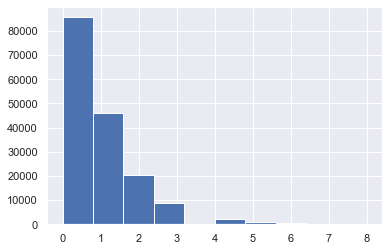



Number_Open_Accounts


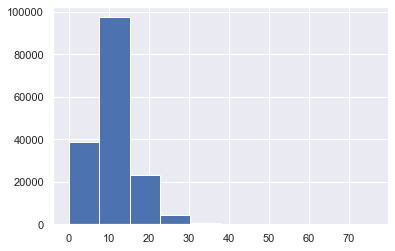



Total_Accounts


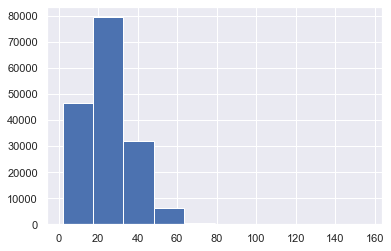



Months_Since_Deliquency


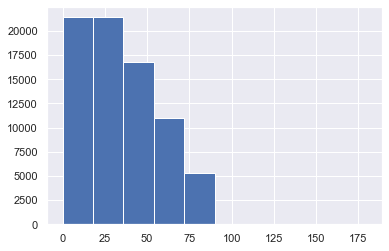



Loan_Amount_Requested


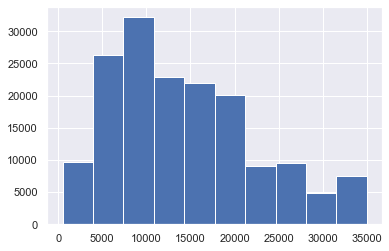



Debt_To_Income


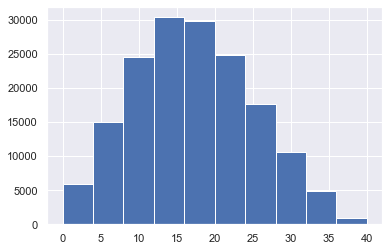



Annual_Income


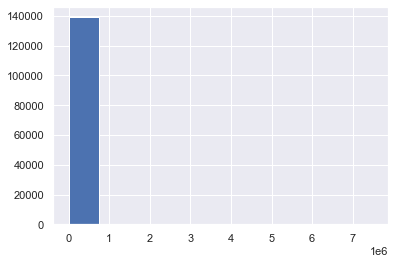

In [16]:
numeric_variables = numerics.index.tolist()

for column in numeric_variables:
    print(column)
    train_data[column].hist()
    plt.show()
    print('\n')

Visualize target variable distribution conditioned on categorical variables.

Gender


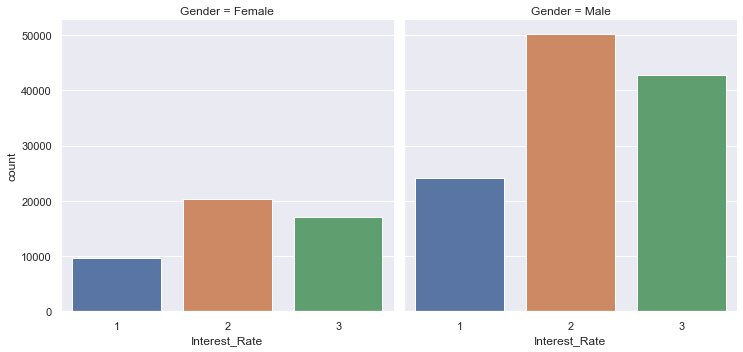

Income_Verified


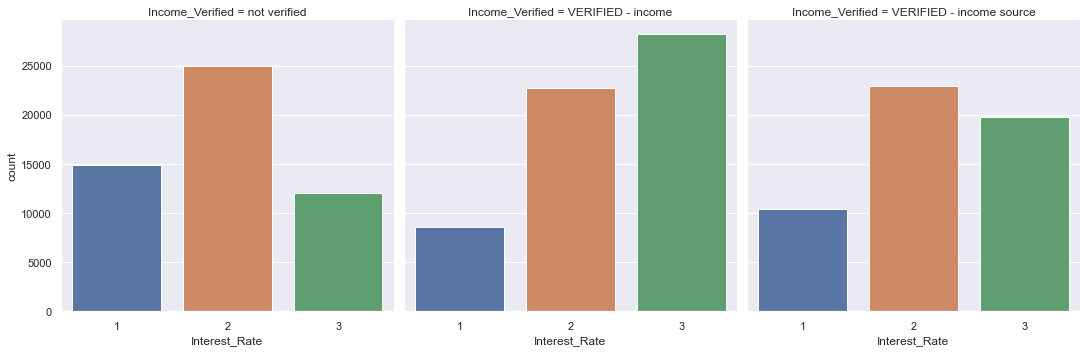

Home_Owner


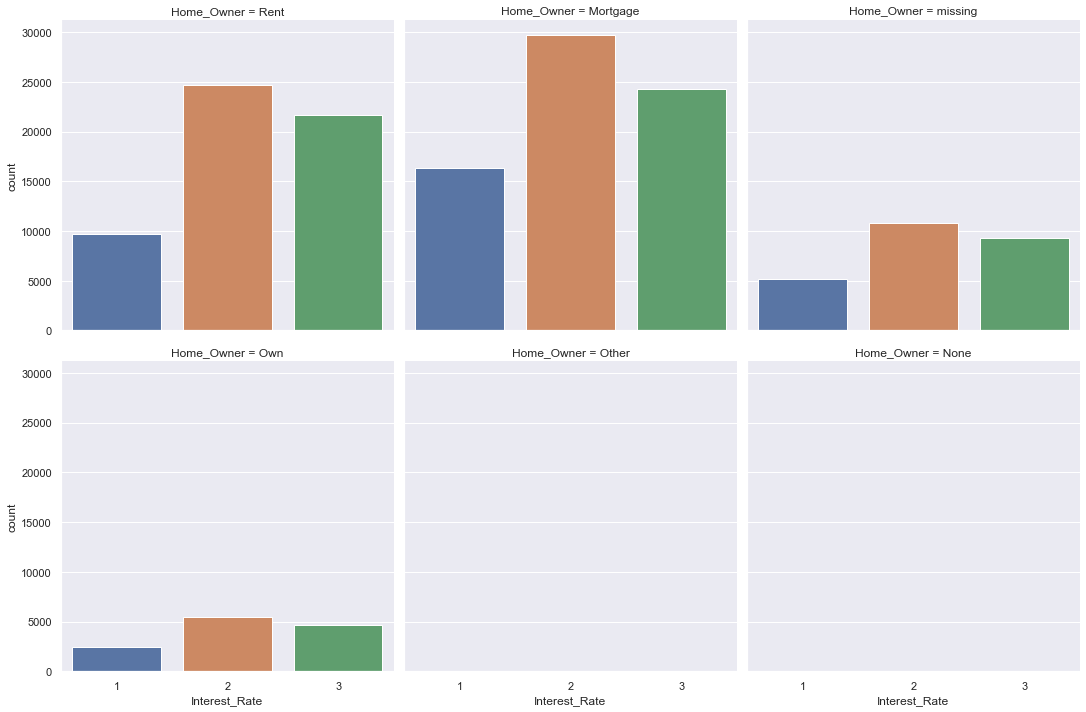

Length_Employed


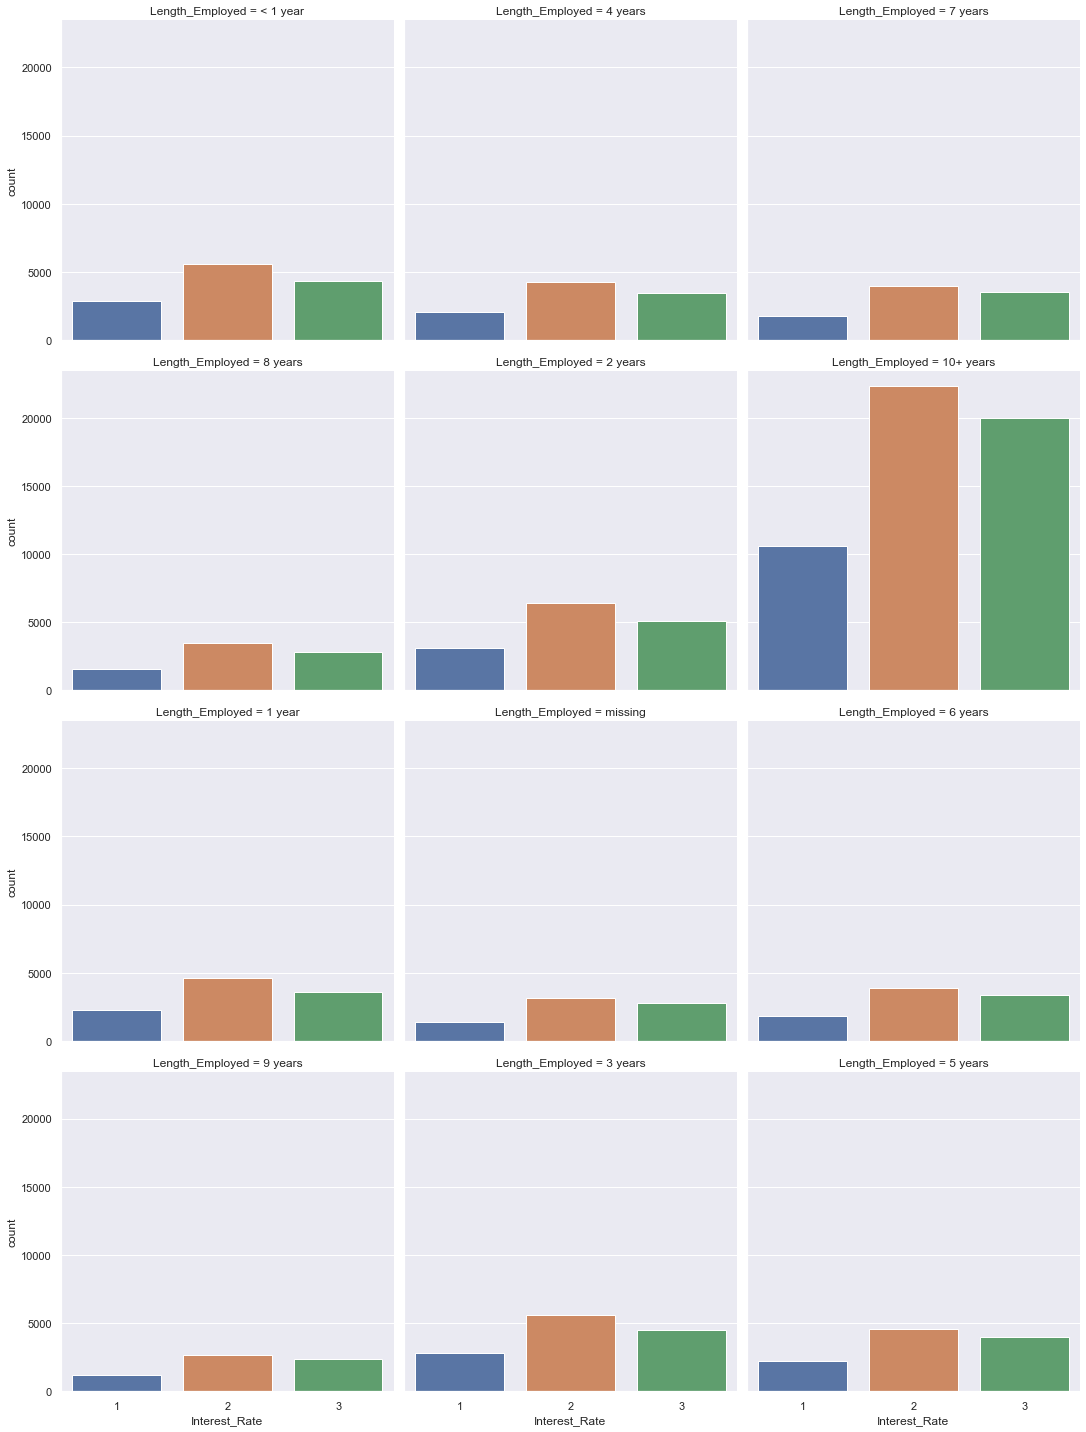

Purpose_Of_Loan


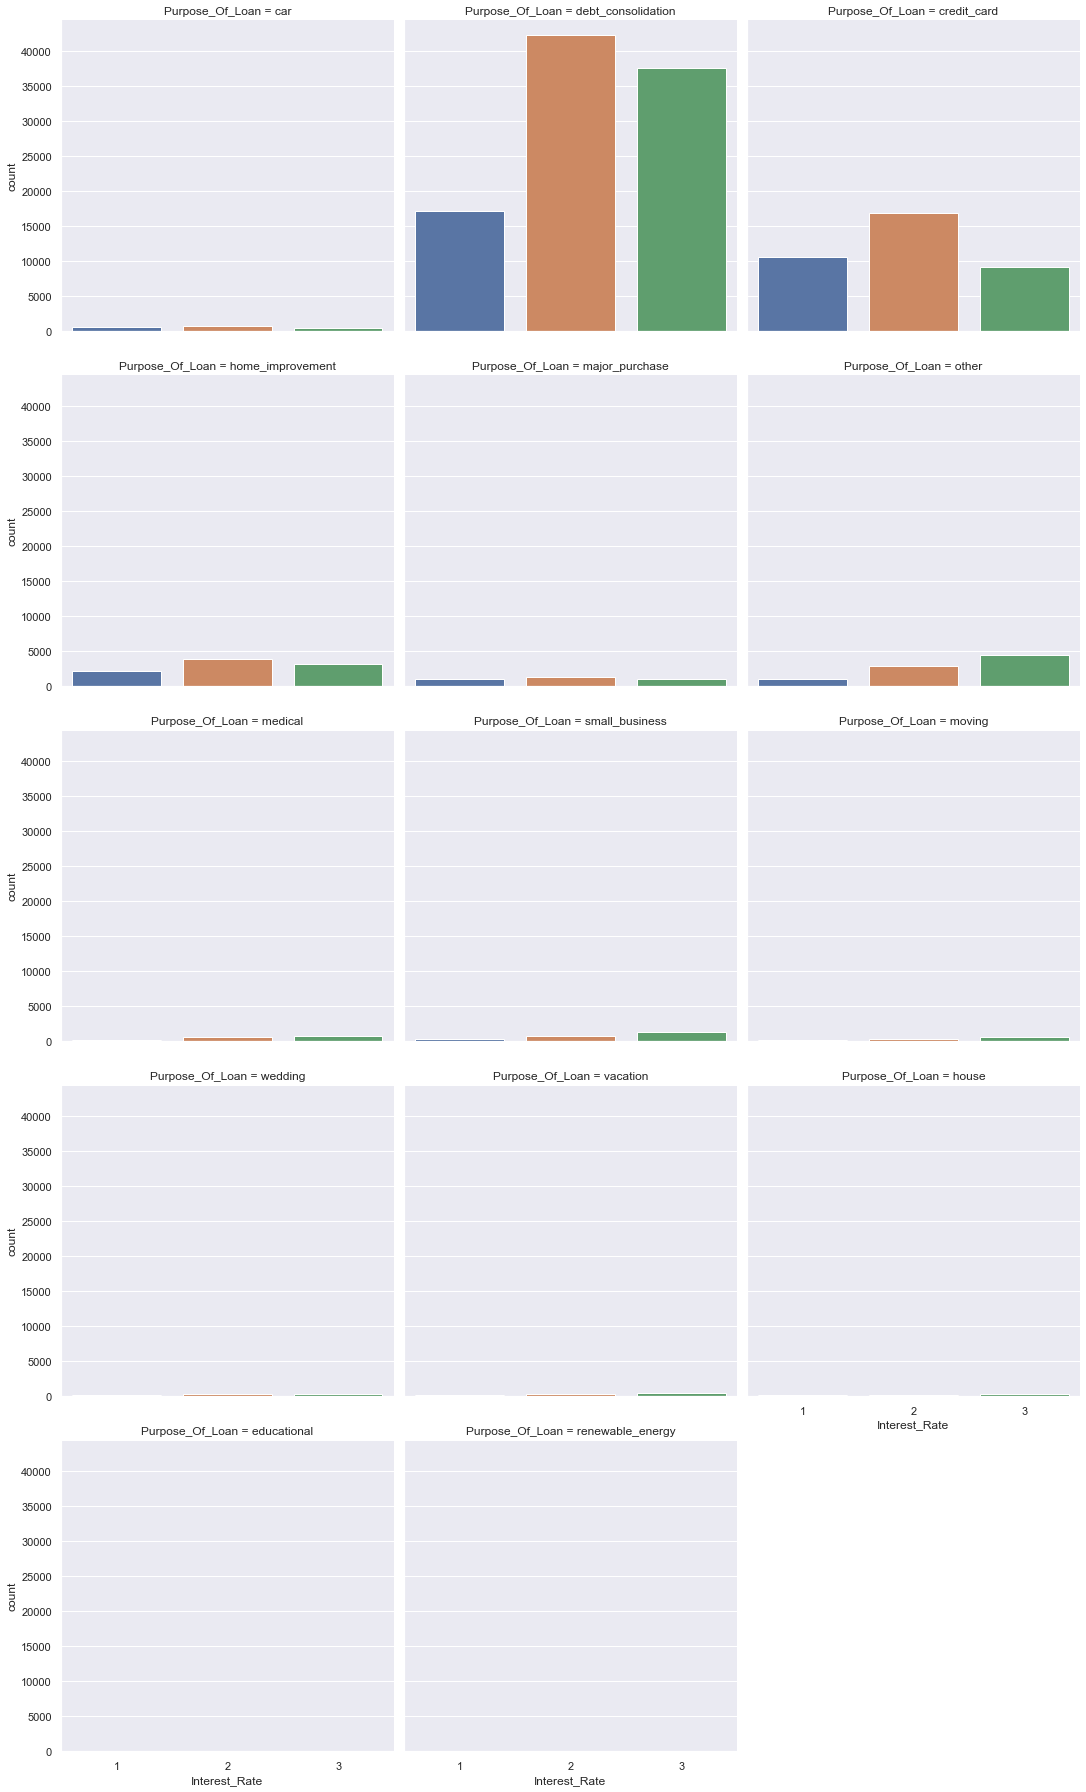

In [17]:
for column in categorical_variables:    
    tmp_data = pd.concat([train_data[column], target_column], axis=1)
    #tmp_data = train_data.loc[:, [column, target_column]].copy()
    indx = tmp_data[column].isnull()
    tmp_data.loc[indx, column] = 'missing'

    print(column)
    sns.catplot(data=tmp_data, x=target_column.name, col=column, col_wrap=3, kind='count')
    plt.show()

In [18]:
for column in categorical_variables:    
    tmp_data = pd.concat([train_data[column], target_column], axis=1)
    indx = tmp_data[column].isnull()
    tmp_data.loc[indx, column] = 'missing'
    
    print(column)
    column_categories = tmp_data[column].value_counts().index.tolist()
    
    for column_category in column_categories:
        print(column_category)
        indx = tmp_data[column] == column_category
        print(tmp_data.loc[indx, target_column.name].value_counts(normalize=True)) 
        print()
    print('\n')


Gender
Male
2    0.428117
3    0.365894
1    0.205989
Name: Interest_Rate, dtype: float64

Female
2    0.433136
3    0.361721
1    0.205143
Name: Interest_Rate, dtype: float64



Income_Verified
VERIFIED - income
3    0.474294
2    0.381515
1    0.144191
Name: Interest_Rate, dtype: float64

VERIFIED - income source
2    0.432198
3    0.372159
1    0.195643
Name: Interest_Rate, dtype: float64

not verified
2    0.481888
1    0.286585
3    0.231527
Name: Interest_Rate, dtype: float64



Home_Owner
Mortgage
2    0.422048
3    0.345312
1    0.232639
Name: Interest_Rate, dtype: float64

Rent
2    0.439703
3    0.386839
1    0.173458
Name: Interest_Rate, dtype: float64

missing
2    0.426526
3    0.367588
1    0.205886
Name: Interest_Rate, dtype: float64

Own
2    0.432415
3    0.368942
1    0.198643
Name: Interest_Rate, dtype: float64

Other
2    0.510204
3    0.285714
1    0.204082
Name: Interest_Rate, dtype: float64

None
1    0.5
3    0.4
2    0.1
Name: Interest_Rate, dtype: float64



L

Now, we are going to have a closer look at the distribution of numeric variables. We also include the distribution of each variable conditioned on the **target column** to see which variables show the highest degree of separation with respect to it.

Inquiries_Last_6Mo


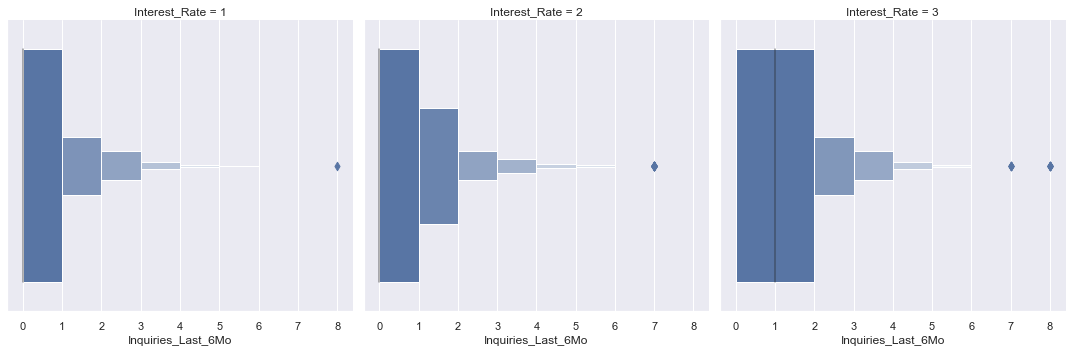


Number_Open_Accounts


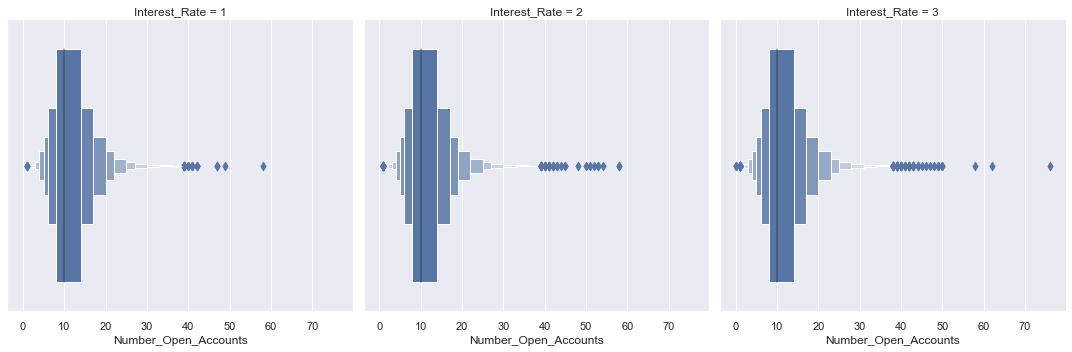


Total_Accounts


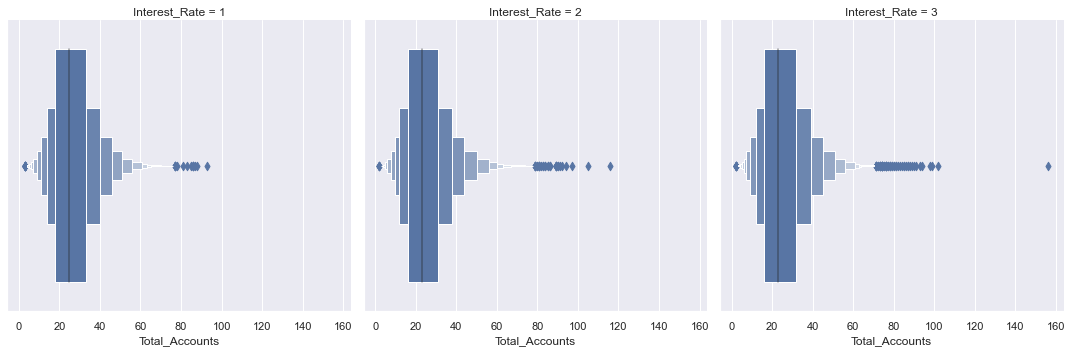


Months_Since_Deliquency


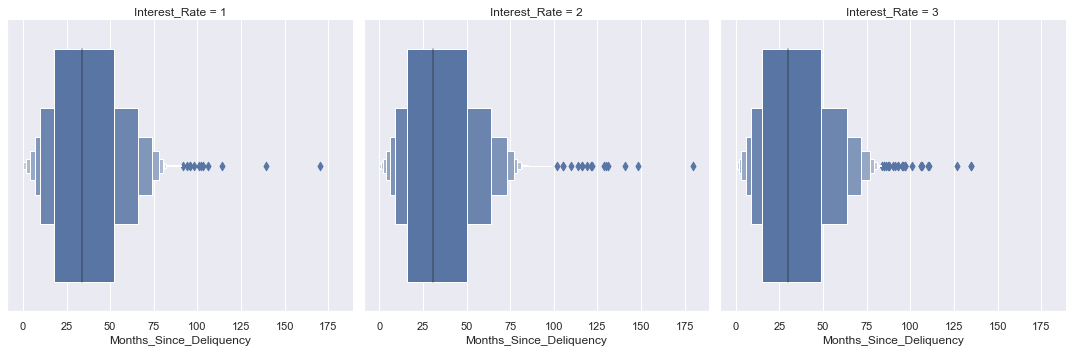


Loan_Amount_Requested


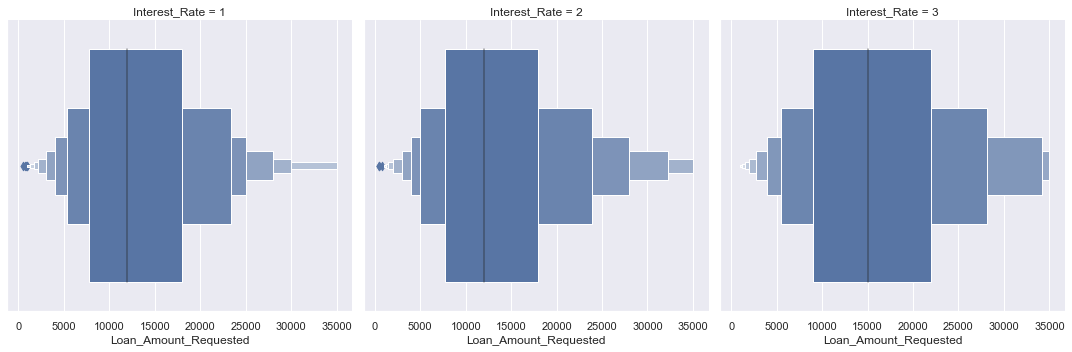


Debt_To_Income


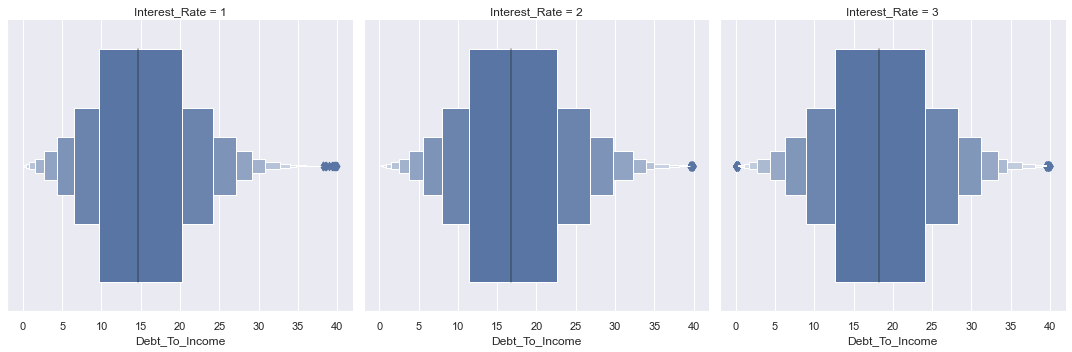


Annual_Income


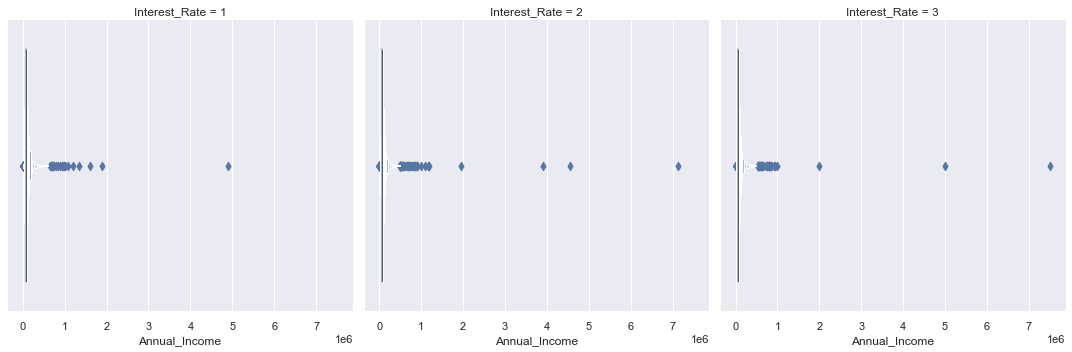

In [19]:
for column in numeric_variables:    
    tmp_data = pd.concat([train_data[column], target_column], axis=1)
    
    print(column)
    sns.catplot(data=tmp_data, x=column, col=target_column.name, kind='boxen')
    plt.show()
    print()

# Part II. Feature Derivation and Engineering

In [20]:
df = train_data.drop(columns=['Loan_ID']).copy()

#
df['Open_To_All_Accounts'] = df['Number_Open_Accounts'] / df['Total_Accounts']
df['Loan_To_Income'] = df['Loan_Amount_Requested'] / df['Annual_Income']
df['Debt_To_Loan'] = df['Debt_To_Income'] * df['Annual_Income'] / df['Loan_Amount_Requested']

#
old_column = 'Length_Employed'
new_column = 'Num_Length_Employed'
indx = df[old_column].isnull()
df.loc[indx, old_column] = 'missing'

def convert_employment_length(row):
    if row == 'missing':
        return 0
    elif row == '< 1 year':
        return 1
    elif row == '10+ years':
        return 11
    else:
        return int(row[0]) + 1

df[new_column] = df[old_column].copy().apply(convert_employment_length).astype(np.int8)

#
column = 'Home_Owner'
indx = df[column].isin(('Other', 'None'))
df.loc[indx, column] = np.NaN
df.loc[df[column].isna(), column] = 'missing'


new_num_columns = ['Open_To_All_Accounts', 'Loan_To_Income', 'Debt_To_Loan', 'Num_Length_Employed']

Distribution of the newly created numeric variables conditioned on the **target variable**.

Open_To_All_Accounts


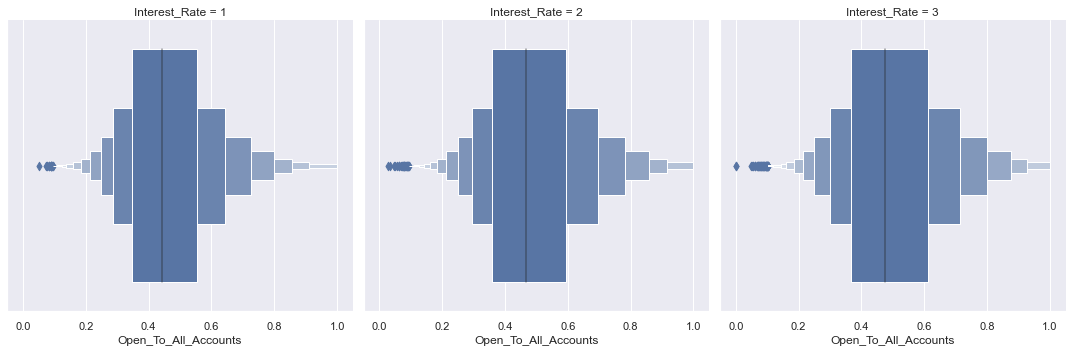


Loan_To_Income


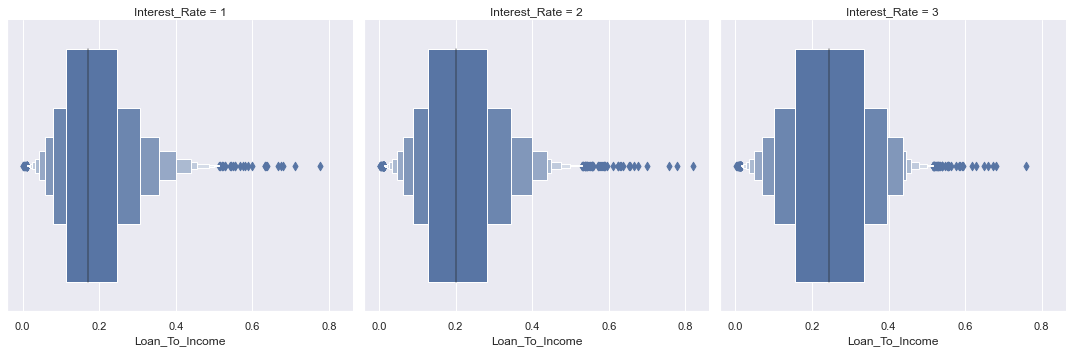


Debt_To_Loan


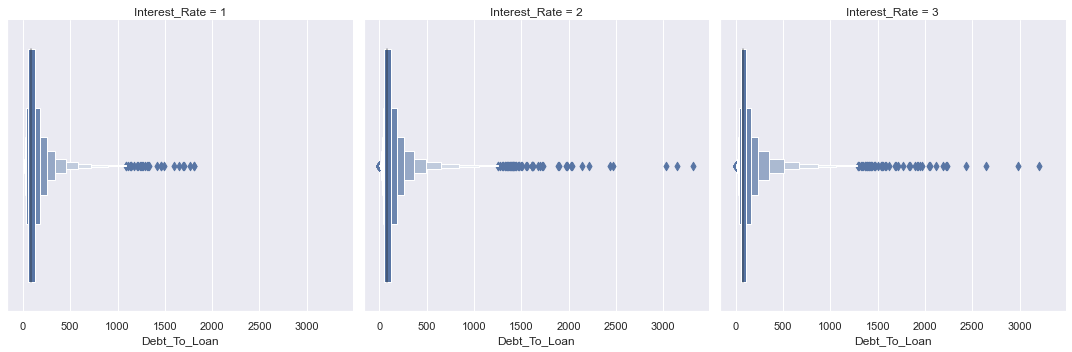


Num_Length_Employed


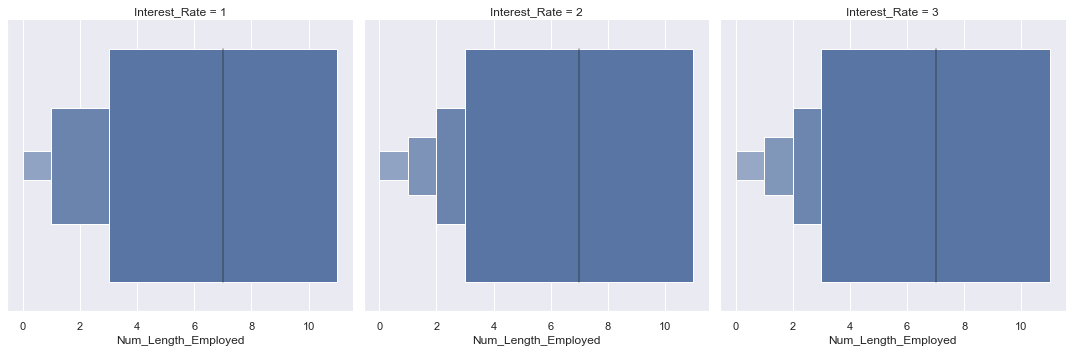

In [21]:
for column in new_num_columns:    
    tmp = pd.concat([df[column], target_column], axis=1)
    
    print(column)
    sns.catplot(data=tmp, x=column, col=target_column.name, kind='boxen')
    #plt.xlim(0, 100)
    plt.show()
    print()

Select numeric and categorical variables for feature engineering.

In [22]:
applicable_numeric_variables = df.columns[list(map(pd.api.types.is_numeric_dtype, df.dtypes.values))].to_list()
applicable_numeric_variables

['Loan_Amount_Requested',
 'Annual_Income',
 'Debt_To_Income',
 'Inquiries_Last_6Mo',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Total_Accounts',
 'Open_To_All_Accounts',
 'Loan_To_Income',
 'Debt_To_Loan',
 'Num_Length_Employed']

In [23]:
applicable_categorical_variables = df.columns[list(map(pd.api.types.is_object_dtype, df.dtypes.values))].to_list()
applicable_categorical_variables.remove('Gender')
applicable_categorical_variables

['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan']

Feature engineering by aggregation.

In [24]:
def aggregate_num_column_by_cat_column(df, target_column, cat_column_name, num_column_name, agg_function = 'mean'):
    tmp = df.loc[:, [num_column_name, cat_column_name]]
    tmp = tmp.groupby(cat_column_name)[num_column_name].agg(agg_function)

    new_column_name = agg_function.capitalize() + '_' + num_column_name + '_by_' + cat_column_name
    df[new_column_name] = 0

    cat_column_values = df[cat_column_name].value_counts().index.tolist()

    for cat_column_value in cat_column_values:
        indx = df[cat_column_name] == cat_column_value
        df.loc[indx, new_column_name] = tmp[cat_column_value] #old_column_counts[cat_column_name] 

    tmp_data = pd.concat([df[new_column_name], target_column], axis=1)

    print(f'{new_column_name} by {target_column.name}')
    sns.catplot(data=tmp_data, x=new_column_name, col=target_column.name, kind='boxen')
    plt.show()
    
    print(f'\n\n{new_column_name}')
    print(tmp.sort_values(ascending=False))
    
    # quasi-normalized bar plot    
    tmp /= tmp.max()
    print(f'\n\nQuasi-normalized {new_column_name}')
    sns.barplot(x=tmp.values, y=tmp.index)
    plt.show()
    
    
    print(f'\n\nComparison od normalized within categories and original {num_column_name}')
    # num_column normalized by mean values in categories
    tmp = df.loc[:, [num_column_name, cat_column_name]]
    tmp = tmp.groupby(cat_column_name)[num_column_name].transform(agg_function)
    tmp = df[num_column_name] / tmp
    tmp = pd.concat([tmp, target_column], axis=1)
    
    tmp_column_name = num_column_name + '_normalized'
    tmp.columns = [tmp_column_name, target_column.name]
    
    sns.catplot(data=tmp, x=tmp_column_name, col=target_column.name, kind='boxen')
    plt.show()
    
    # original num_column
    tmp = pd.concat([df[num_column_name], target_column], axis=1)
    
    sns.catplot(data=tmp, x=num_column_name, col=target_column.name, kind='boxen')
    plt.show()
    print('\n\n\n')

Mean_Loan_Amount_Requested_by_Length_Employed by Interest_Rate


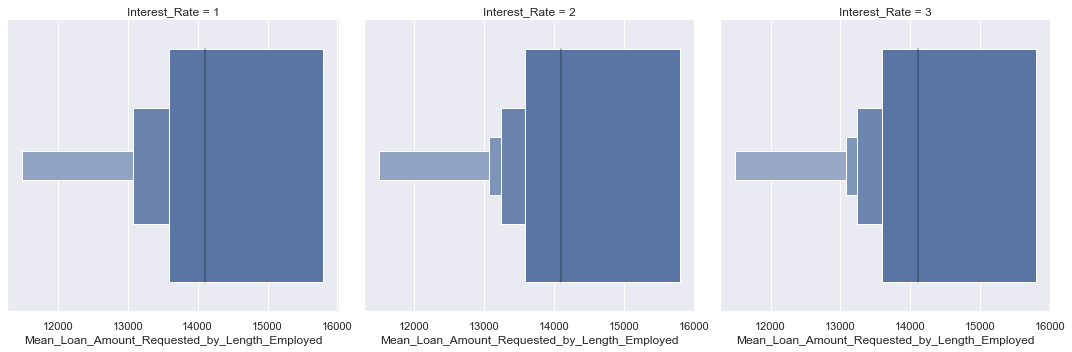



Mean_Loan_Amount_Requested_by_Length_Employed
Length_Employed
10+ years    15800.171974
9 years      14850.688146
8 years      14517.361374
7 years      14439.637946
6 years      14103.216406
5 years      13850.906233
4 years      13733.130621
3 years      13699.460459
2 years      13592.093023
1 year       13242.355114
< 1 year     13073.049590
missing      11493.108126
Name: Loan_Amount_Requested, dtype: float64


Quasi-normalized Mean_Loan_Amount_Requested_by_Length_Employed


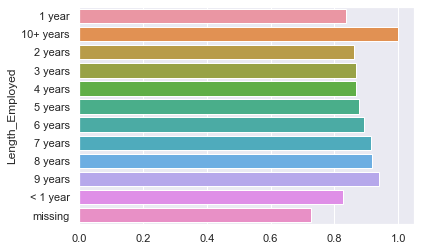



Comparison od normalized within categories and original Loan_Amount_Requested


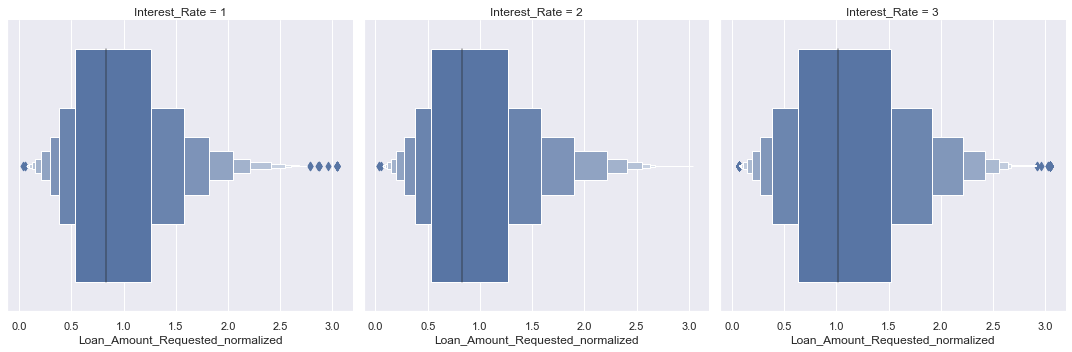

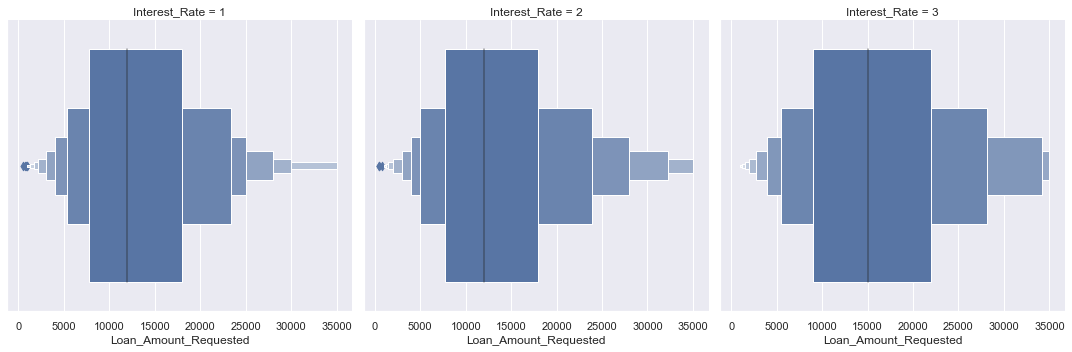





Mean_Annual_Income_by_Length_Employed by Interest_Rate


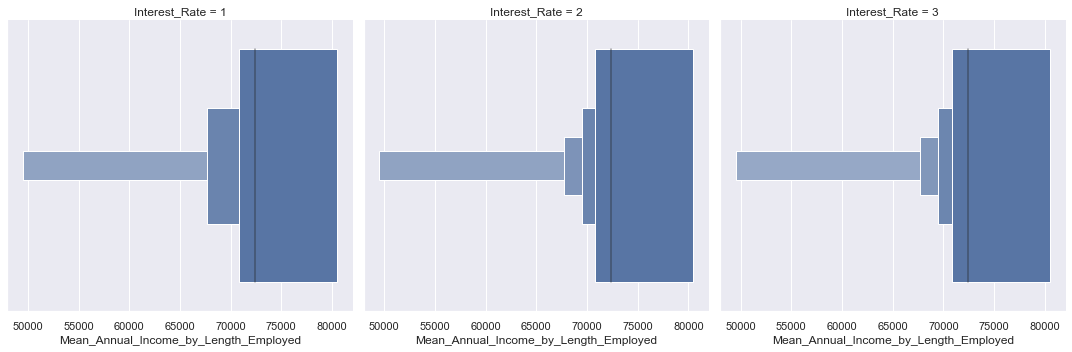



Mean_Annual_Income_by_Length_Employed
Length_Employed
10+ years    80509.442067
8 years      74645.174631
9 years      73860.317171
7 years      72690.152705
3 years      72395.394749
6 years      72043.155295
5 years      71704.917747
4 years      71150.557520
2 years      70832.590654
1 year       69486.857814
< 1 year     67694.486632
missing      49508.856911
Name: Annual_Income, dtype: float64


Quasi-normalized Mean_Annual_Income_by_Length_Employed


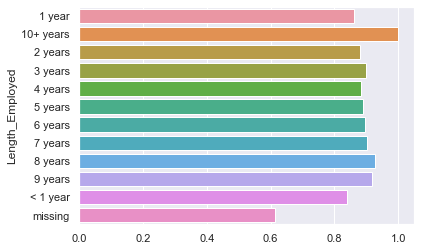



Comparison od normalized within categories and original Annual_Income


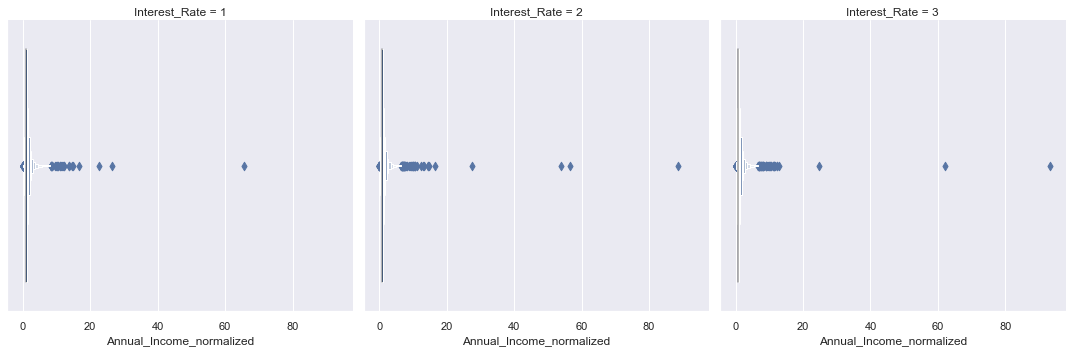

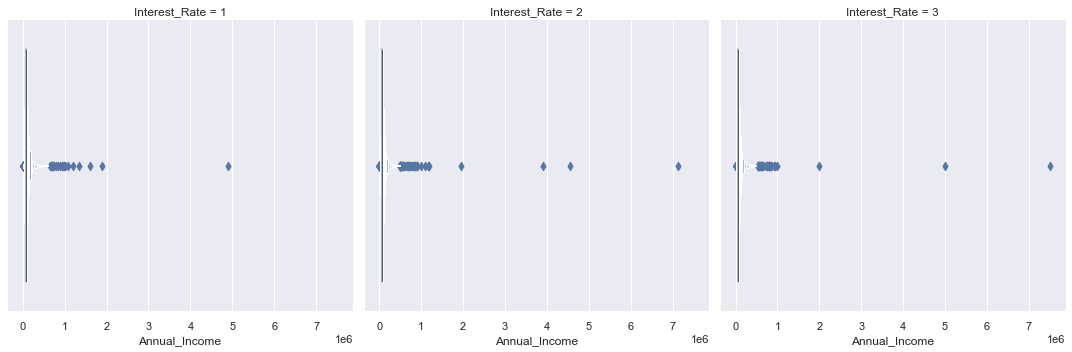





Mean_Debt_To_Income_by_Length_Employed by Interest_Rate


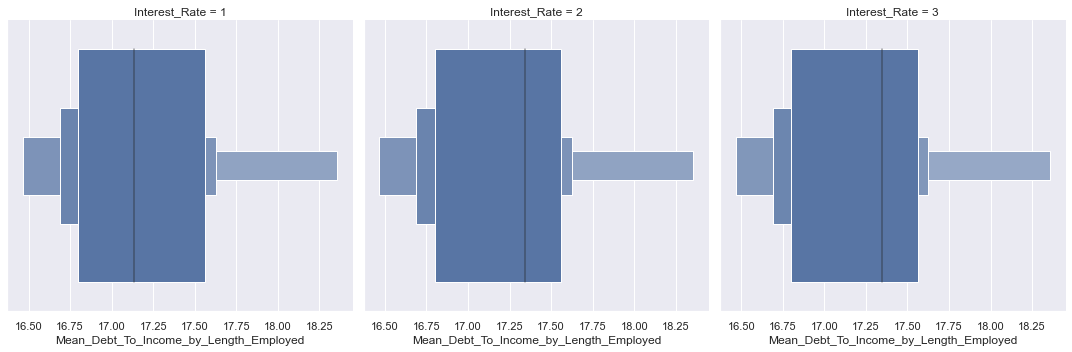



Mean_Debt_To_Income_by_Length_Employed
Length_Employed
missing      18.357059
9 years      17.625526
10+ years    17.560340
7 years      17.369408
8 years      17.343808
6 years      17.137151
5 years      17.029910
2 years      16.831531
3 years      16.799967
4 years      16.781815
1 year       16.688801
< 1 year     16.466109
Name: Debt_To_Income, dtype: float64


Quasi-normalized Mean_Debt_To_Income_by_Length_Employed


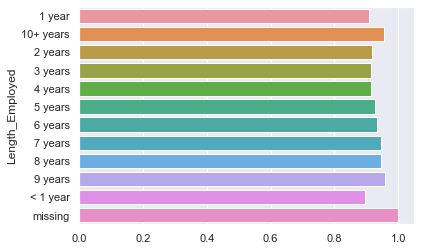



Comparison od normalized within categories and original Debt_To_Income


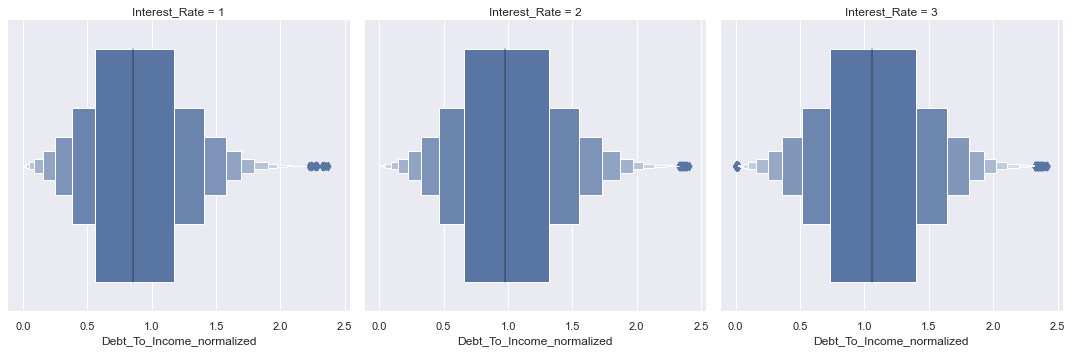

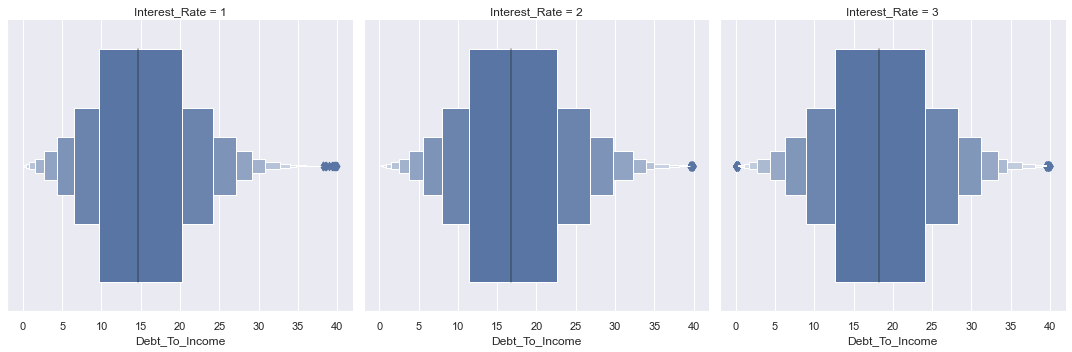





Mean_Inquiries_Last_6Mo_by_Length_Employed by Interest_Rate


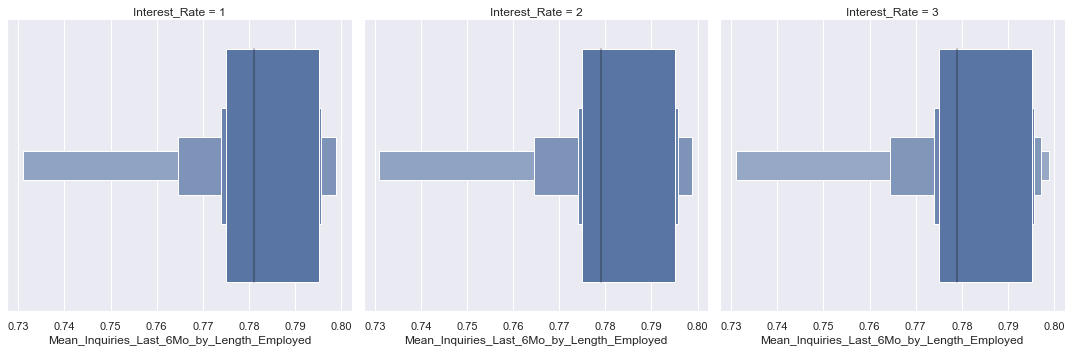



Mean_Inquiries_Last_6Mo_by_Length_Employed
Length_Employed
1 year       0.798887
6 years      0.797119
2 years      0.795691
3 years      0.795129
7 years      0.794048
5 years      0.793601
< 1 year     0.781179
8 years      0.778957
10+ years    0.774960
4 years      0.774019
9 years      0.764519
missing      0.730973
Name: Inquiries_Last_6Mo, dtype: float64


Quasi-normalized Mean_Inquiries_Last_6Mo_by_Length_Employed


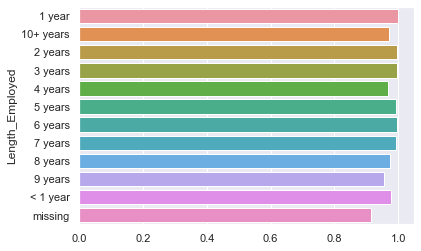



Comparison od normalized within categories and original Inquiries_Last_6Mo


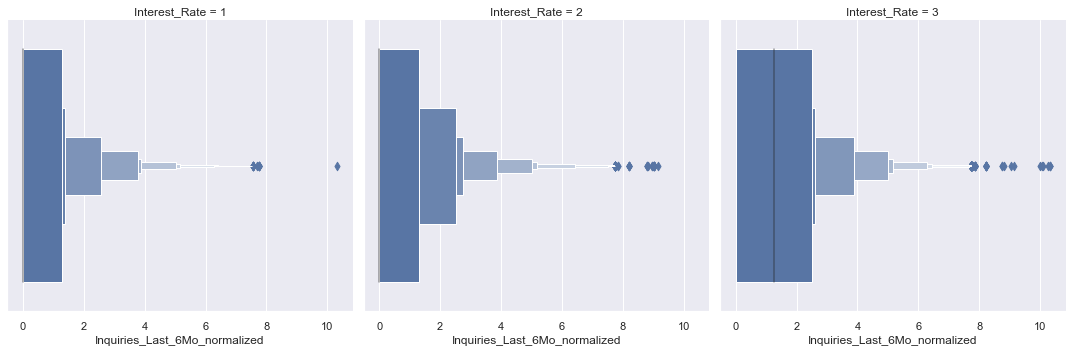

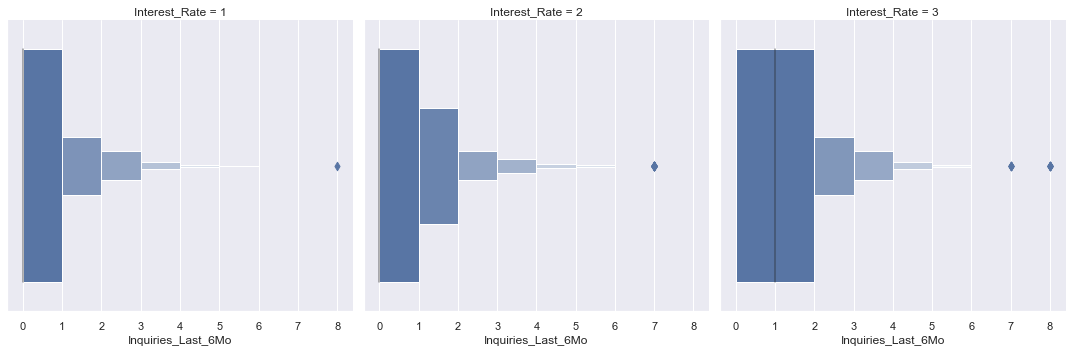





Mean_Months_Since_Deliquency_by_Length_Employed by Interest_Rate


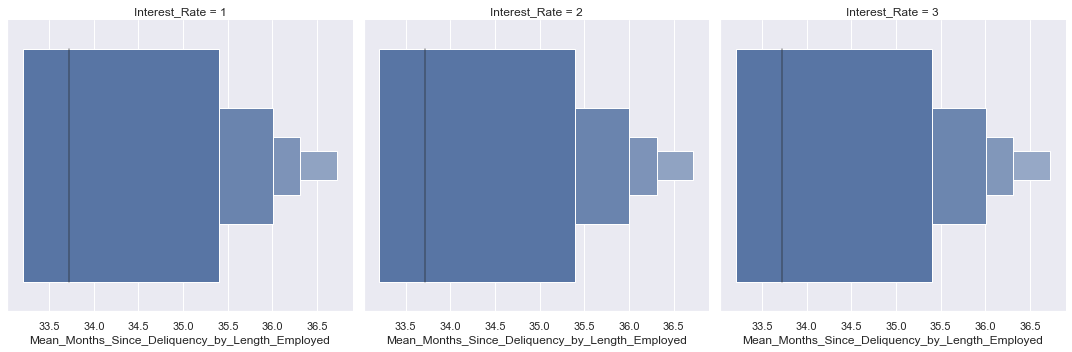



Mean_Months_Since_Deliquency_by_Length_Employed
Length_Employed
missing      36.723086
6 years      36.310668
7 years      36.005671
5 years      35.493512
4 years      35.400276
8 years      34.707127
3 years      34.526325
< 1 year     33.763777
9 years      33.720743
1 year       33.546574
2 years      33.478717
10+ years    33.206395
Name: Months_Since_Deliquency, dtype: float64


Quasi-normalized Mean_Months_Since_Deliquency_by_Length_Employed


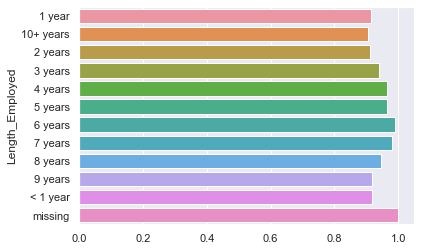



Comparison od normalized within categories and original Months_Since_Deliquency


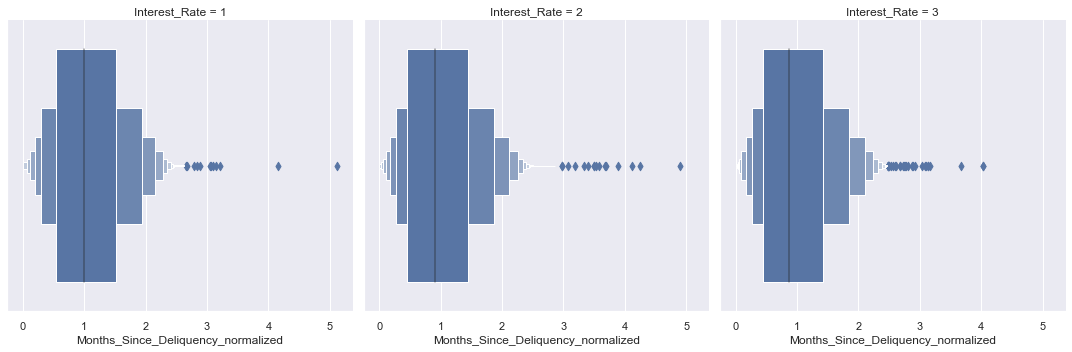

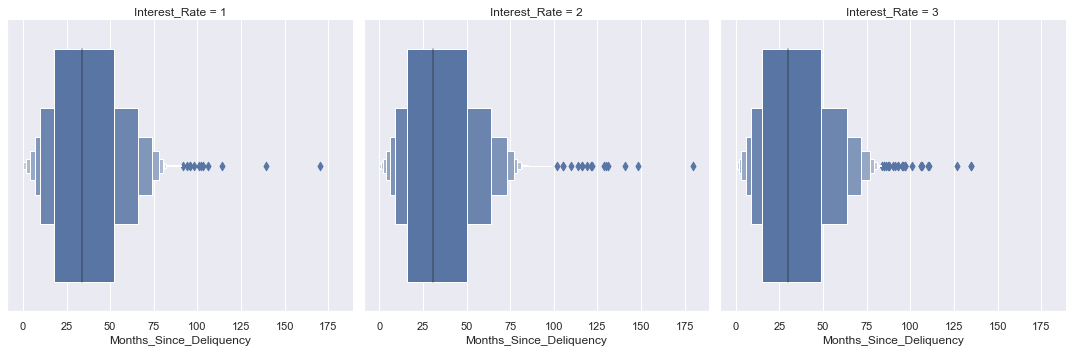





Mean_Number_Open_Accounts_by_Length_Employed by Interest_Rate


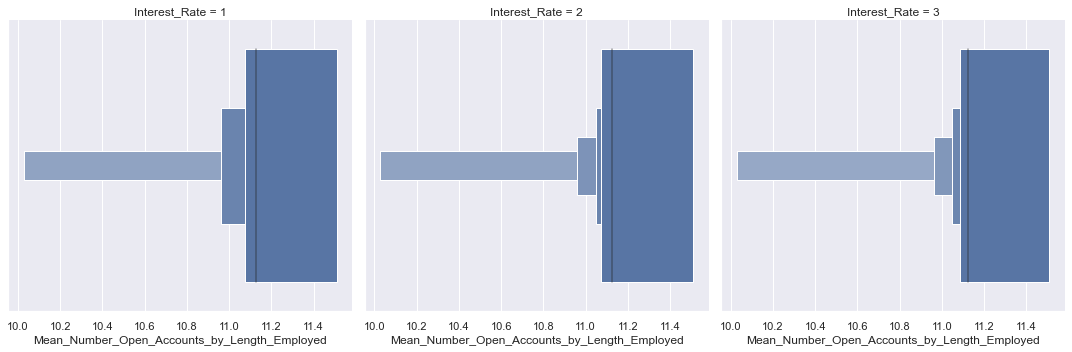



Mean_Number_Open_Accounts_by_Length_Employed
Length_Employed
10+ years    11.508929
9 years      11.291647
8 years      11.282557
7 years      11.251934
2 years      11.125650
4 years      11.104354
6 years      11.103475
3 years      11.084400
1 year       11.073306
5 years      11.047346
< 1 year     10.960250
missing      10.028626
Name: Number_Open_Accounts, dtype: float64


Quasi-normalized Mean_Number_Open_Accounts_by_Length_Employed


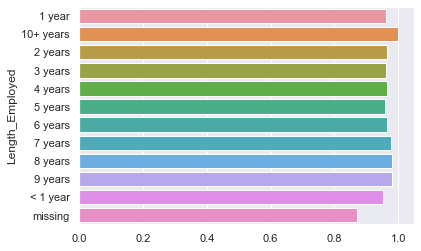



Comparison od normalized within categories and original Number_Open_Accounts


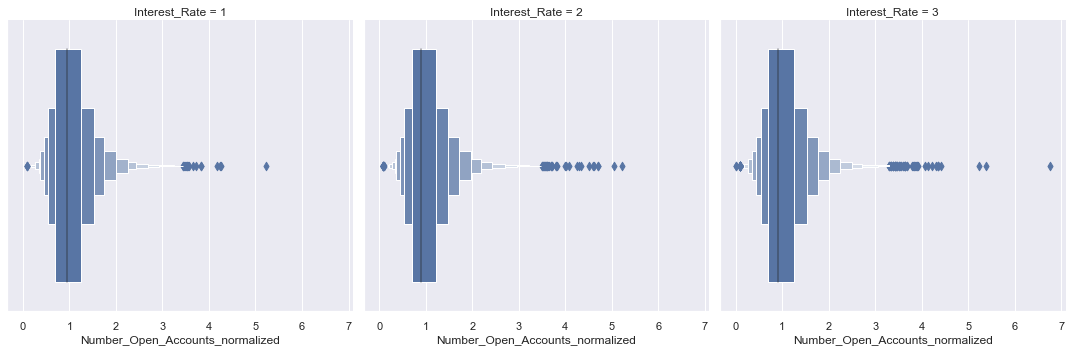

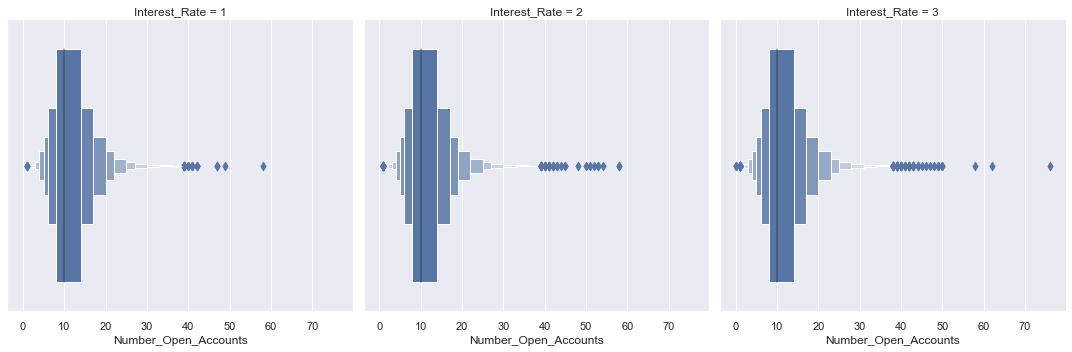





Mean_Total_Accounts_by_Length_Employed by Interest_Rate


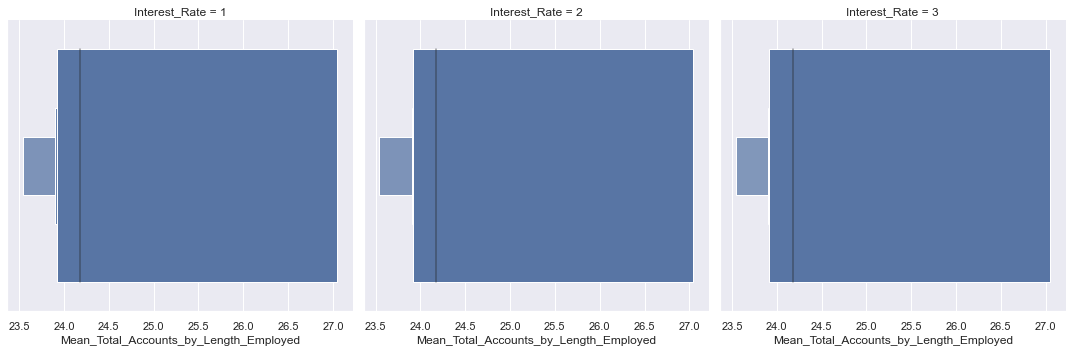



Mean_Total_Accounts_by_Length_Employed
Length_Employed
10+ years    27.046149
9 years      25.218138
8 years      24.973222
7 years      24.701869
6 years      24.177040
3 years      24.005087
missing      23.988197
2 years      23.959918
1 year       23.916715
5 years      23.909192
4 years      23.904436
< 1 year     23.541429
Name: Total_Accounts, dtype: float64


Quasi-normalized Mean_Total_Accounts_by_Length_Employed


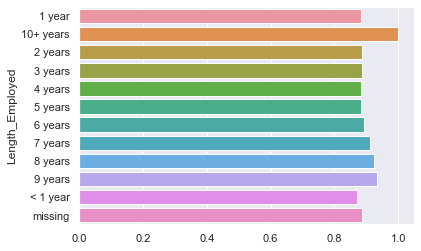



Comparison od normalized within categories and original Total_Accounts


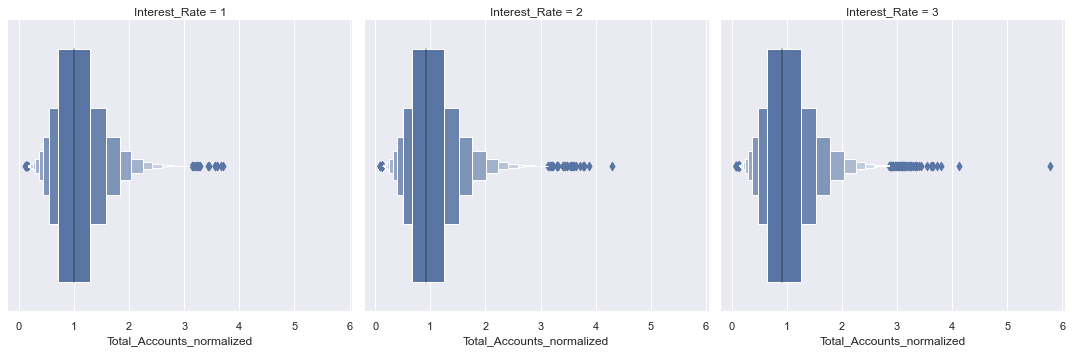

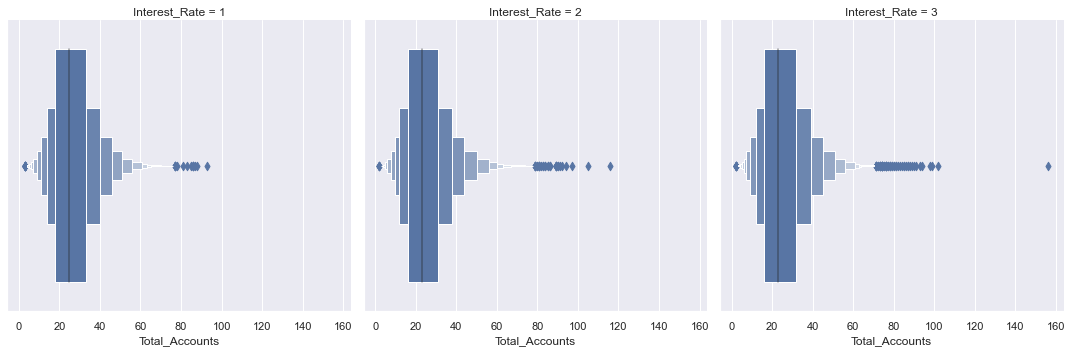





Mean_Open_To_All_Accounts_by_Length_Employed by Interest_Rate


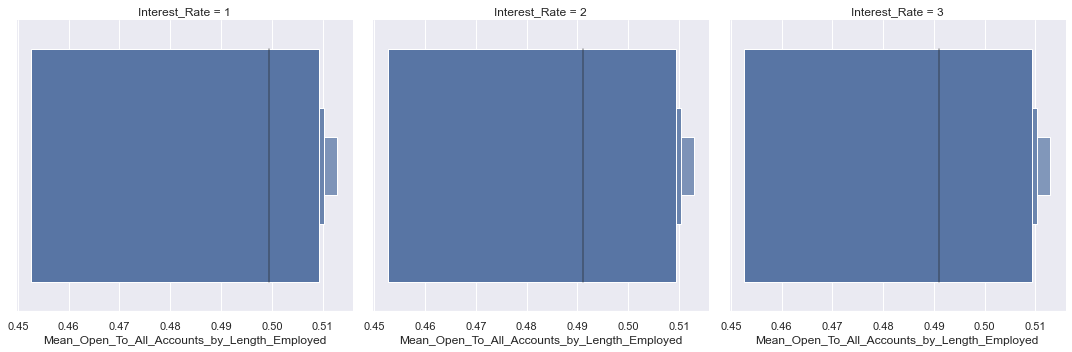



Mean_Open_To_All_Accounts_by_Length_Employed
Length_Employed
< 1 year     0.512938
4 years      0.510317
1 year       0.509884
2 years      0.509404
3 years      0.506807
5 years      0.503553
6 years      0.499457
7 years      0.491045
8 years      0.485582
9 years      0.479376
missing      0.458870
10+ years    0.452639
Name: Open_To_All_Accounts, dtype: float64


Quasi-normalized Mean_Open_To_All_Accounts_by_Length_Employed


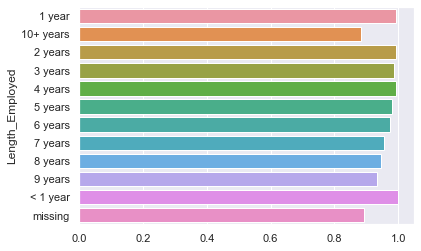



Comparison od normalized within categories and original Open_To_All_Accounts


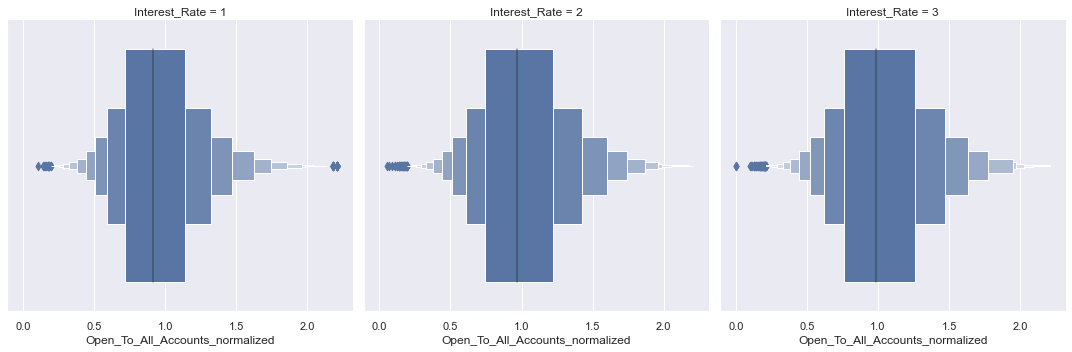

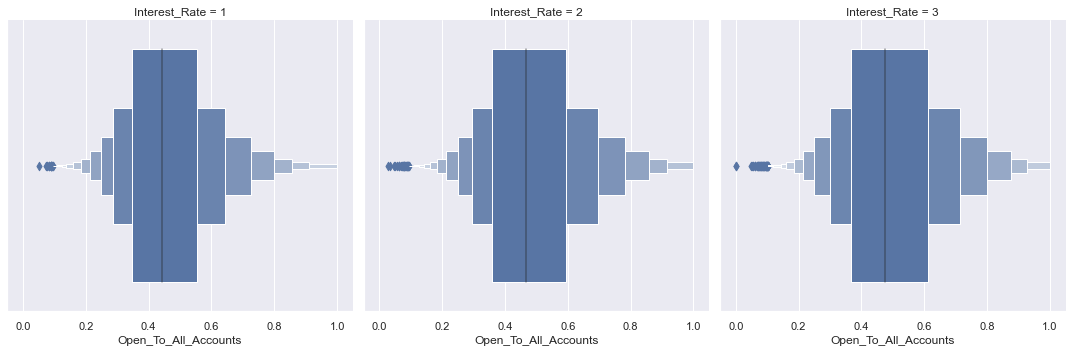





Mean_Loan_To_Income_by_Length_Employed by Interest_Rate


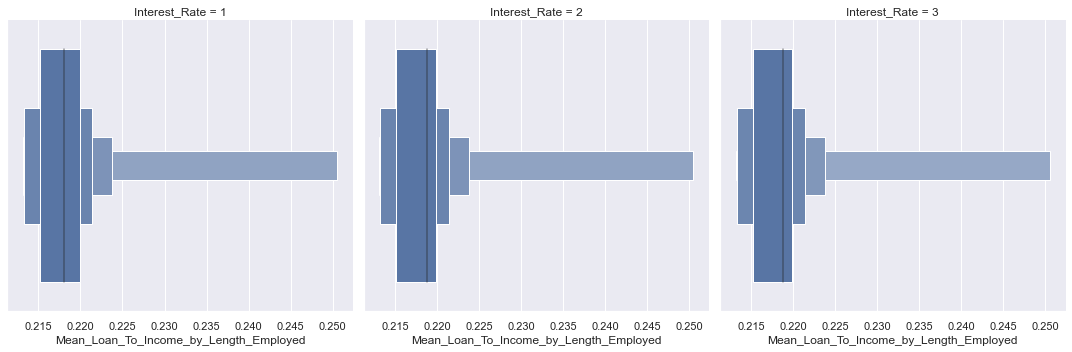



Mean_Loan_To_Income_by_Length_Employed
Length_Employed
missing      0.250532
9 years      0.223776
7 years      0.221388
10+ years    0.219906
8 years      0.218793
6 years      0.218098
5 years      0.216588
4 years      0.215379
< 1 year     0.215185
3 years      0.213763
2 years      0.213280
1 year       0.213151
Name: Loan_To_Income, dtype: float64


Quasi-normalized Mean_Loan_To_Income_by_Length_Employed


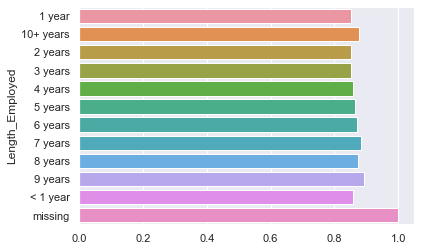



Comparison od normalized within categories and original Loan_To_Income


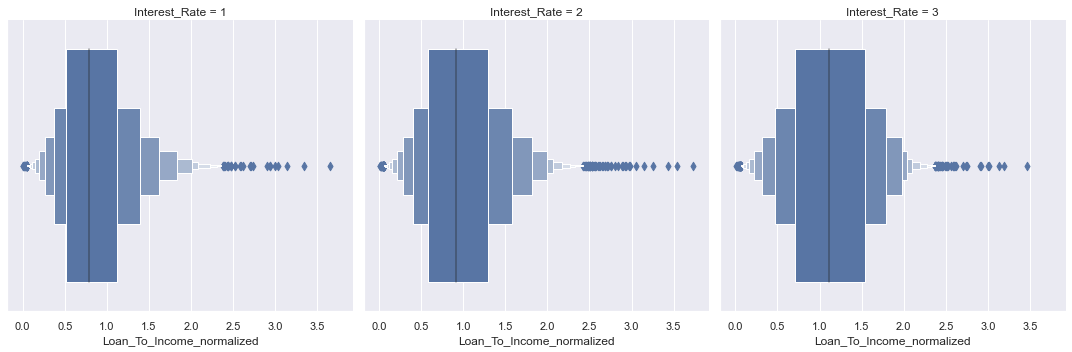

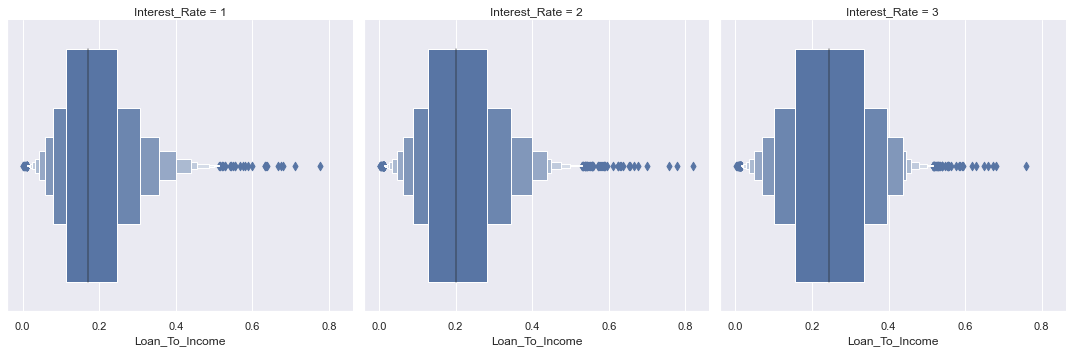





Mean_Debt_To_Loan_by_Length_Employed by Interest_Rate


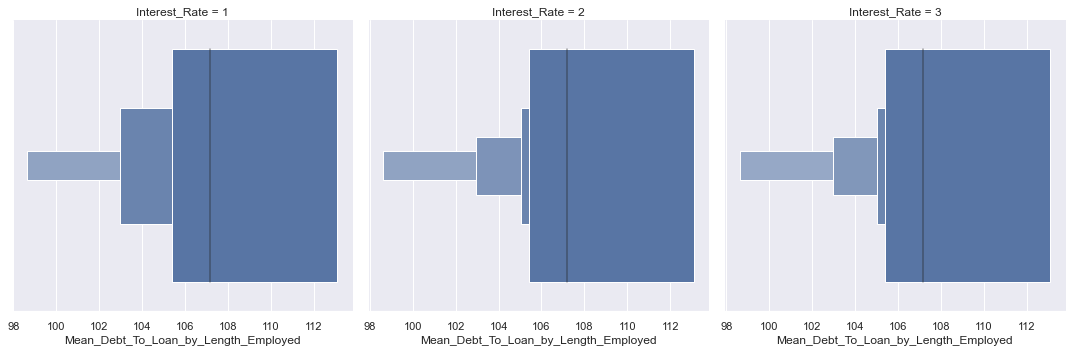



Mean_Debt_To_Loan_by_Length_Employed
Length_Employed
10+ years    113.088273
8 years      108.956134
9 years      108.129934
7 years      107.420041
5 years      107.169475
6 years      107.100269
3 years      106.035653
4 years      105.554797
2 years      105.398999
1 year       105.038189
< 1 year     102.967381
missing       98.639754
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Length_Employed


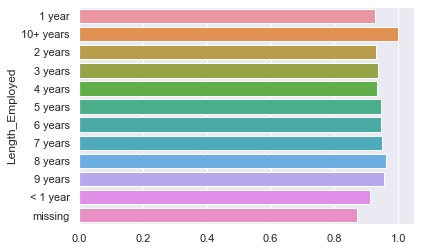



Comparison od normalized within categories and original Debt_To_Loan


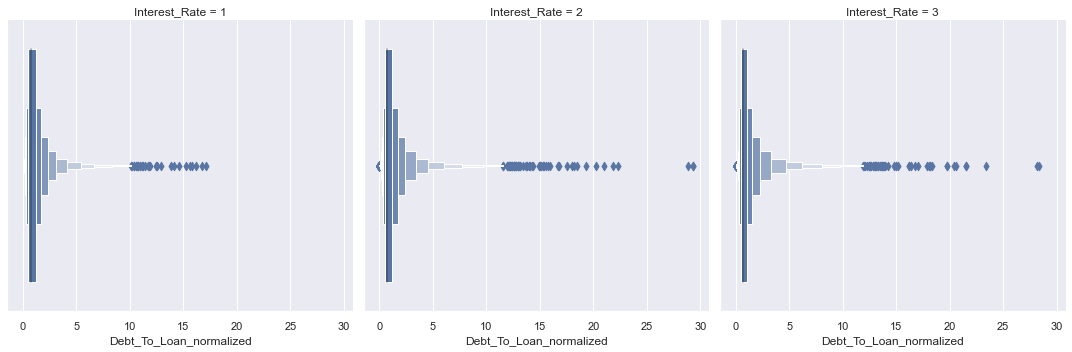

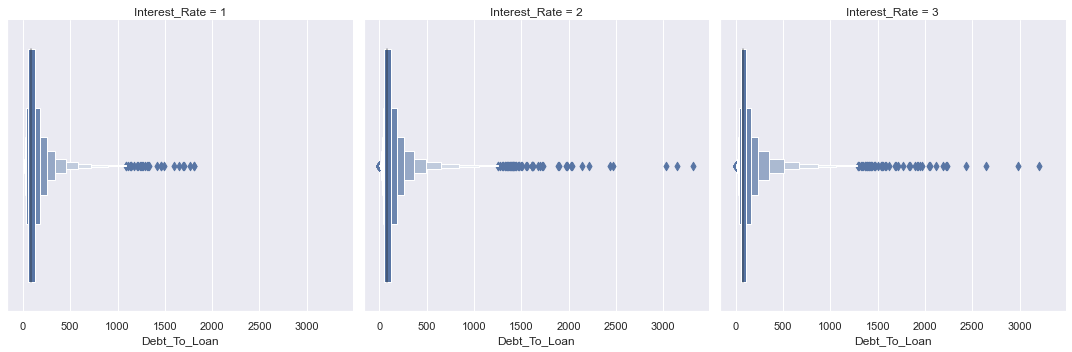





Mean_Num_Length_Employed_by_Length_Employed by Interest_Rate


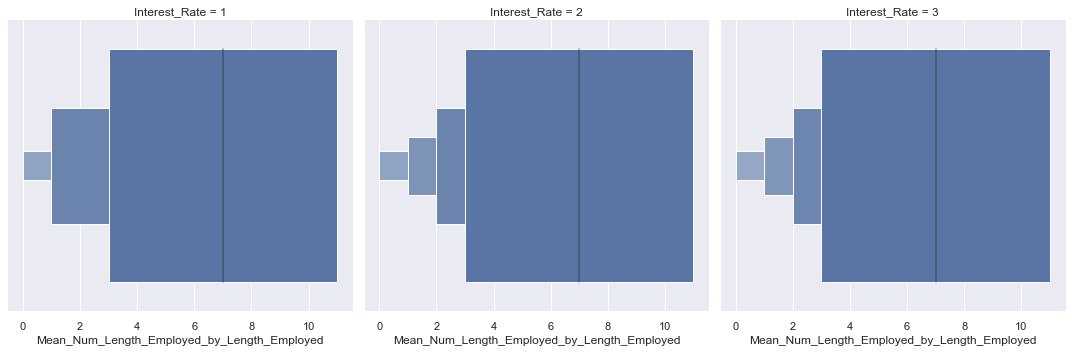



Mean_Num_Length_Employed_by_Length_Employed
Length_Employed
10+ years    11
9 years      10
8 years       9
7 years       8
6 years       7
5 years       6
4 years       5
3 years       4
2 years       3
1 year        2
< 1 year      1
missing       0
Name: Num_Length_Employed, dtype: int8


Quasi-normalized Mean_Num_Length_Employed_by_Length_Employed


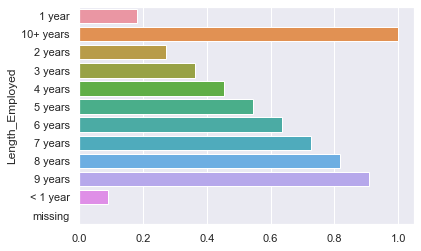



Comparison od normalized within categories and original Num_Length_Employed


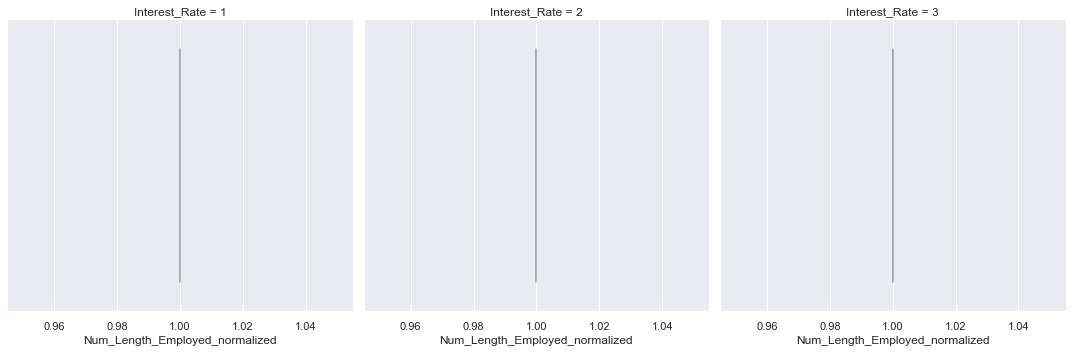

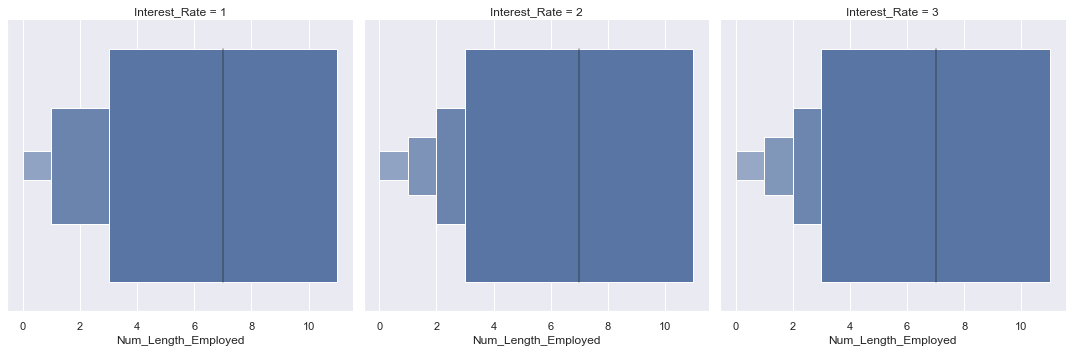





Mean_Loan_Amount_Requested_by_Home_Owner by Interest_Rate


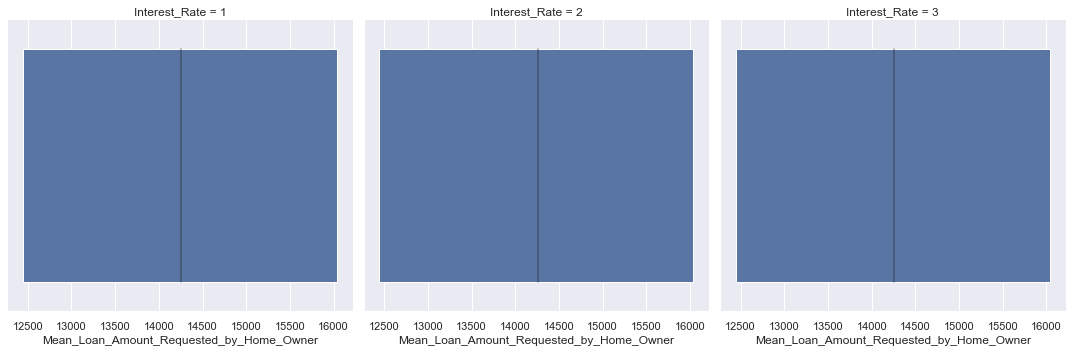



Mean_Loan_Amount_Requested_by_Home_Owner
Home_Owner
Mortgage    16040.132206
missing     14255.598630
Own         13567.704591
Rent        12443.831986
Name: Loan_Amount_Requested, dtype: float64


Quasi-normalized Mean_Loan_Amount_Requested_by_Home_Owner


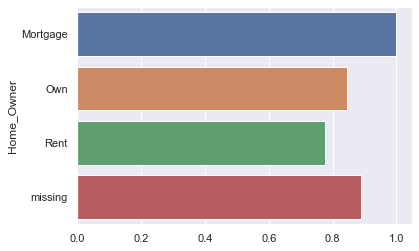



Comparison od normalized within categories and original Loan_Amount_Requested


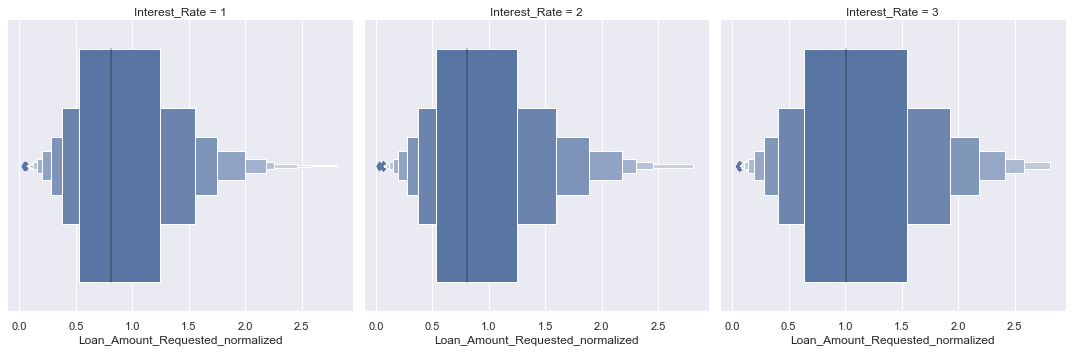

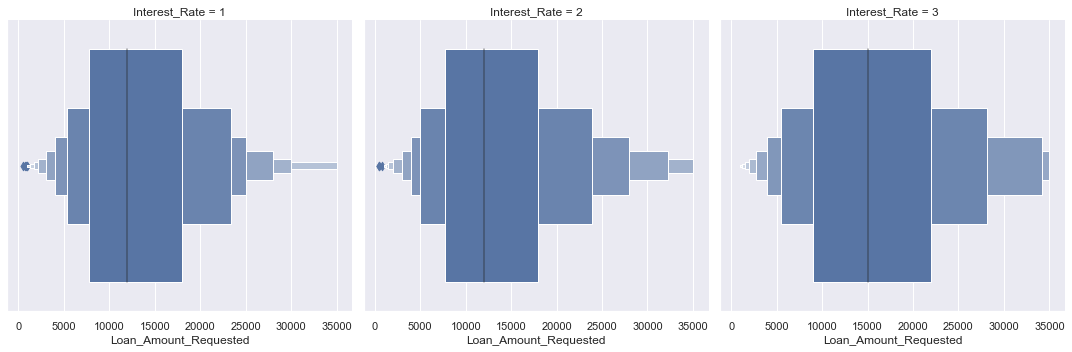





Mean_Annual_Income_by_Home_Owner by Interest_Rate


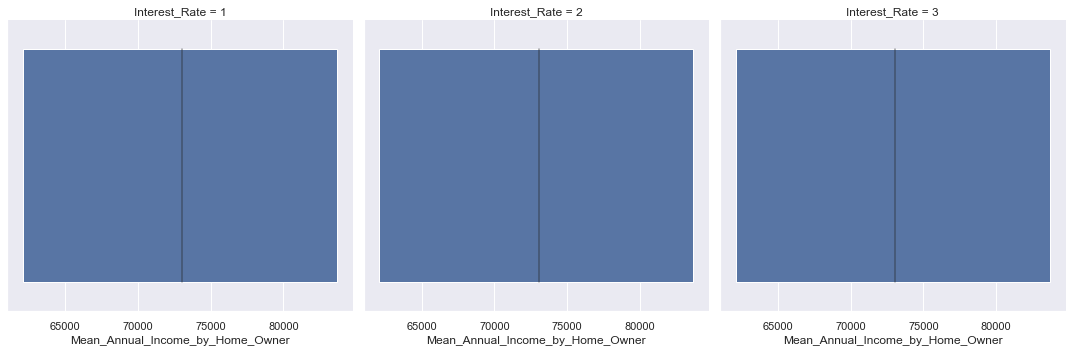



Mean_Annual_Income_by_Home_Owner
Home_Owner
Mortgage    83699.371184
missing     73053.499170
Own         66104.826361
Rent        62077.534637
Name: Annual_Income, dtype: float64


Quasi-normalized Mean_Annual_Income_by_Home_Owner


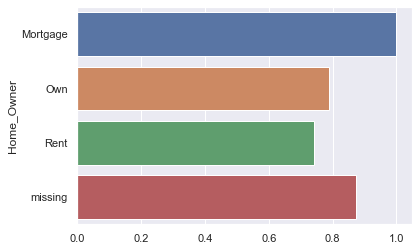



Comparison od normalized within categories and original Annual_Income


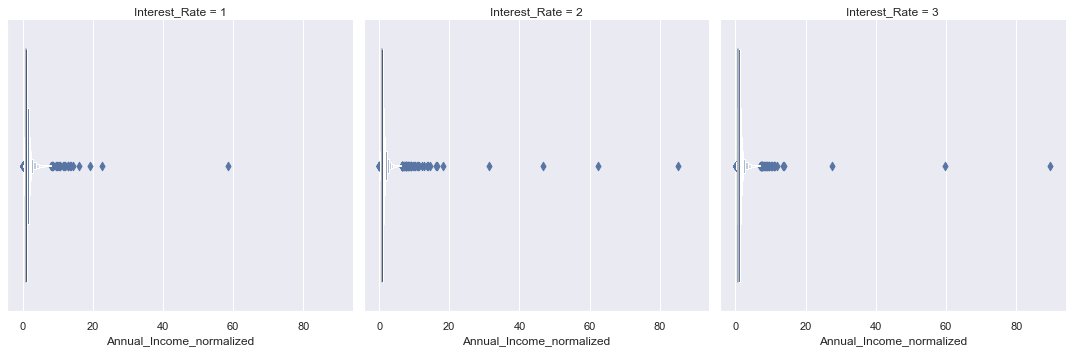

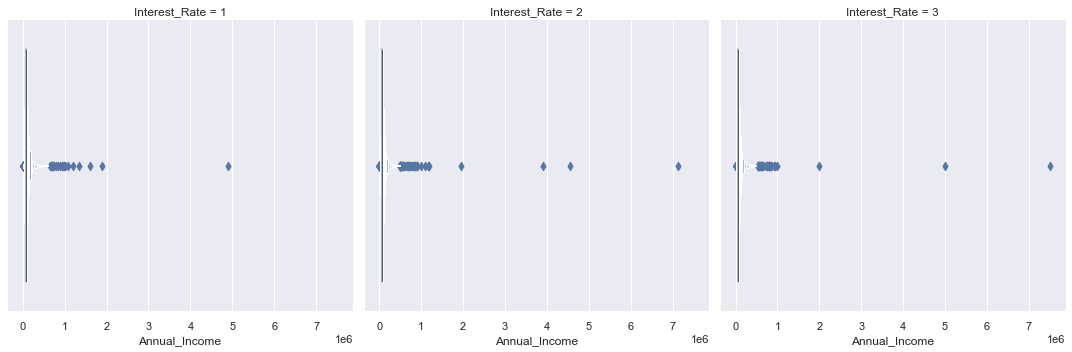





Mean_Debt_To_Income_by_Home_Owner by Interest_Rate


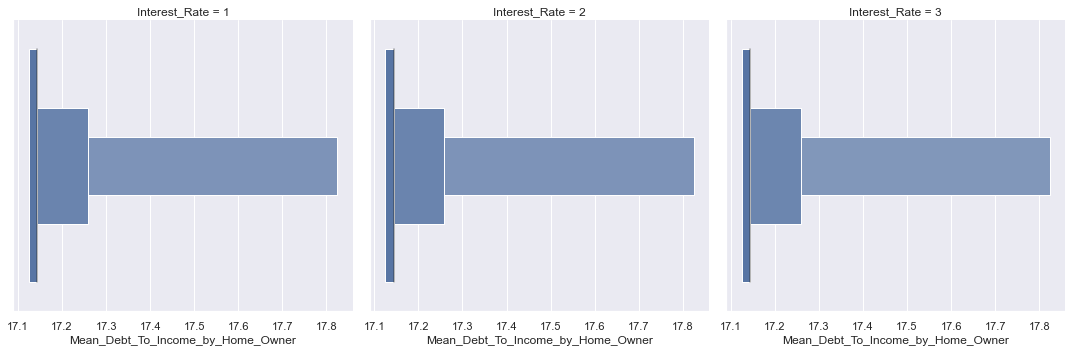



Mean_Debt_To_Income_by_Home_Owner
Home_Owner
Own         17.824458
missing     17.259172
Mortgage    17.144232
Rent        17.124675
Name: Debt_To_Income, dtype: float64


Quasi-normalized Mean_Debt_To_Income_by_Home_Owner


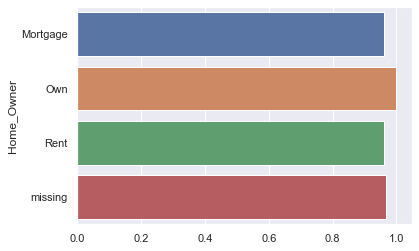



Comparison od normalized within categories and original Debt_To_Income


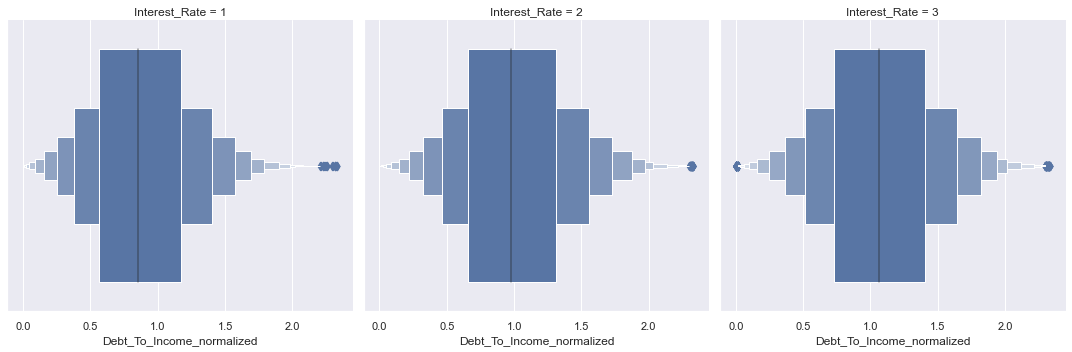

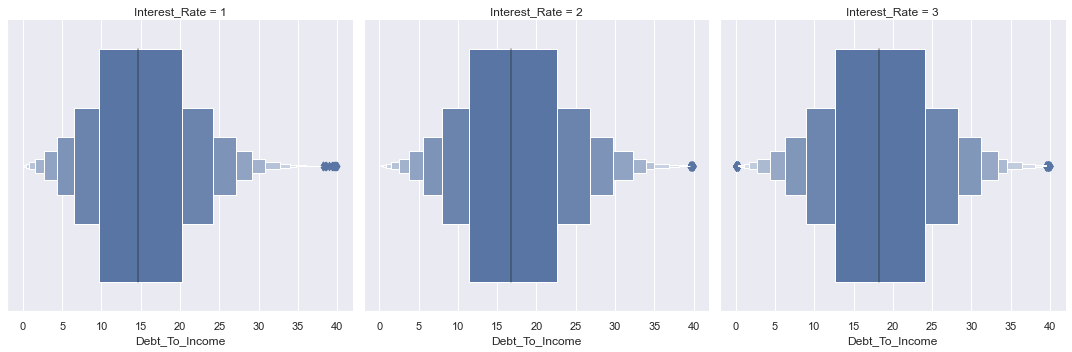





Mean_Inquiries_Last_6Mo_by_Home_Owner by Interest_Rate


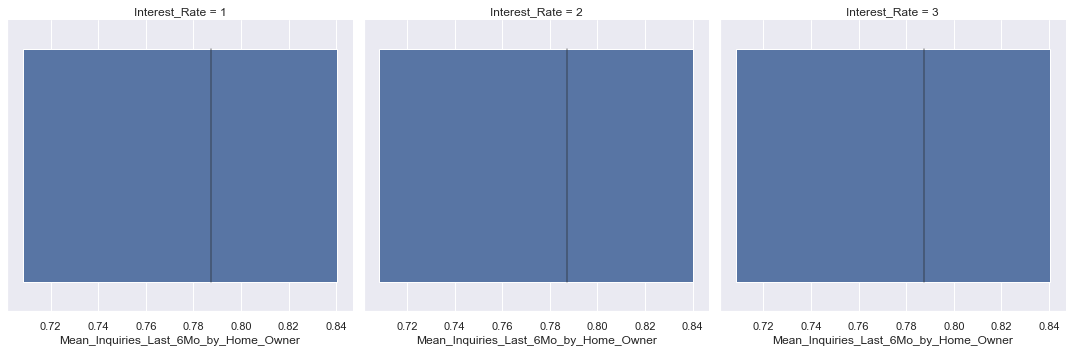



Mean_Inquiries_Last_6Mo_by_Home_Owner
Home_Owner
Mortgage    0.840387
missing     0.787390
Own         0.768782
Rent        0.708322
Name: Inquiries_Last_6Mo, dtype: float64


Quasi-normalized Mean_Inquiries_Last_6Mo_by_Home_Owner


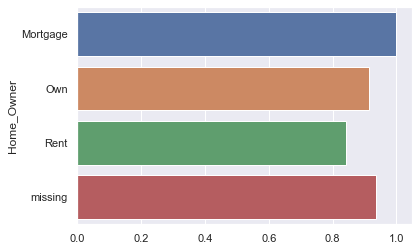



Comparison od normalized within categories and original Inquiries_Last_6Mo


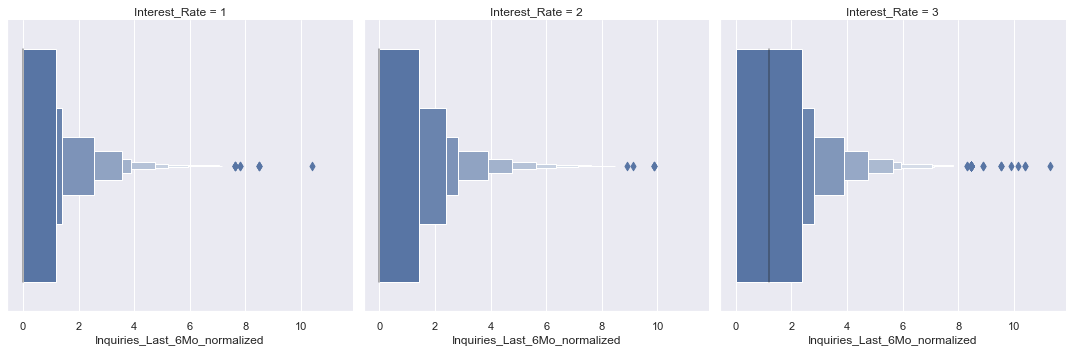

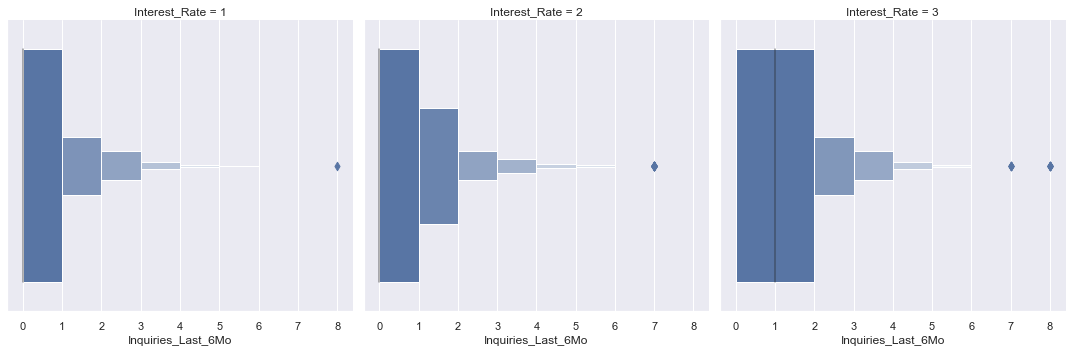





Mean_Months_Since_Deliquency_by_Home_Owner by Interest_Rate


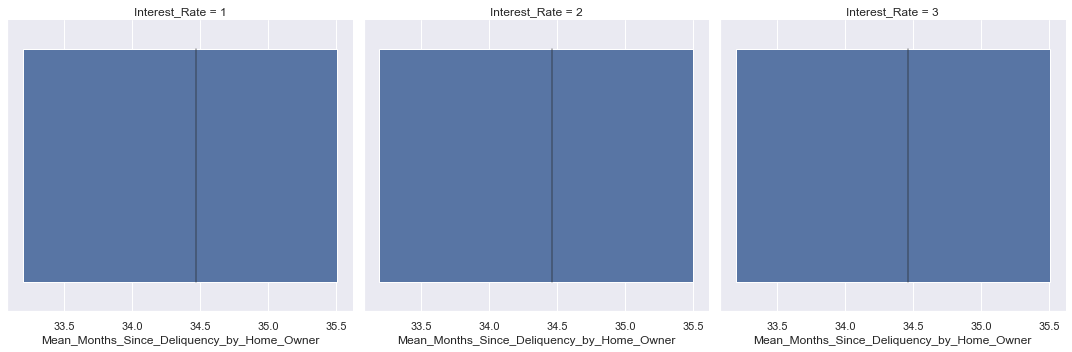



Mean_Months_Since_Deliquency_by_Home_Owner
Home_Owner
Rent        35.504430
Own         34.590130
missing     34.464602
Mortgage    33.195129
Name: Months_Since_Deliquency, dtype: float64


Quasi-normalized Mean_Months_Since_Deliquency_by_Home_Owner


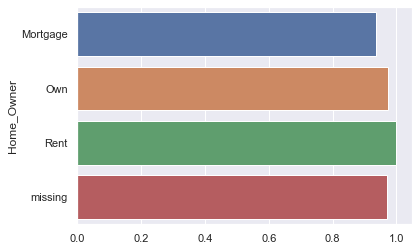



Comparison od normalized within categories and original Months_Since_Deliquency


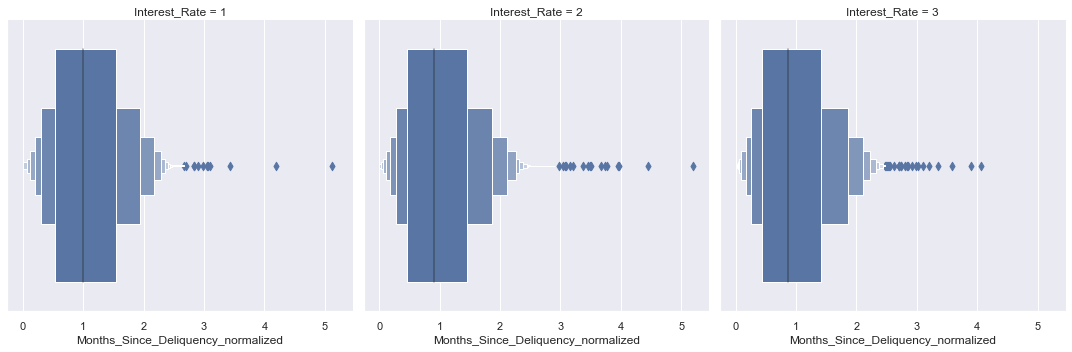

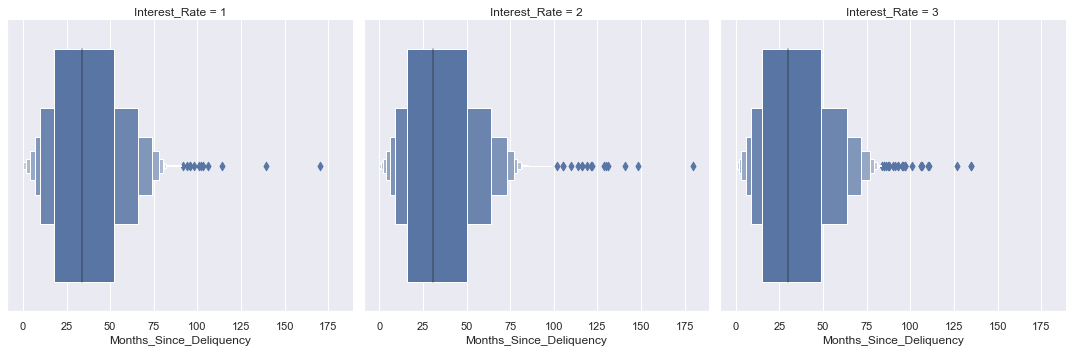





Mean_Number_Open_Accounts_by_Home_Owner by Interest_Rate


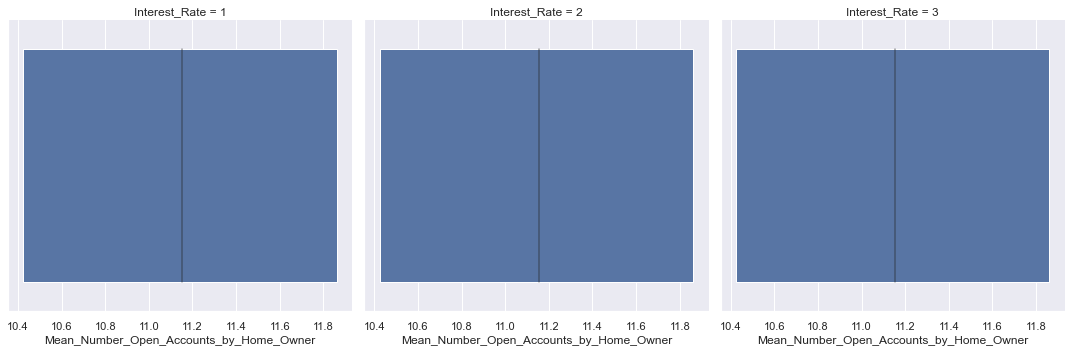



Mean_Number_Open_Accounts_by_Home_Owner
Home_Owner
Mortgage    11.860672
missing     11.154361
Own         10.967186
Rent        10.425158
Name: Number_Open_Accounts, dtype: float64


Quasi-normalized Mean_Number_Open_Accounts_by_Home_Owner


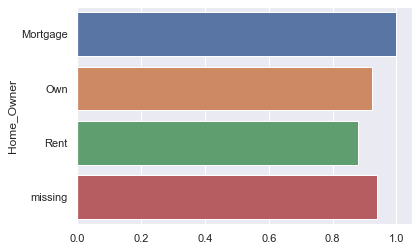



Comparison od normalized within categories and original Number_Open_Accounts


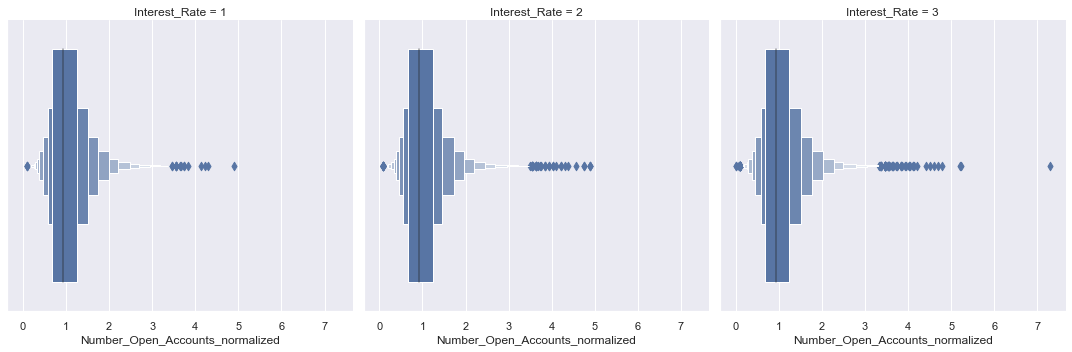

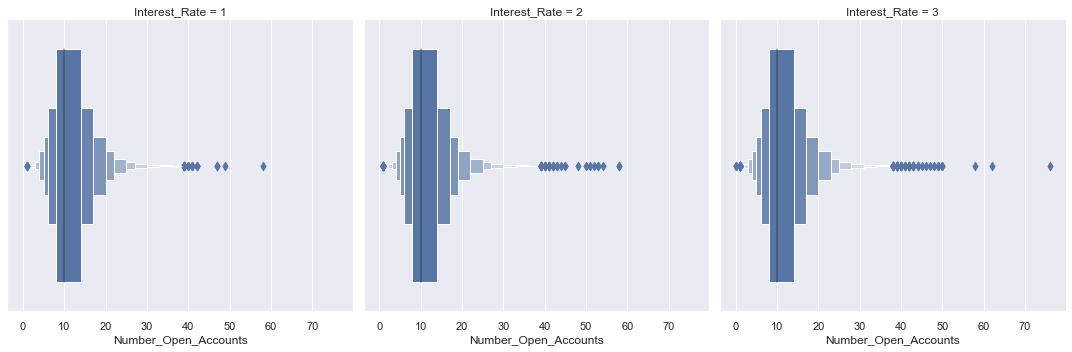





Mean_Total_Accounts_by_Home_Owner by Interest_Rate


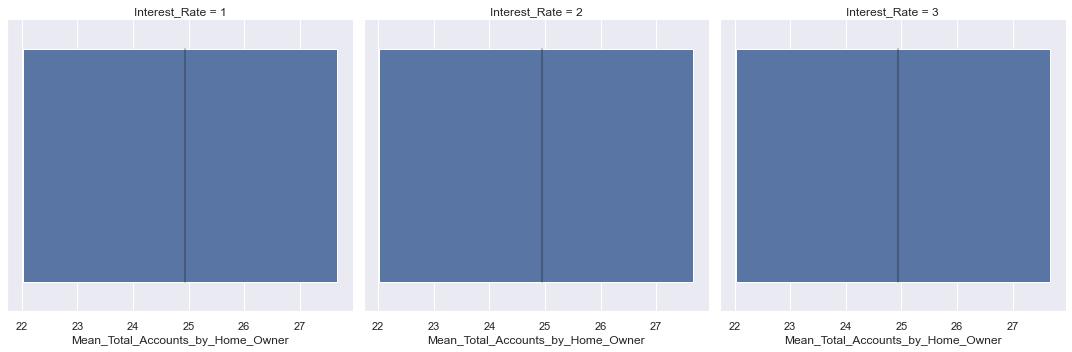



Mean_Total_Accounts_by_Home_Owner
Home_Owner
Mortgage    27.669188
missing     24.940412
Own         24.343792
Rent        22.021060
Name: Total_Accounts, dtype: float64


Quasi-normalized Mean_Total_Accounts_by_Home_Owner


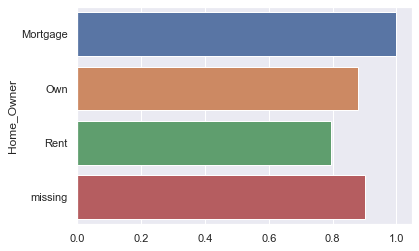



Comparison od normalized within categories and original Total_Accounts


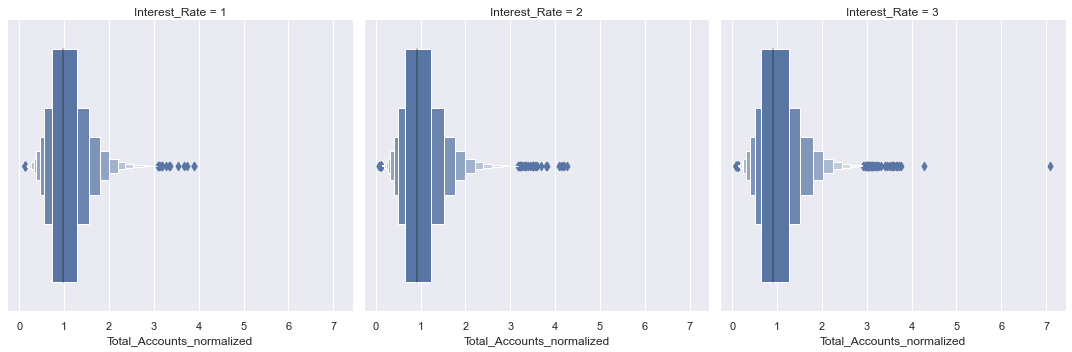

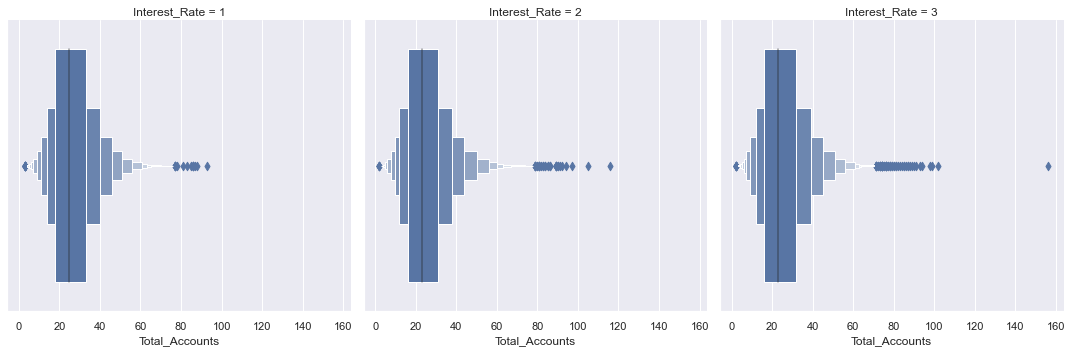





Mean_Open_To_All_Accounts_by_Home_Owner by Interest_Rate


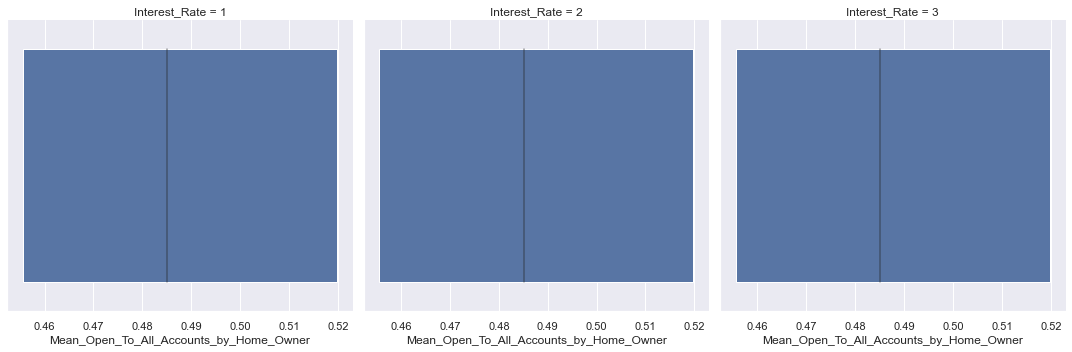



Mean_Open_To_All_Accounts_by_Home_Owner
Home_Owner
Rent        0.519823
Own         0.490889
missing     0.485107
Mortgage    0.455567
Name: Open_To_All_Accounts, dtype: float64


Quasi-normalized Mean_Open_To_All_Accounts_by_Home_Owner


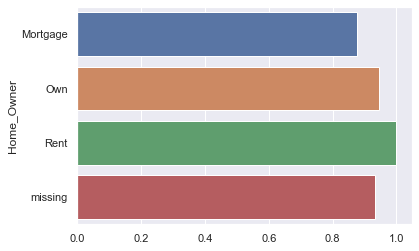



Comparison od normalized within categories and original Open_To_All_Accounts


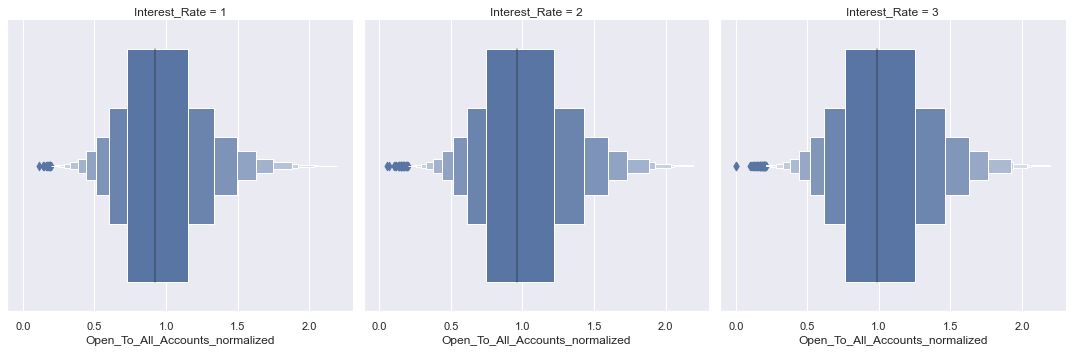

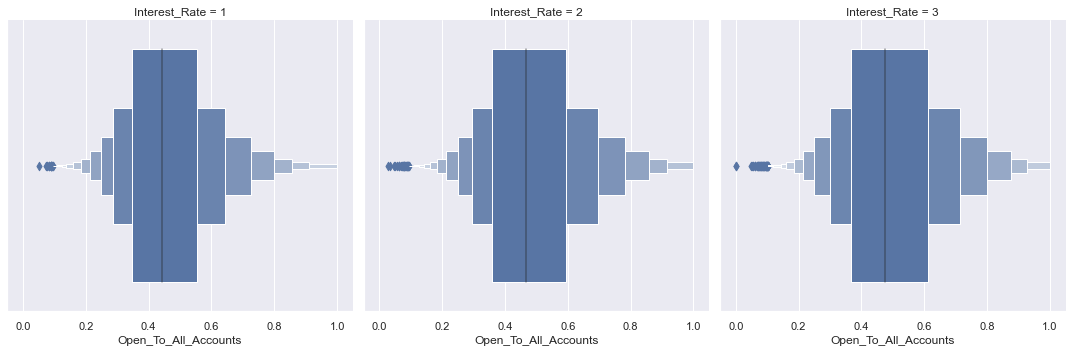





Mean_Loan_To_Income_by_Home_Owner by Interest_Rate


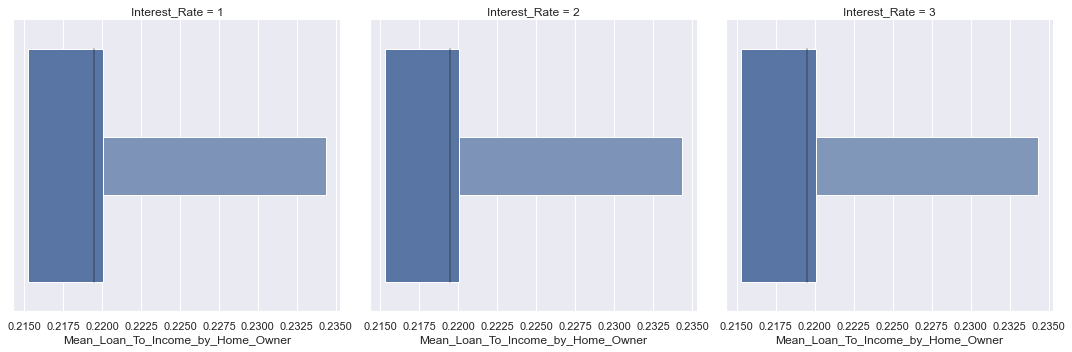



Mean_Loan_To_Income_by_Home_Owner
Home_Owner
Own         0.234341
Rent        0.220051
missing     0.219473
Mortgage    0.215259
Name: Loan_To_Income, dtype: float64


Quasi-normalized Mean_Loan_To_Income_by_Home_Owner


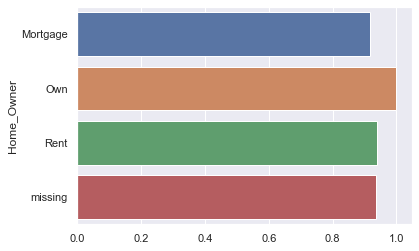



Comparison od normalized within categories and original Loan_To_Income


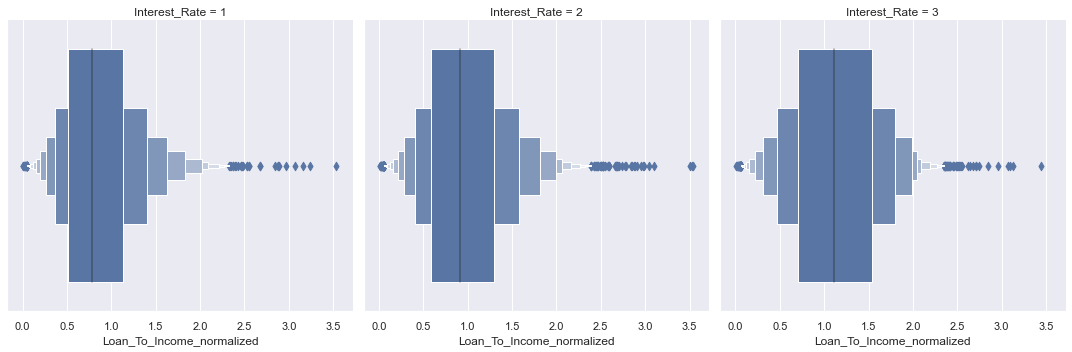

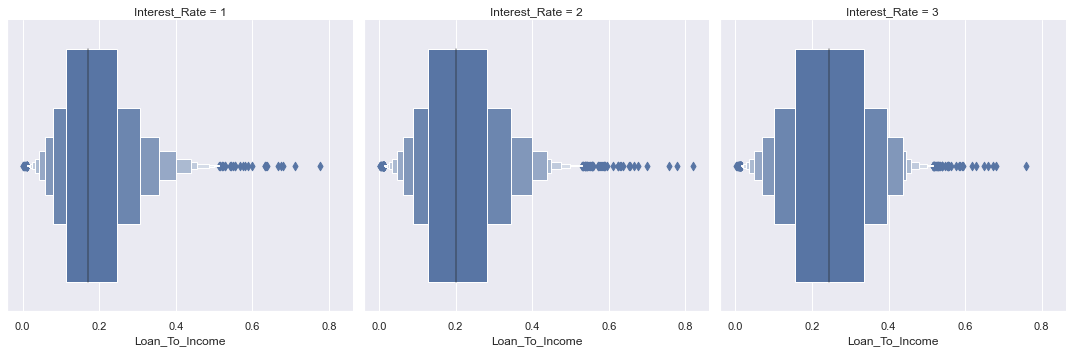





Mean_Debt_To_Loan_by_Home_Owner by Interest_Rate


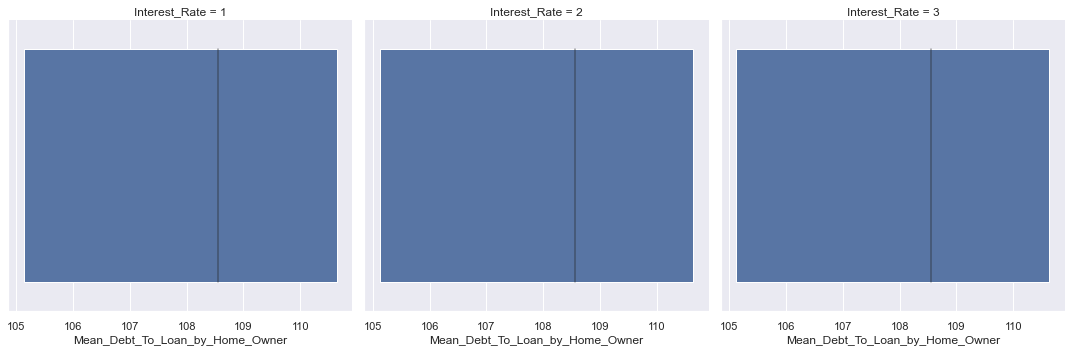



Mean_Debt_To_Loan_by_Home_Owner
Home_Owner
Mortgage    110.640947
missing     108.558917
Own         105.150502
Rent        105.127025
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Home_Owner


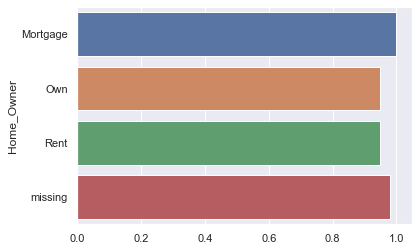



Comparison od normalized within categories and original Debt_To_Loan


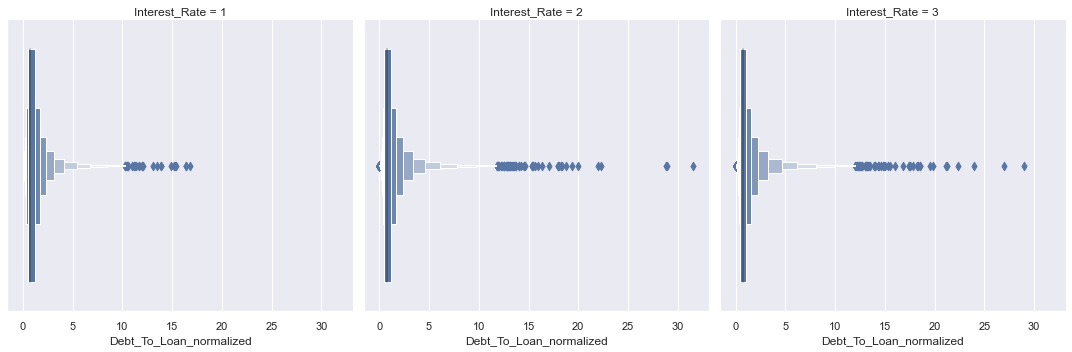

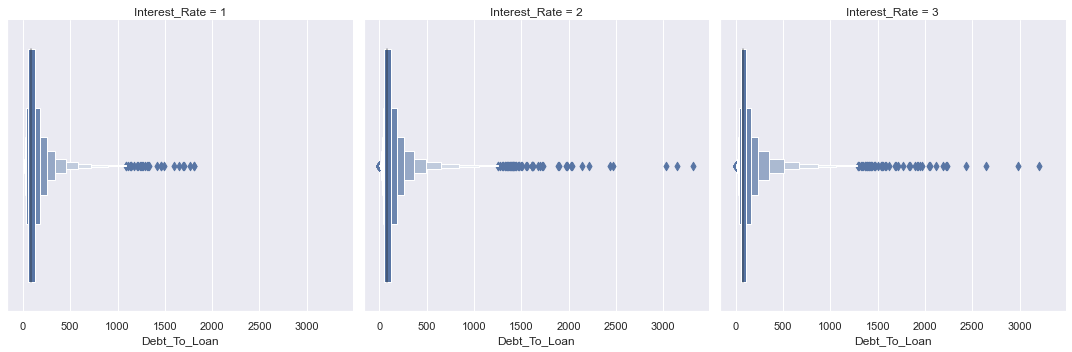





Mean_Num_Length_Employed_by_Home_Owner by Interest_Rate


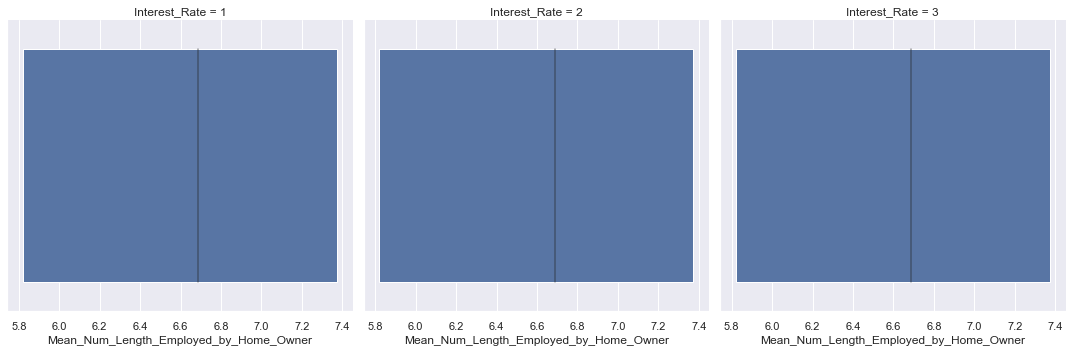



Mean_Num_Length_Employed_by_Home_Owner
Home_Owner
Mortgage    7.373943
missing     6.687657
Own         6.607106
Rent        5.820082
Name: Num_Length_Employed, dtype: float64


Quasi-normalized Mean_Num_Length_Employed_by_Home_Owner


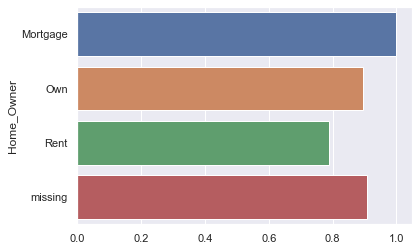



Comparison od normalized within categories and original Num_Length_Employed


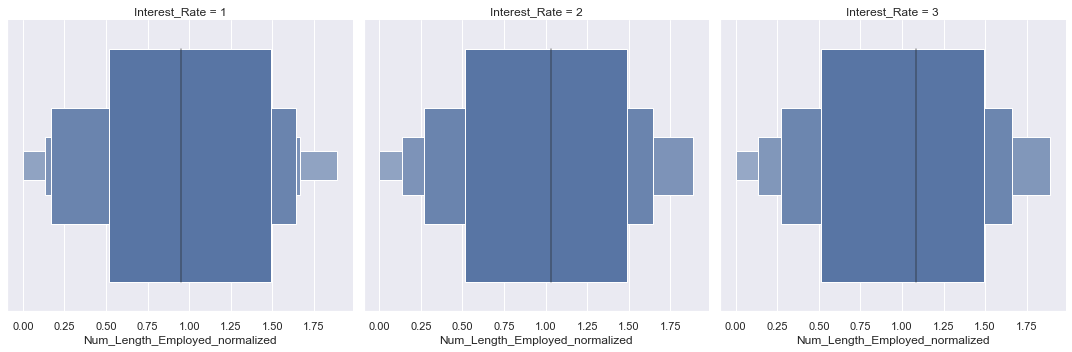

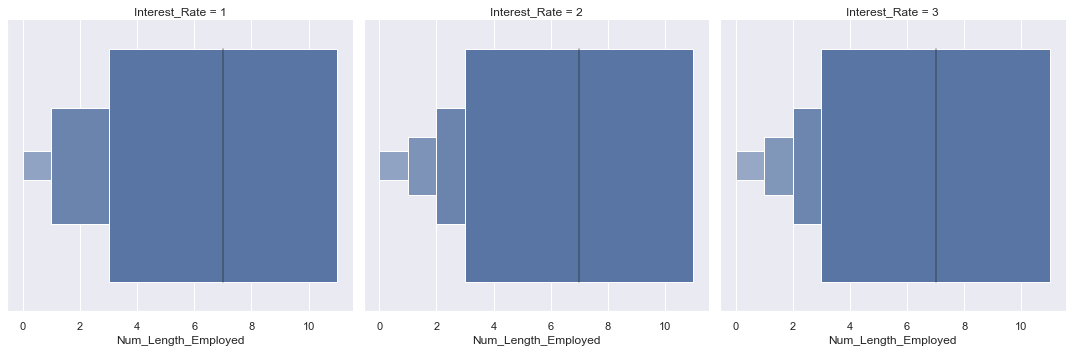





Mean_Loan_Amount_Requested_by_Income_Verified by Interest_Rate


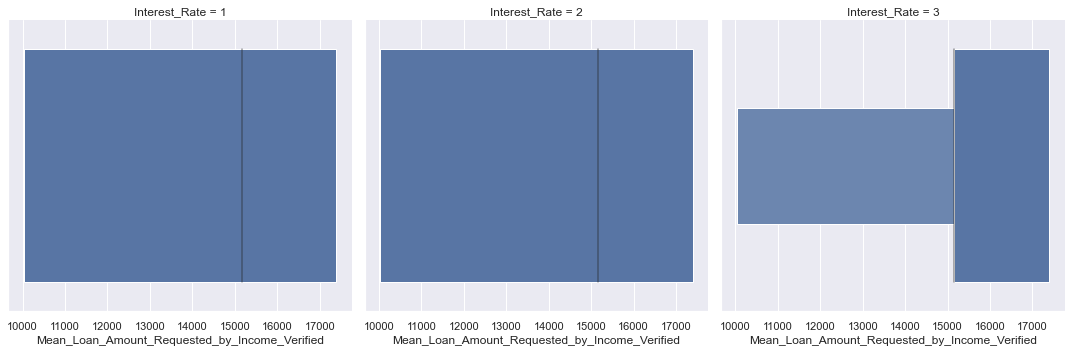



Mean_Loan_Amount_Requested_by_Income_Verified
Income_Verified
VERIFIED - income           17394.137174
VERIFIED - income source    15159.008771
not verified                10033.993118
Name: Loan_Amount_Requested, dtype: float64


Quasi-normalized Mean_Loan_Amount_Requested_by_Income_Verified


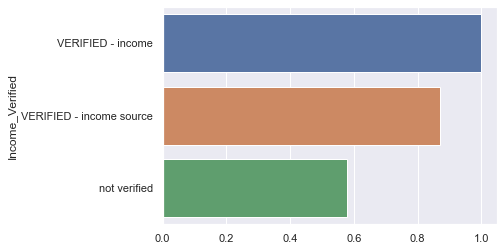



Comparison od normalized within categories and original Loan_Amount_Requested


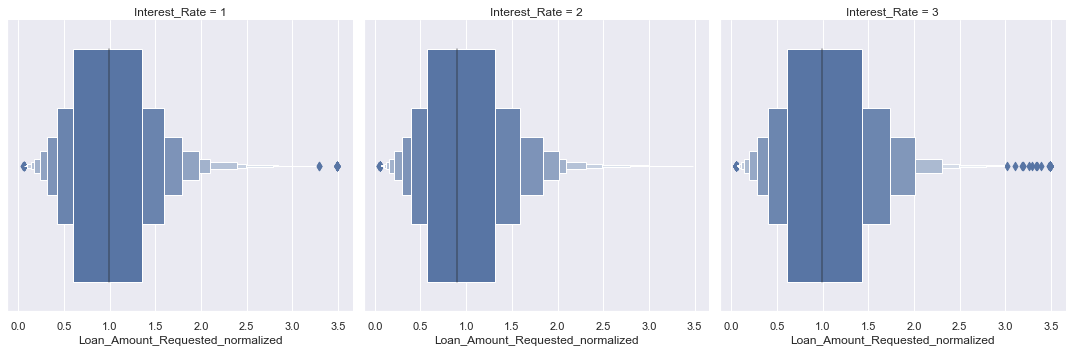

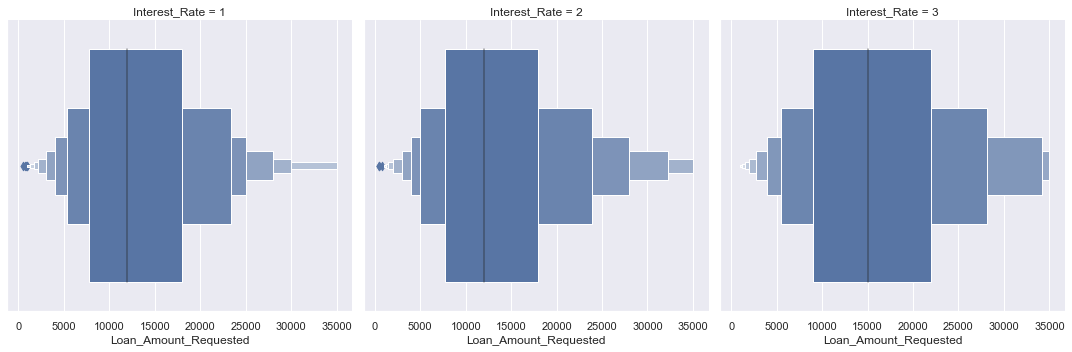





Mean_Annual_Income_by_Income_Verified by Interest_Rate


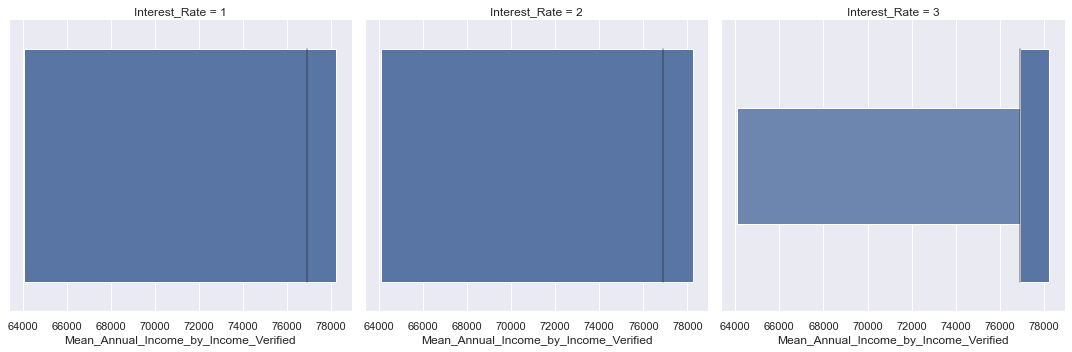



Mean_Annual_Income_by_Income_Verified
Income_Verified
VERIFIED - income           78244.981167
VERIFIED - income source    76904.150447
not verified                64074.292218
Name: Annual_Income, dtype: float64


Quasi-normalized Mean_Annual_Income_by_Income_Verified


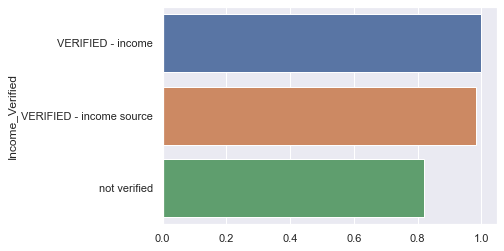



Comparison od normalized within categories and original Annual_Income


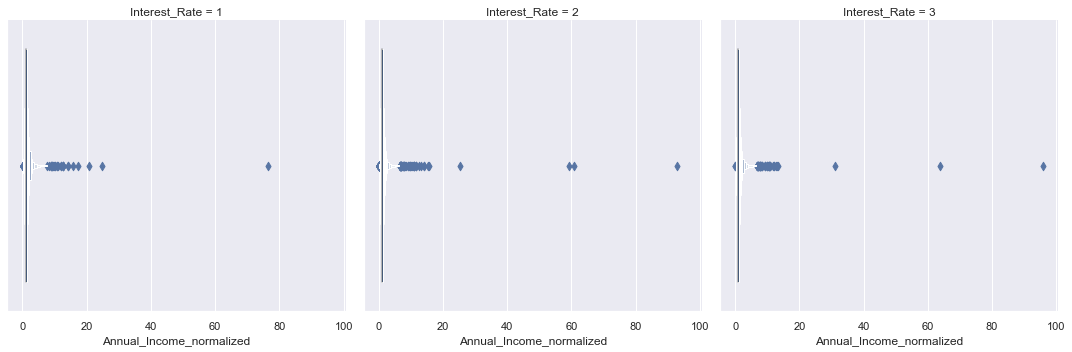

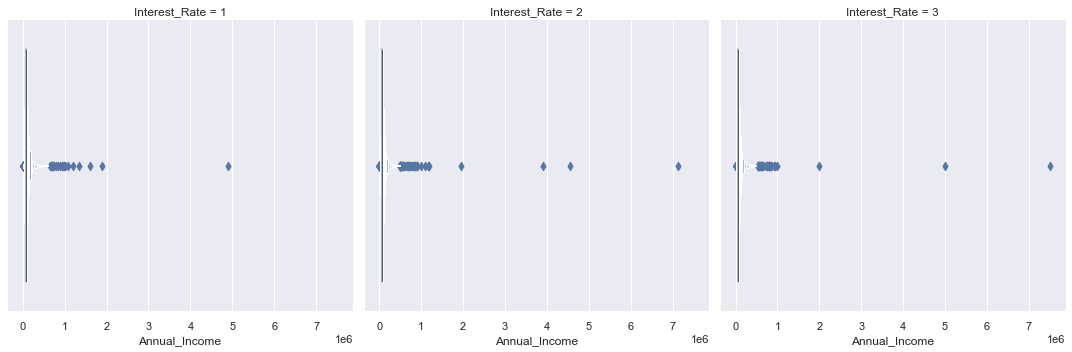





Mean_Debt_To_Income_by_Income_Verified by Interest_Rate


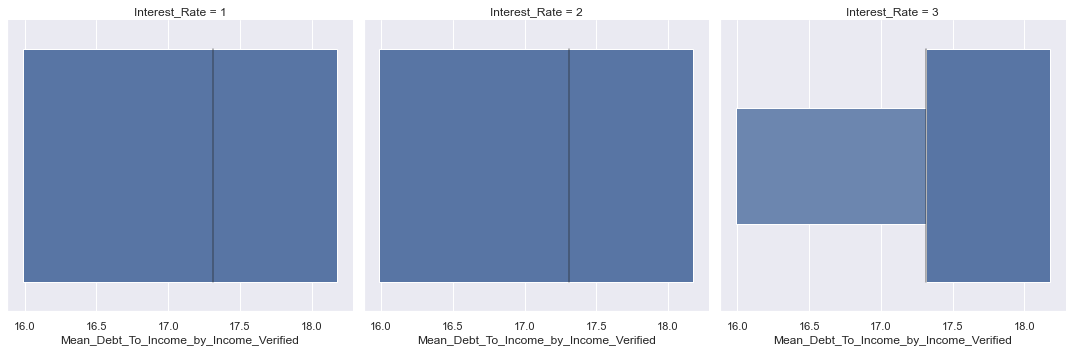



Mean_Debt_To_Income_by_Income_Verified
Income_Verified
VERIFIED - income           18.177357
VERIFIED - income source    17.312871
not verified                15.987844
Name: Debt_To_Income, dtype: float64


Quasi-normalized Mean_Debt_To_Income_by_Income_Verified


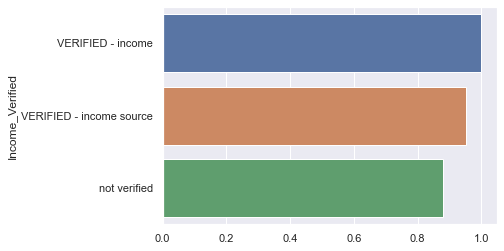



Comparison od normalized within categories and original Debt_To_Income


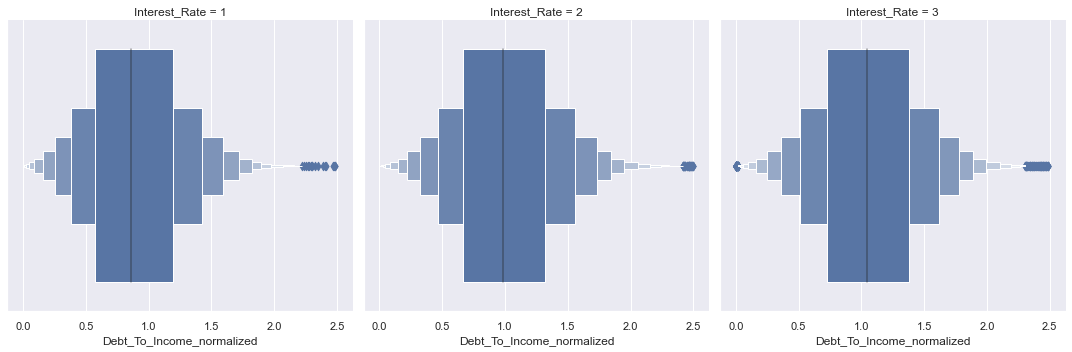

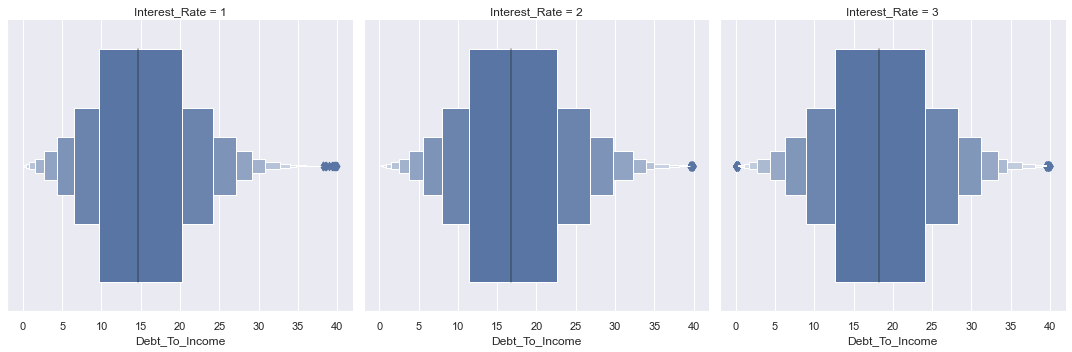





Mean_Inquiries_Last_6Mo_by_Income_Verified by Interest_Rate


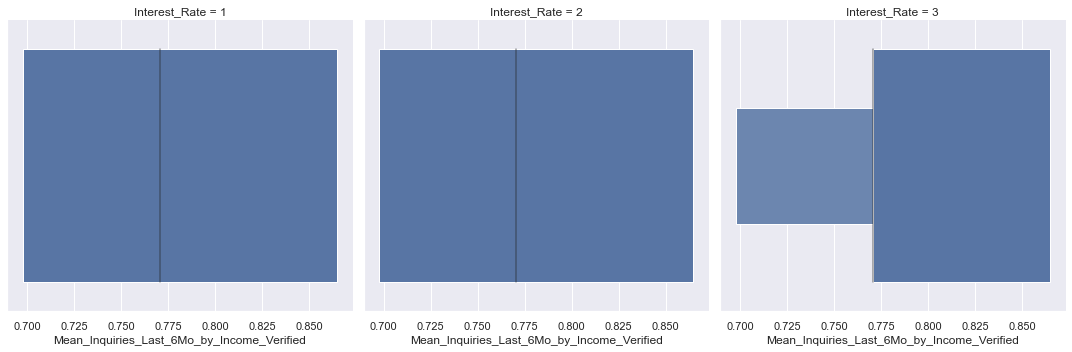



Mean_Inquiries_Last_6Mo_by_Income_Verified
Income_Verified
VERIFIED - income           0.864846
VERIFIED - income source    0.770631
not verified                0.697762
Name: Inquiries_Last_6Mo, dtype: float64


Quasi-normalized Mean_Inquiries_Last_6Mo_by_Income_Verified


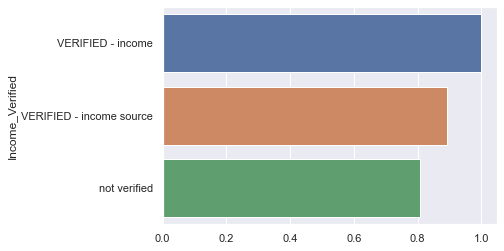



Comparison od normalized within categories and original Inquiries_Last_6Mo


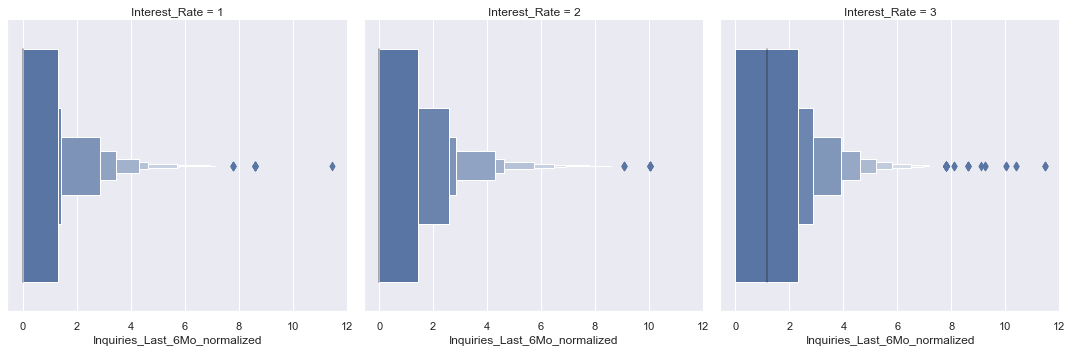

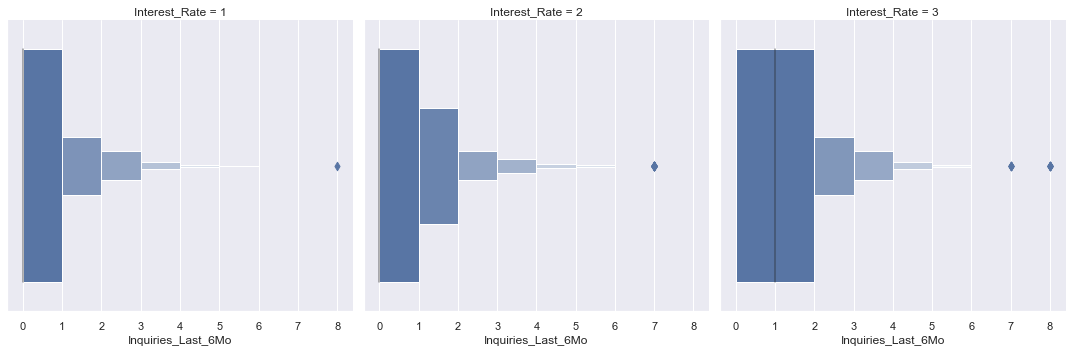





Mean_Months_Since_Deliquency_by_Income_Verified by Interest_Rate


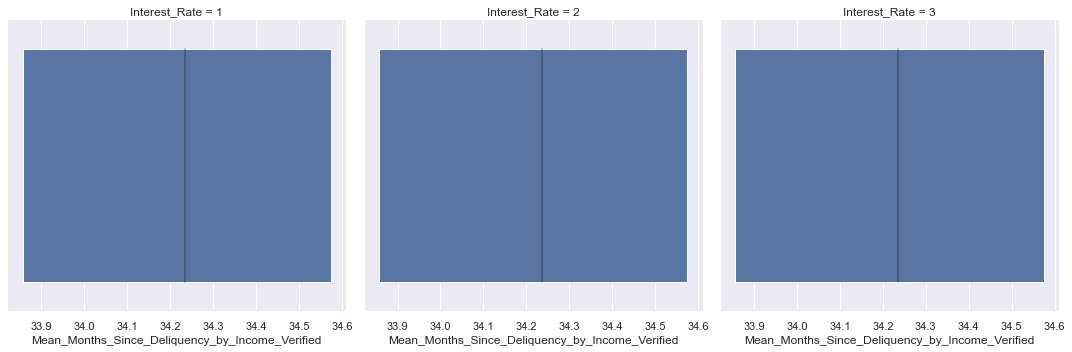



Mean_Months_Since_Deliquency_by_Income_Verified
Income_Verified
VERIFIED - income           34.574467
not verified                34.235980
VERIFIED - income source    33.856958
Name: Months_Since_Deliquency, dtype: float64


Quasi-normalized Mean_Months_Since_Deliquency_by_Income_Verified


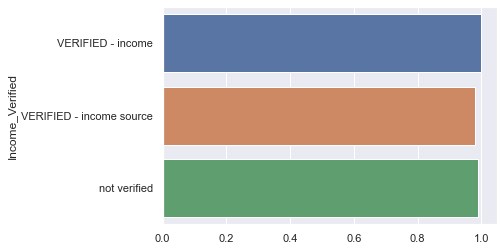



Comparison od normalized within categories and original Months_Since_Deliquency


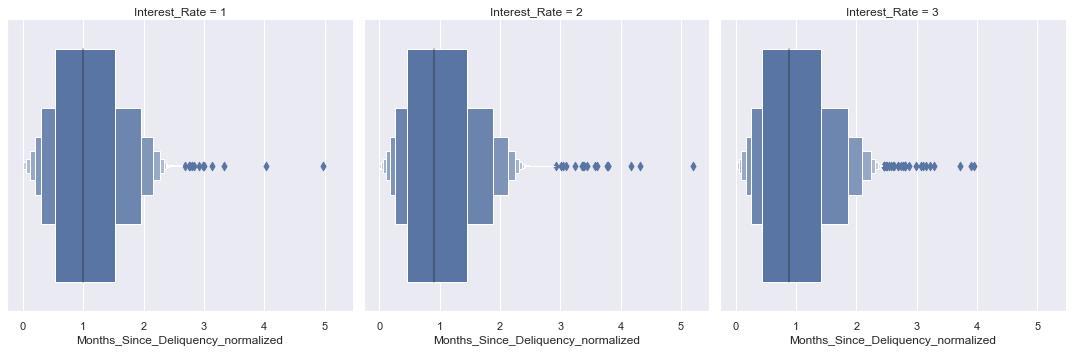

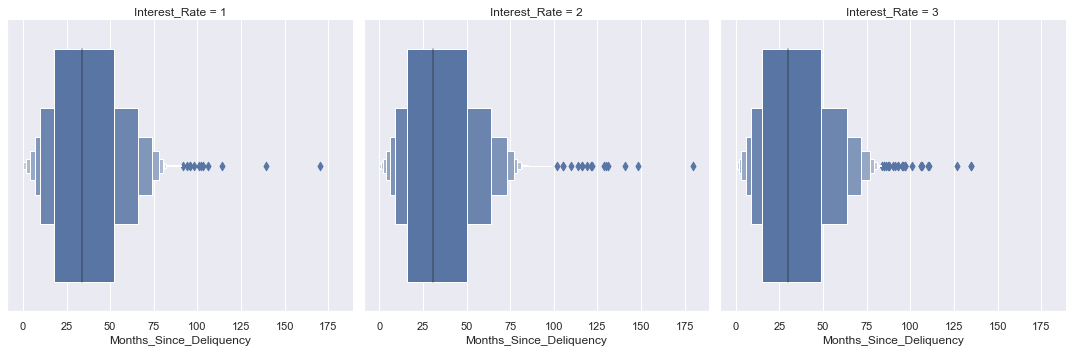





Mean_Number_Open_Accounts_by_Income_Verified by Interest_Rate


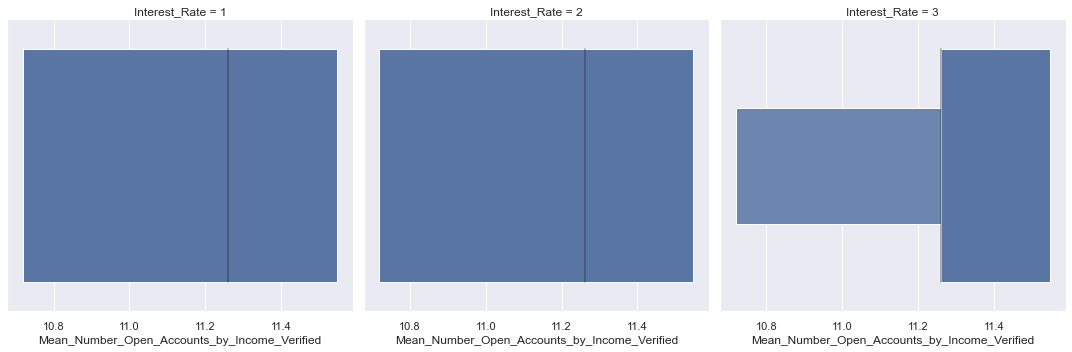



Mean_Number_Open_Accounts_by_Income_Verified
Income_Verified
VERIFIED - income           11.548308
VERIFIED - income source    11.261002
not verified                10.719083
Name: Number_Open_Accounts, dtype: float64


Quasi-normalized Mean_Number_Open_Accounts_by_Income_Verified


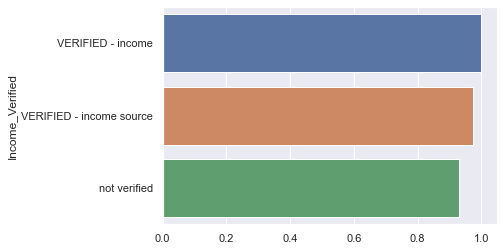



Comparison od normalized within categories and original Number_Open_Accounts


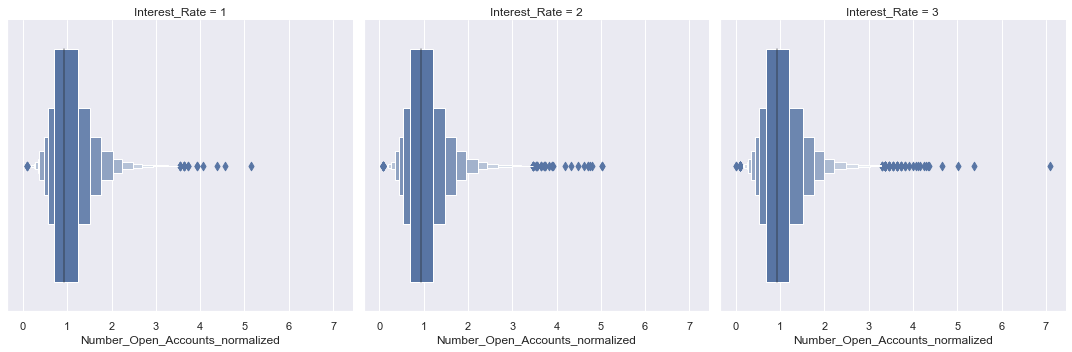

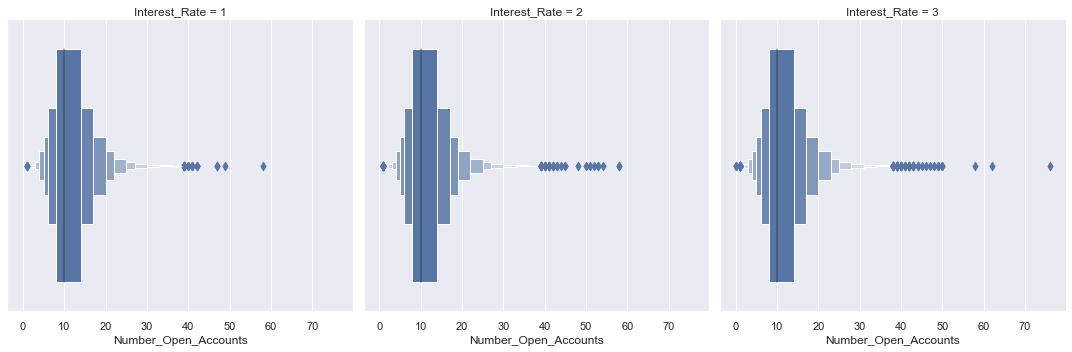





Mean_Total_Accounts_by_Income_Verified by Interest_Rate


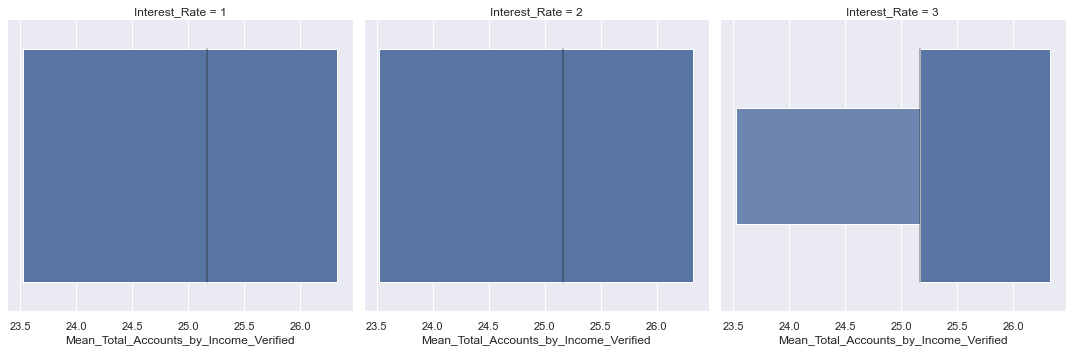



Mean_Total_Accounts_by_Income_Verified
Income_Verified
VERIFIED - income           26.327309
VERIFIED - income source    25.166443
not verified                23.523779
Name: Total_Accounts, dtype: float64


Quasi-normalized Mean_Total_Accounts_by_Income_Verified


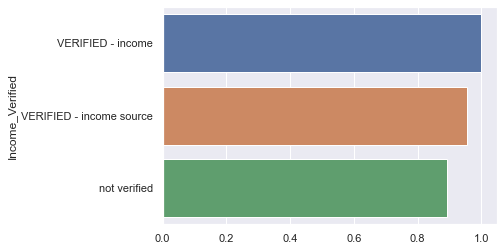



Comparison od normalized within categories and original Total_Accounts


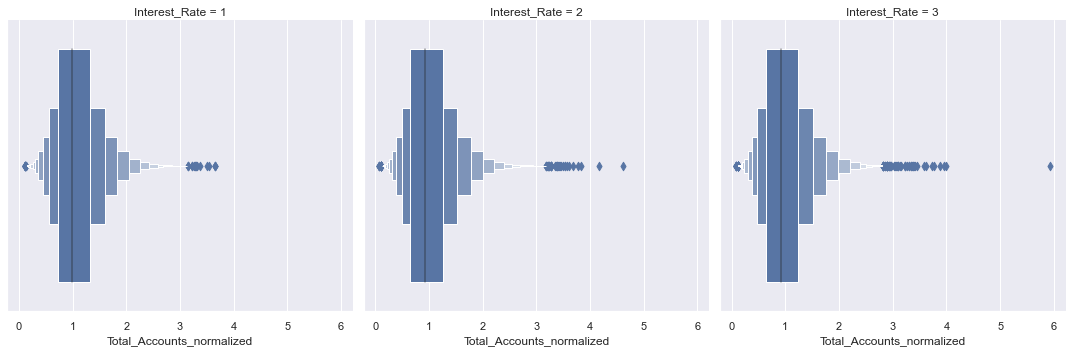

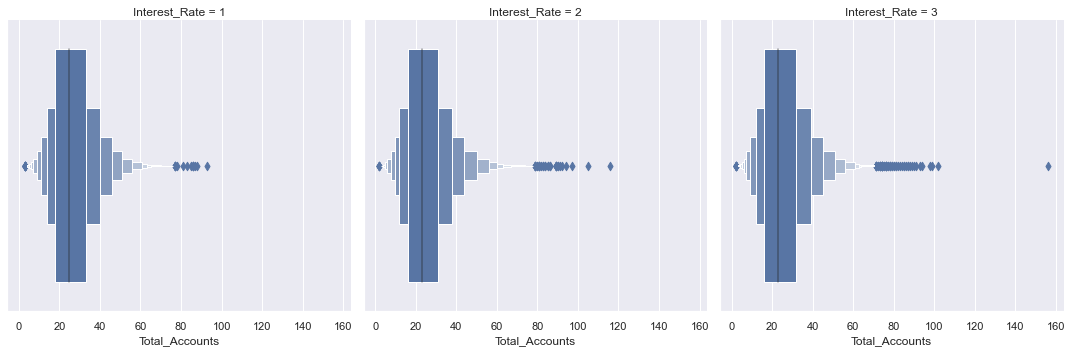





Mean_Open_To_All_Accounts_by_Income_Verified by Interest_Rate


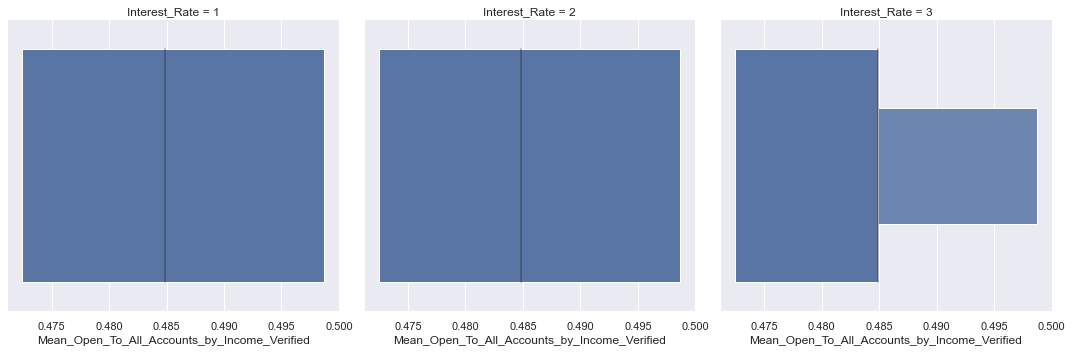



Mean_Open_To_All_Accounts_by_Income_Verified
Income_Verified
not verified                0.498689
VERIFIED - income source    0.484855
VERIFIED - income           0.472458
Name: Open_To_All_Accounts, dtype: float64


Quasi-normalized Mean_Open_To_All_Accounts_by_Income_Verified


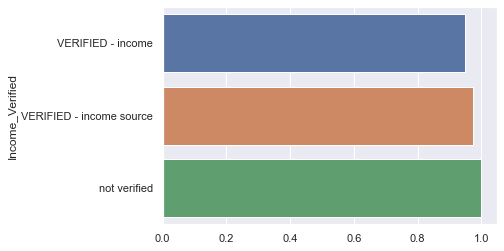



Comparison od normalized within categories and original Open_To_All_Accounts


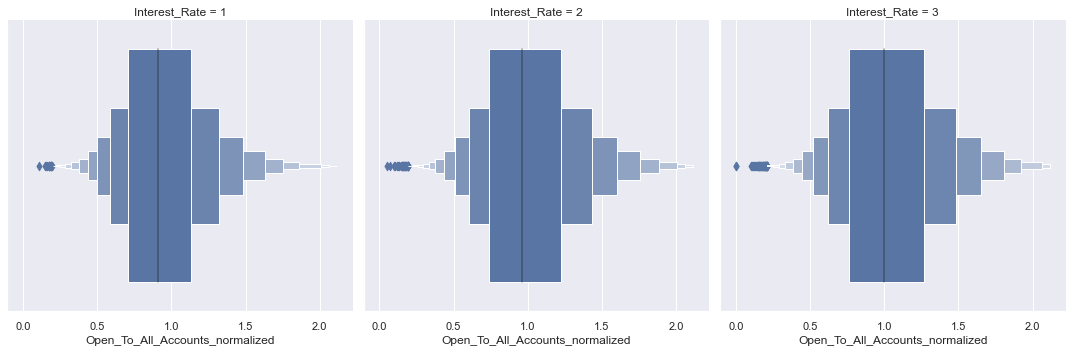

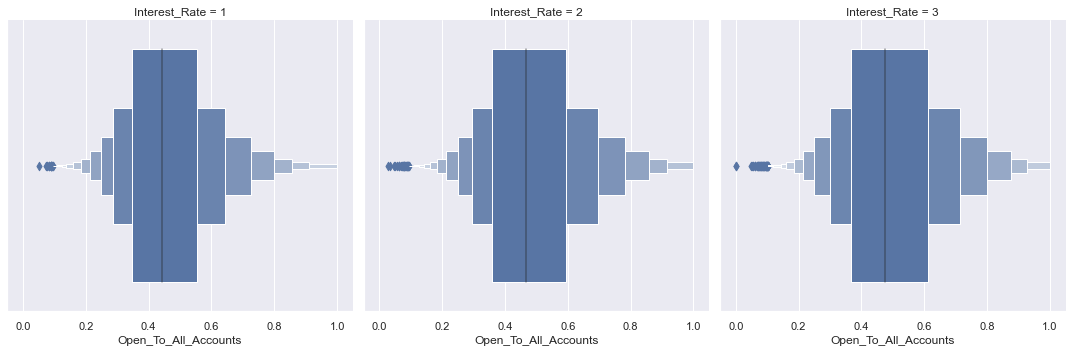





Mean_Loan_To_Income_by_Income_Verified by Interest_Rate


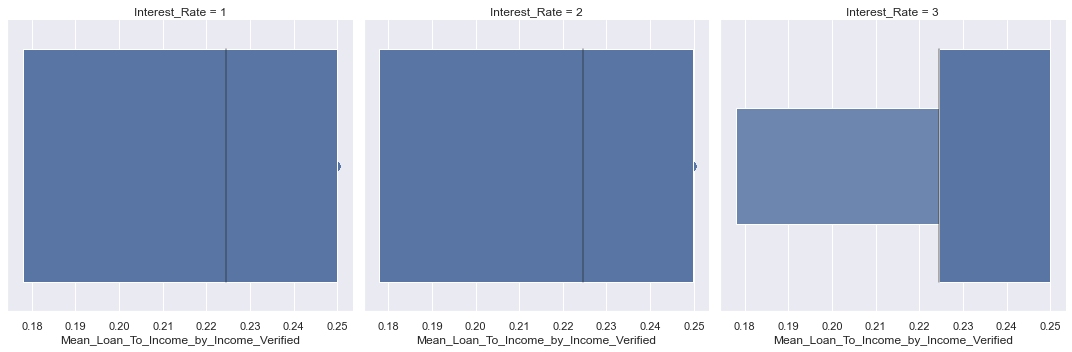



Mean_Loan_To_Income_by_Income_Verified
Income_Verified
VERIFIED - income           0.249933
VERIFIED - income source    0.224584
not verified                0.177957
Name: Loan_To_Income, dtype: float64


Quasi-normalized Mean_Loan_To_Income_by_Income_Verified


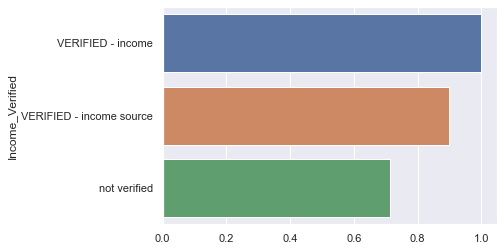



Comparison od normalized within categories and original Loan_To_Income


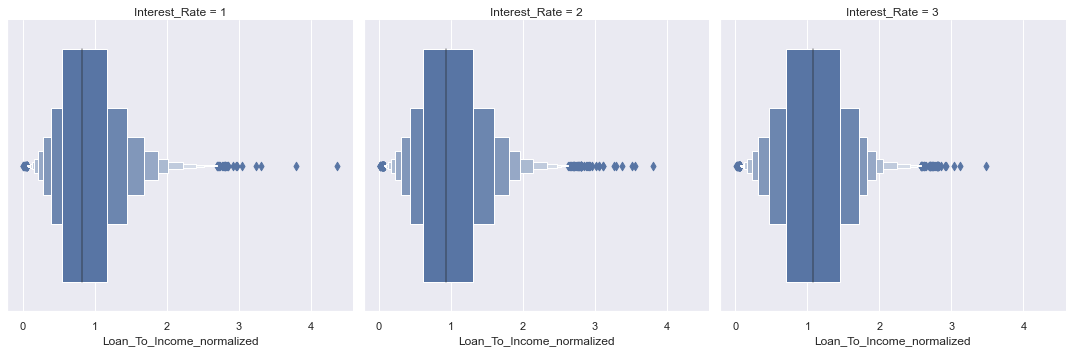

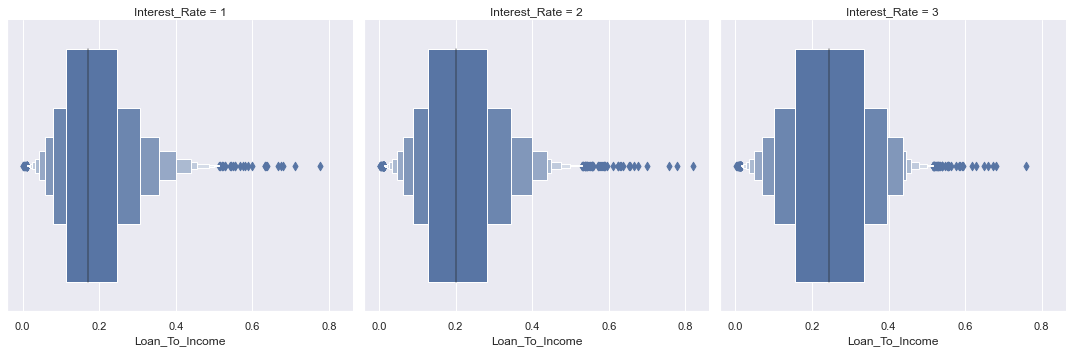





Mean_Debt_To_Loan_by_Income_Verified by Interest_Rate


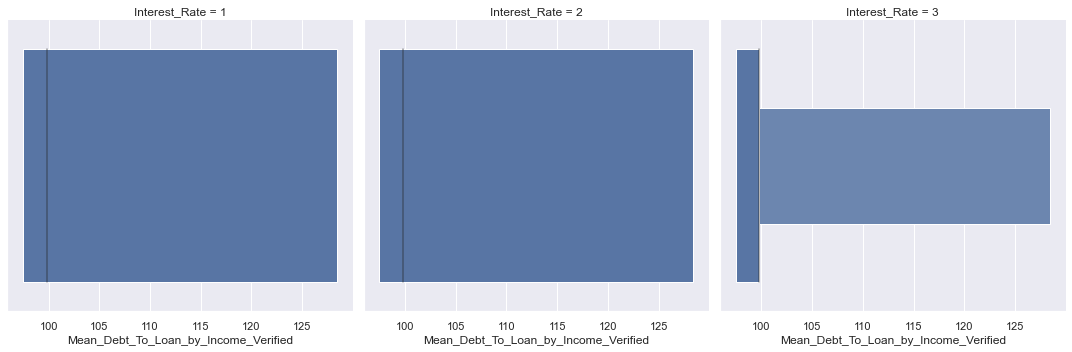



Mean_Debt_To_Loan_by_Income_Verified
Income_Verified
not verified                128.437011
VERIFIED - income source     99.810111
VERIFIED - income            97.470794
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Income_Verified


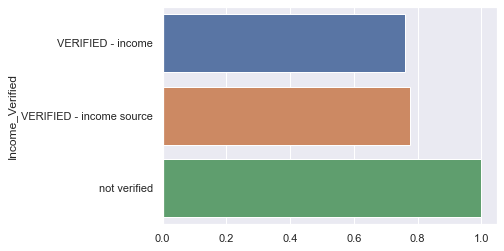



Comparison od normalized within categories and original Debt_To_Loan


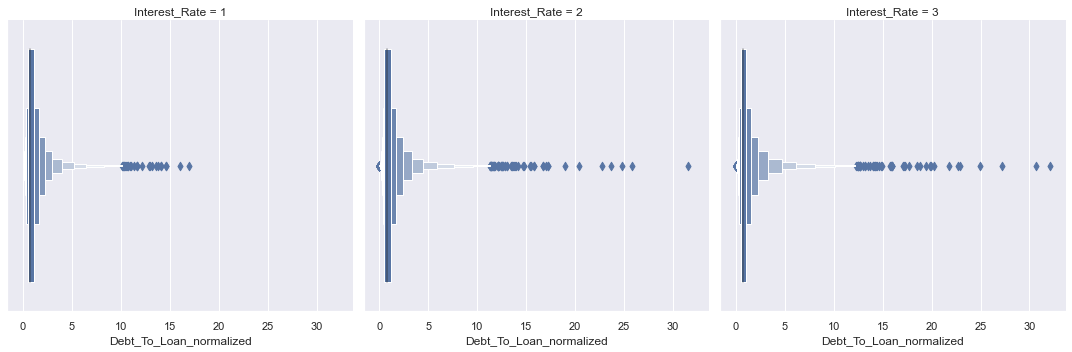

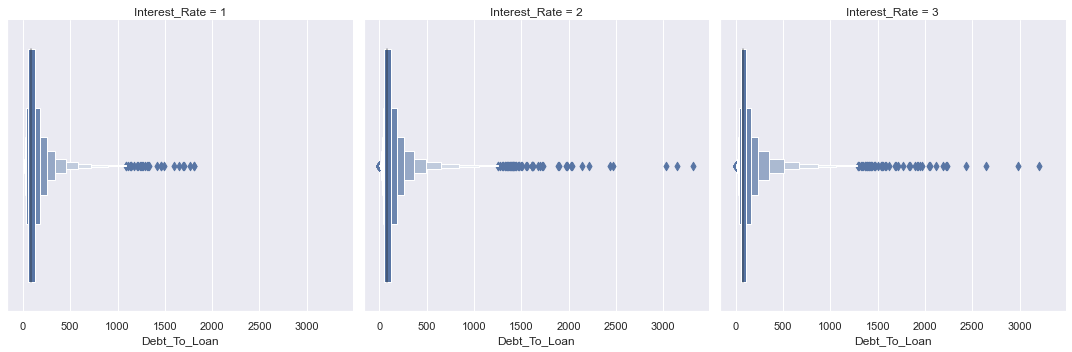





Mean_Num_Length_Employed_by_Income_Verified by Interest_Rate


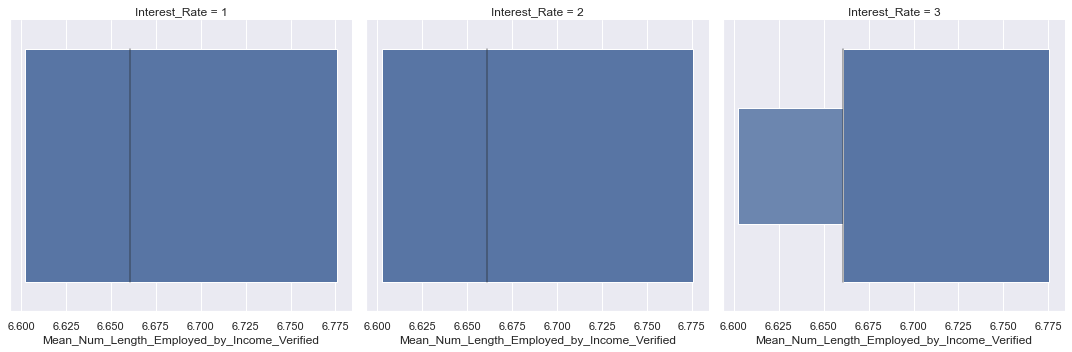



Mean_Num_Length_Employed_by_Income_Verified
Income_Verified
VERIFIED - income source    6.775648
VERIFIED - income           6.660911
not verified                6.602471
Name: Num_Length_Employed, dtype: float64


Quasi-normalized Mean_Num_Length_Employed_by_Income_Verified


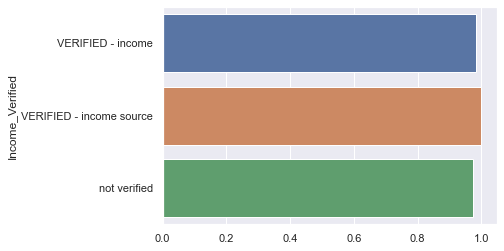



Comparison od normalized within categories and original Num_Length_Employed


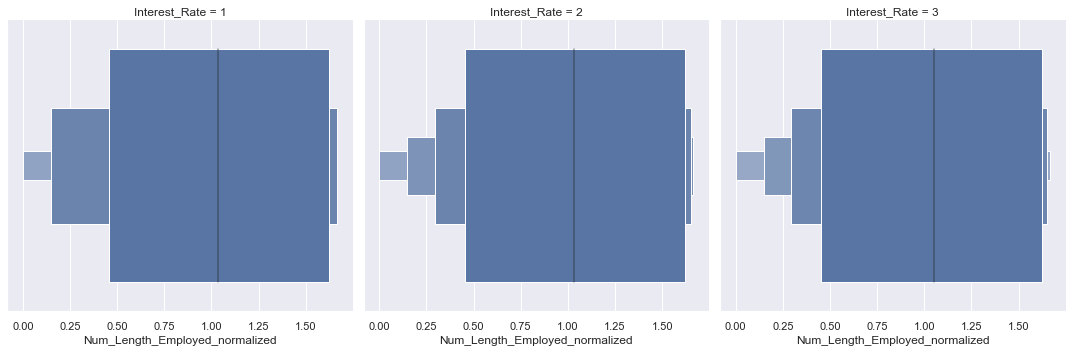

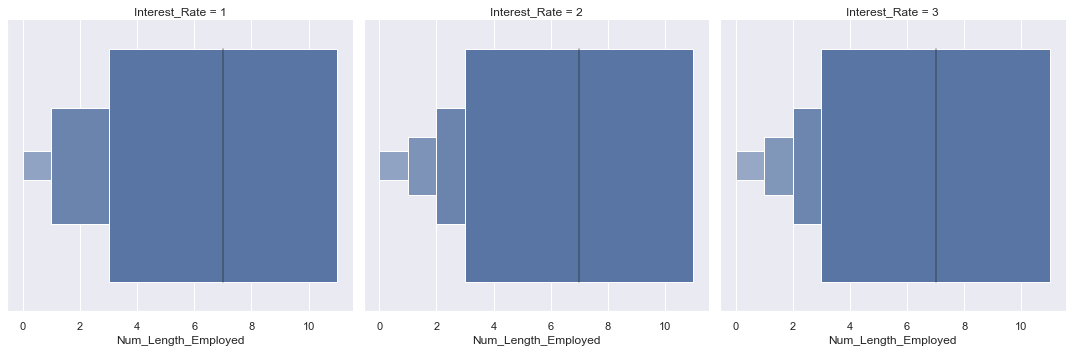





Mean_Loan_Amount_Requested_by_Purpose_Of_Loan by Interest_Rate


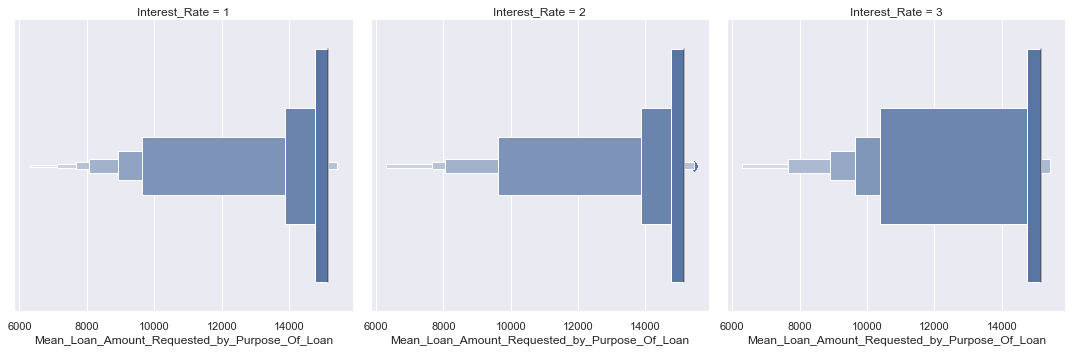



Mean_Loan_Amount_Requested_by_Purpose_Of_Loan
Purpose_Of_Loan
small_business        15427.456104
debt_consolidation    15148.553568
house                 15042.205692
credit_card           14754.313870
home_improvement      13867.466825
renewable_energy      10958.130081
major_purchase        10394.657933
wedding               10239.402174
other                  9635.493051
medical                8913.854640
car                    8053.806366
moving                 7668.814168
educational            7110.123967
vacation               6300.627240
Name: Loan_Amount_Requested, dtype: float64


Quasi-normalized Mean_Loan_Amount_Requested_by_Purpose_Of_Loan


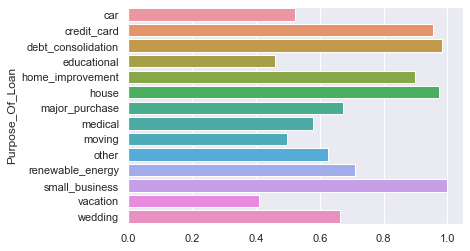



Comparison od normalized within categories and original Loan_Amount_Requested


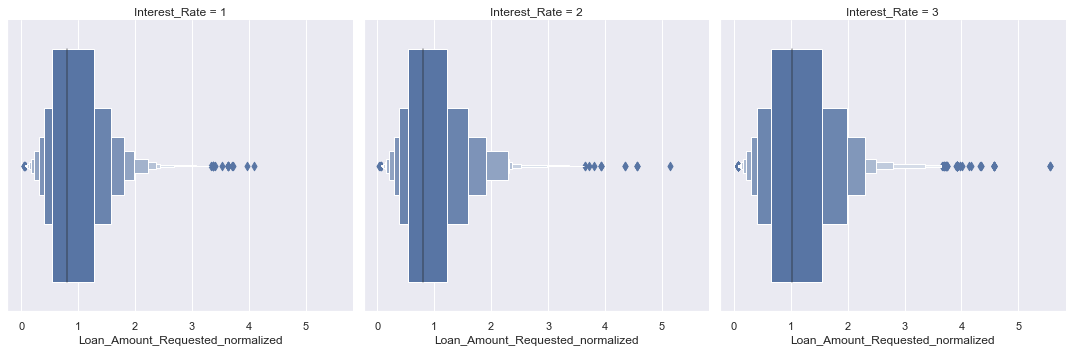

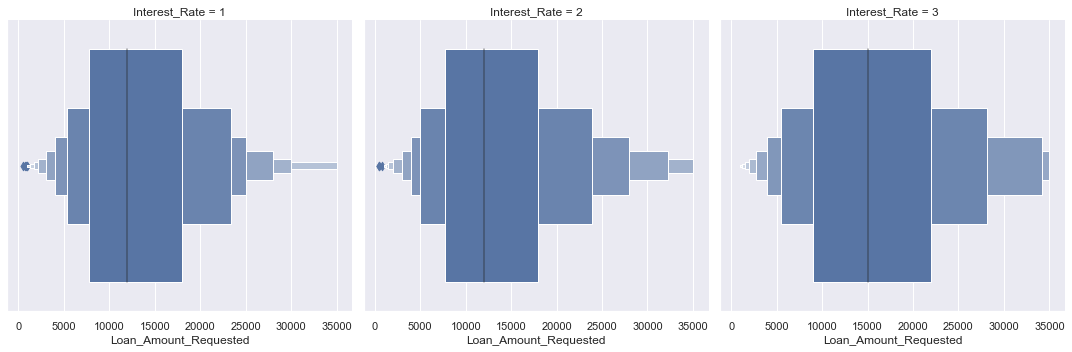





Mean_Annual_Income_by_Purpose_Of_Loan by Interest_Rate


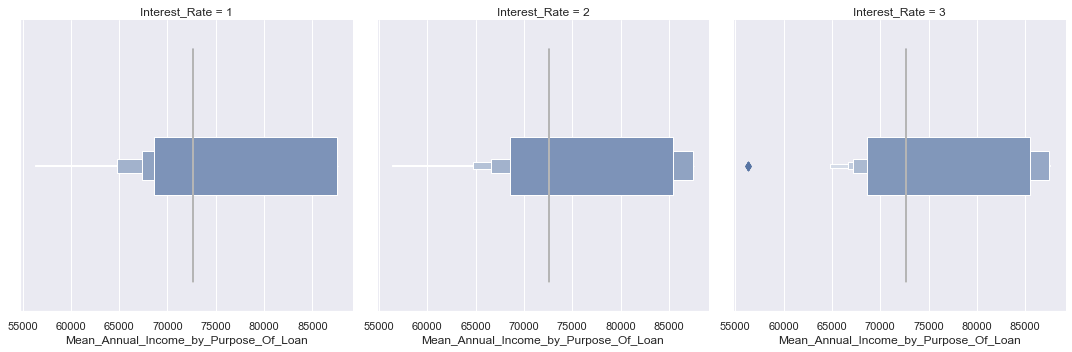



Mean_Annual_Income_by_Purpose_Of_Loan
Purpose_Of_Loan
renewable_energy      87605.974510
home_improvement      87492.606976
small_business        85464.524264
house                 80259.408524
medical               77289.943443
major_purchase        73293.409006
debt_consolidation    72616.688993
credit_card           72540.990505
other                 68599.845256
moving                67381.074957
wedding               67136.654755
vacation              66618.745775
car                   64774.423596
educational           56326.835179
Name: Annual_Income, dtype: float64


Quasi-normalized Mean_Annual_Income_by_Purpose_Of_Loan


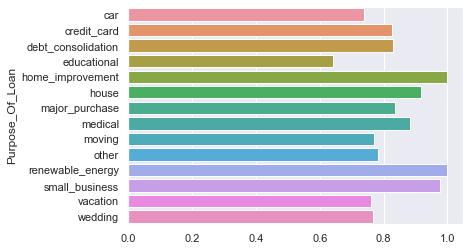



Comparison od normalized within categories and original Annual_Income


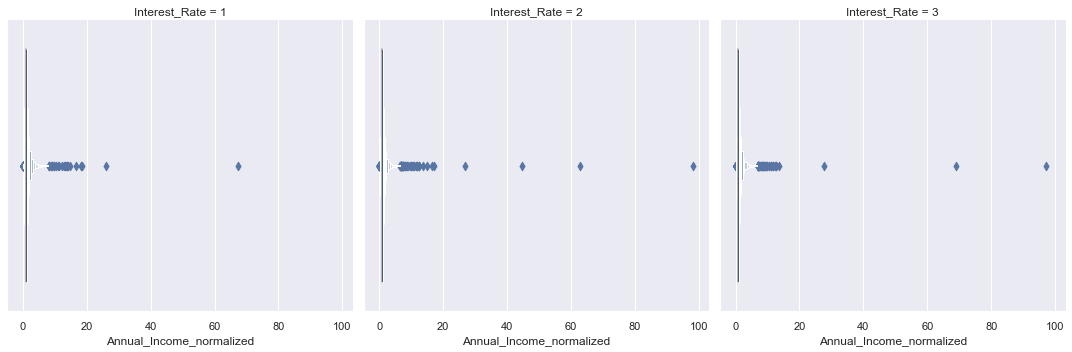

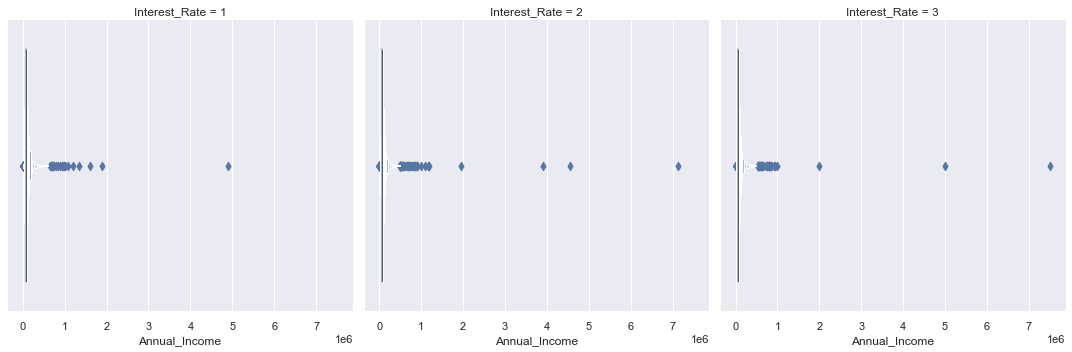





Mean_Debt_To_Income_by_Purpose_Of_Loan by Interest_Rate


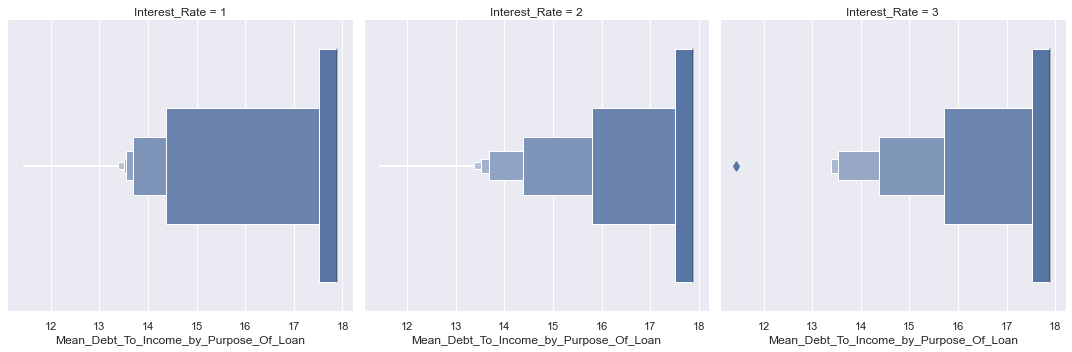



Mean_Debt_To_Income_by_Purpose_Of_Loan
Purpose_Of_Loan
debt_consolidation    17.889914
credit_card           17.515313
medical               16.024361
other                 15.792461
vacation              15.706320
moving                15.378655
renewable_energy      15.089431
home_improvement      14.376742
wedding               13.935978
major_purchase        13.689965
house                 13.538111
car                   13.516350
small_business        13.381789
educational           11.427686
Name: Debt_To_Income, dtype: float64


Quasi-normalized Mean_Debt_To_Income_by_Purpose_Of_Loan


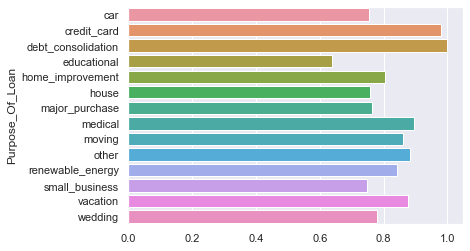



Comparison od normalized within categories and original Debt_To_Income


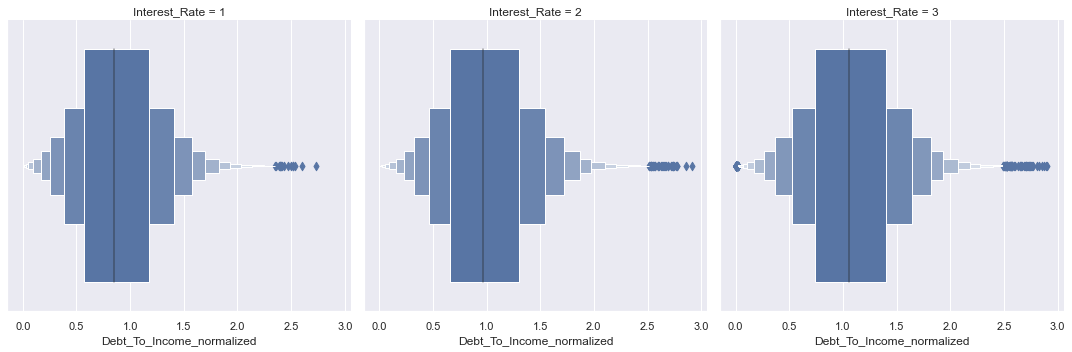

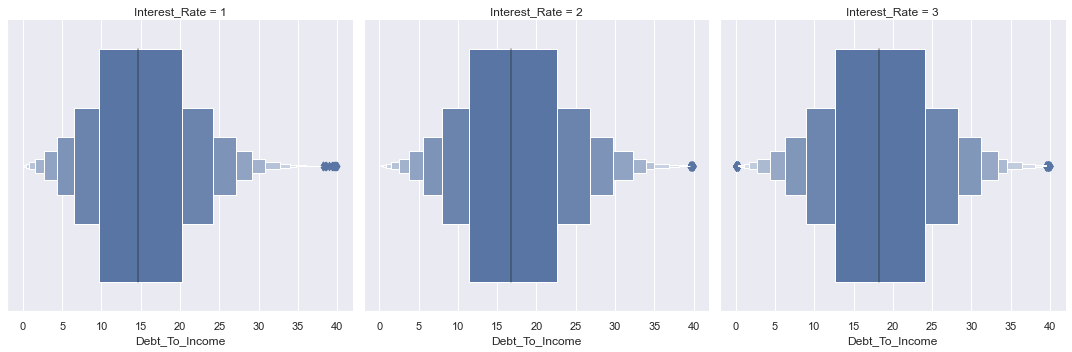





Mean_Inquiries_Last_6Mo_by_Purpose_Of_Loan by Interest_Rate


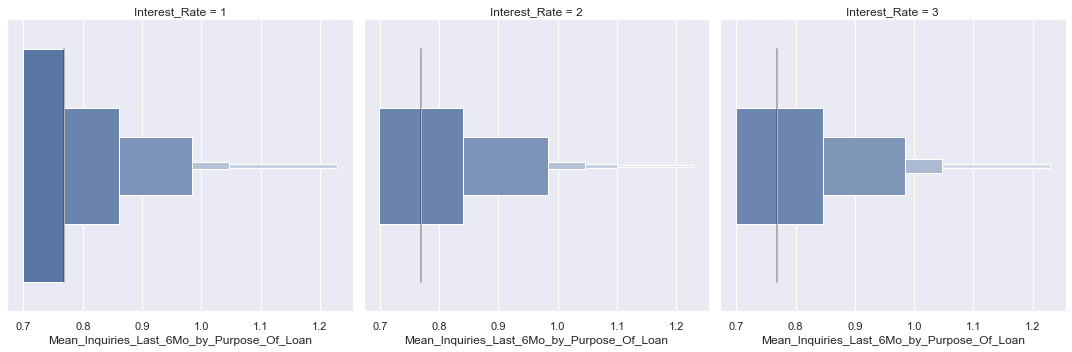



Mean_Inquiries_Last_6Mo_by_Purpose_Of_Loan
Purpose_Of_Loan
house                 1.228978
educational           1.099174
renewable_energy      1.048780
small_business        1.046405
home_improvement      0.984249
wedding               0.954106
moving                0.881930
major_purchase        0.879476
car                   0.860477
vacation              0.847073
other                 0.840522
medical               0.827385
debt_consolidation    0.768942
credit_card           0.699106
Name: Inquiries_Last_6Mo, dtype: float64


Quasi-normalized Mean_Inquiries_Last_6Mo_by_Purpose_Of_Loan


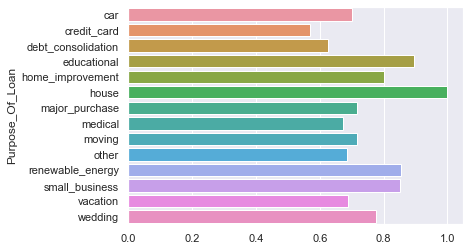



Comparison od normalized within categories and original Inquiries_Last_6Mo


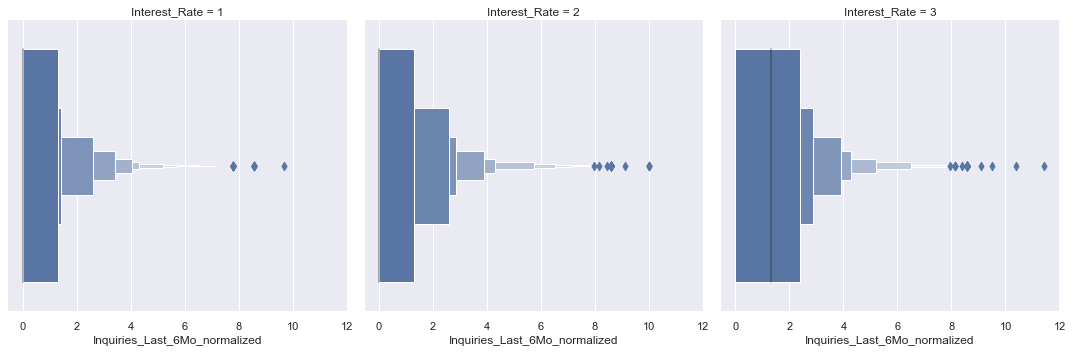

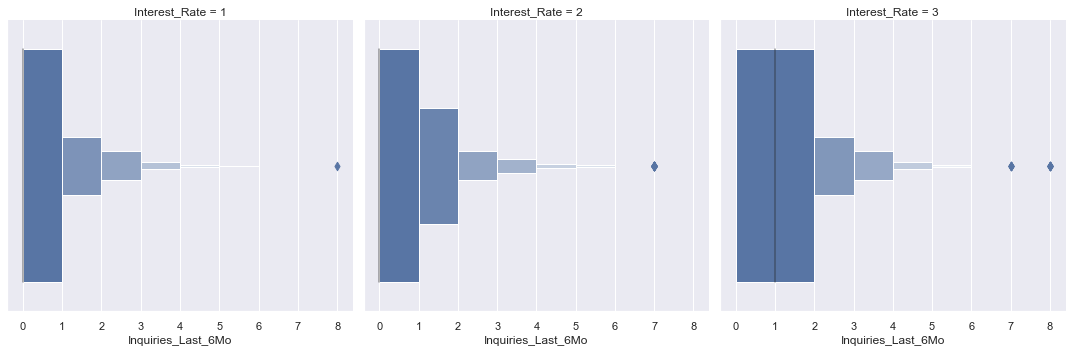





Mean_Months_Since_Deliquency_by_Purpose_Of_Loan by Interest_Rate


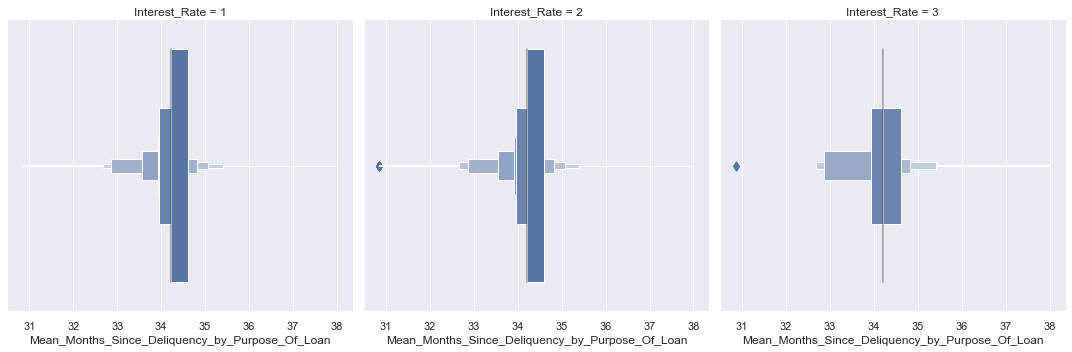



Mean_Months_Since_Deliquency_by_Purpose_Of_Loan
Purpose_Of_Loan
renewable_energy      38.000000
vacation              35.401496
wedding               35.070822
car                   34.825293
credit_card           34.606929
debt_consolidation    34.215180
house                 34.008043
home_improvement      33.961161
other                 33.925556
moving                33.561521
major_purchase        33.559066
small_business        32.867769
medical               32.677463
educational           30.857143
Name: Months_Since_Deliquency, dtype: float64


Quasi-normalized Mean_Months_Since_Deliquency_by_Purpose_Of_Loan


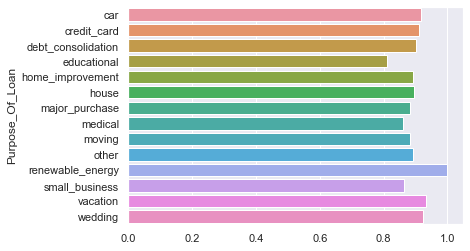



Comparison od normalized within categories and original Months_Since_Deliquency


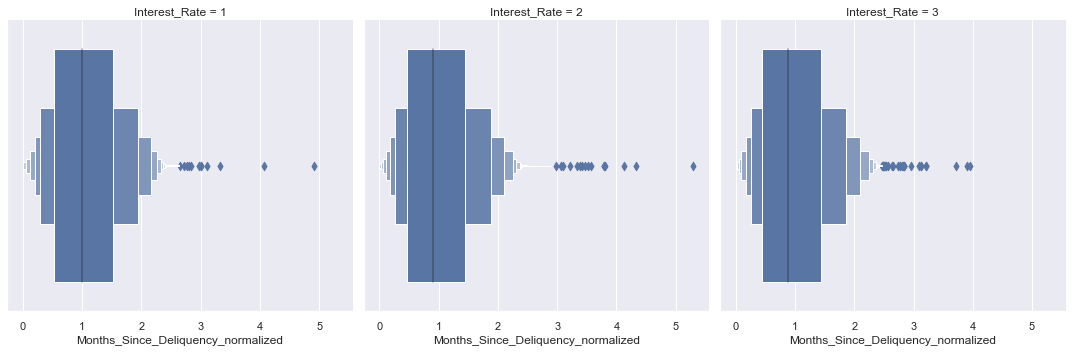

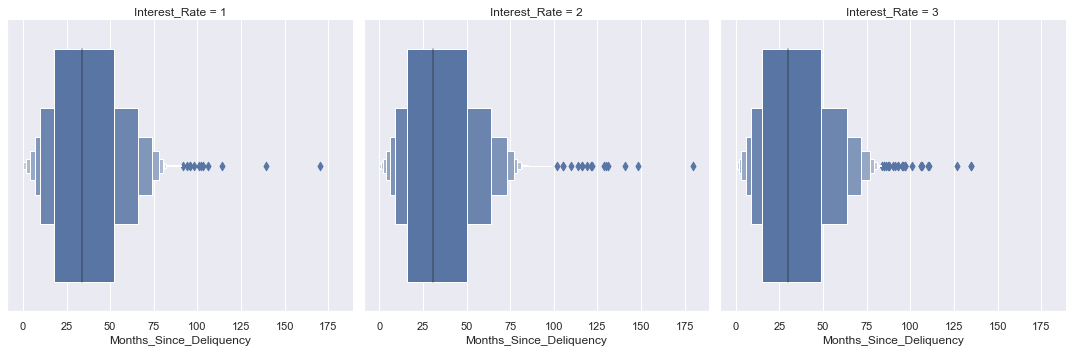





Mean_Number_Open_Accounts_by_Purpose_Of_Loan by Interest_Rate


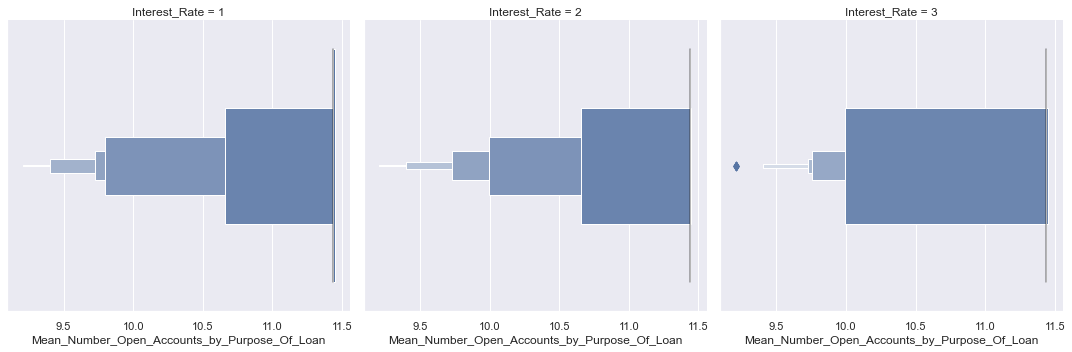



Mean_Number_Open_Accounts_by_Purpose_Of_Loan
Purpose_Of_Loan
credit_card           11.447988
debt_consolidation    11.437184
renewable_energy      10.756098
home_improvement      10.659510
medical               10.216093
moving                10.042094
house                 10.018111
other                  9.994249
small_business         9.795987
wedding                9.756039
vacation               9.751493
major_purchase         9.726346
car                    9.402122
educational            9.206612
Name: Number_Open_Accounts, dtype: float64


Quasi-normalized Mean_Number_Open_Accounts_by_Purpose_Of_Loan


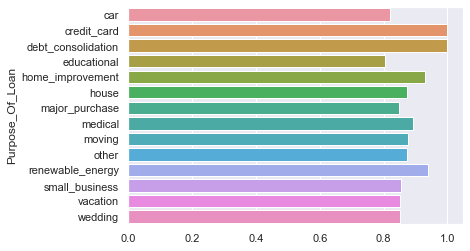



Comparison od normalized within categories and original Number_Open_Accounts


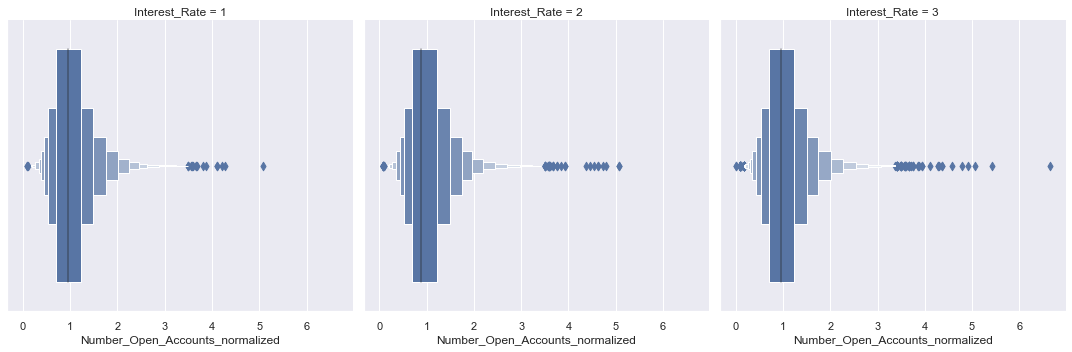

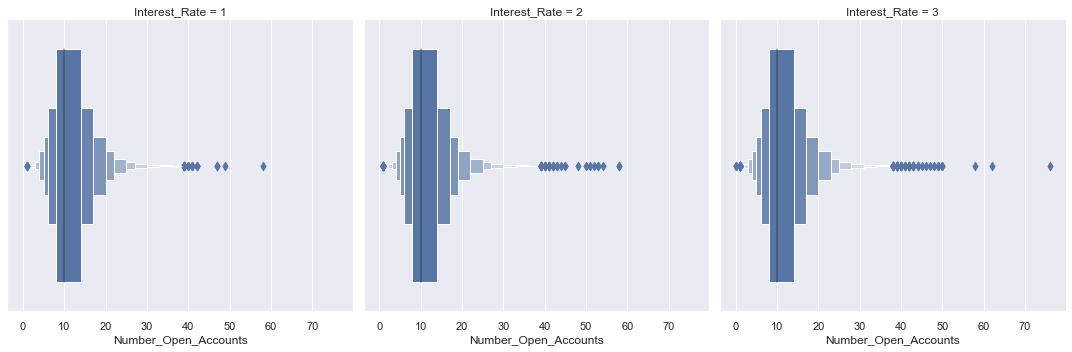





Mean_Total_Accounts_by_Purpose_Of_Loan by Interest_Rate


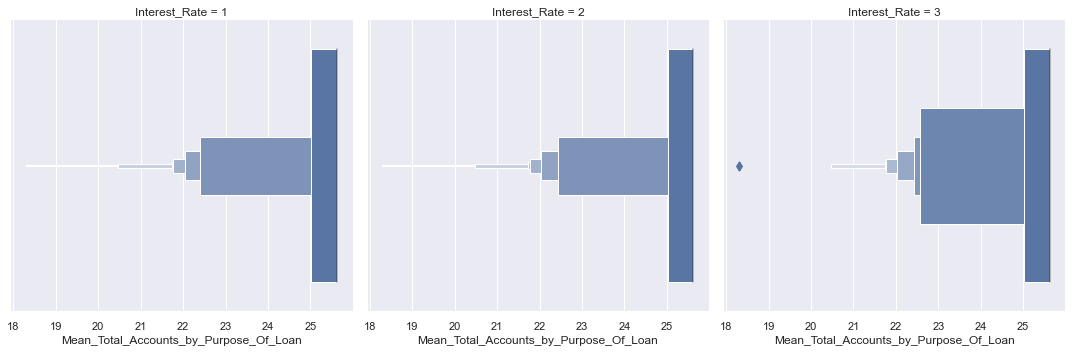



Mean_Total_Accounts_by_Purpose_Of_Loan
Purpose_Of_Loan
debt_consolidation    25.626698
home_improvement      25.597691
credit_card           25.014611
medical               24.160286
renewable_energy      24.154472
house                 23.758085
small_business        22.575669
other                 22.428109
vacation              22.402628
major_purchase        22.035517
car                   21.768170
moving                21.732033
wedding               20.475845
educational           18.297521
Name: Total_Accounts, dtype: float64


Quasi-normalized Mean_Total_Accounts_by_Purpose_Of_Loan


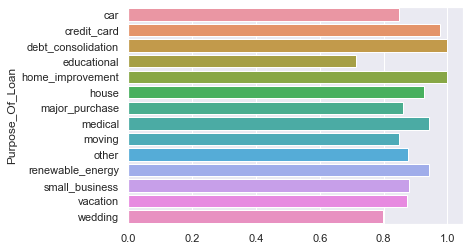



Comparison od normalized within categories and original Total_Accounts


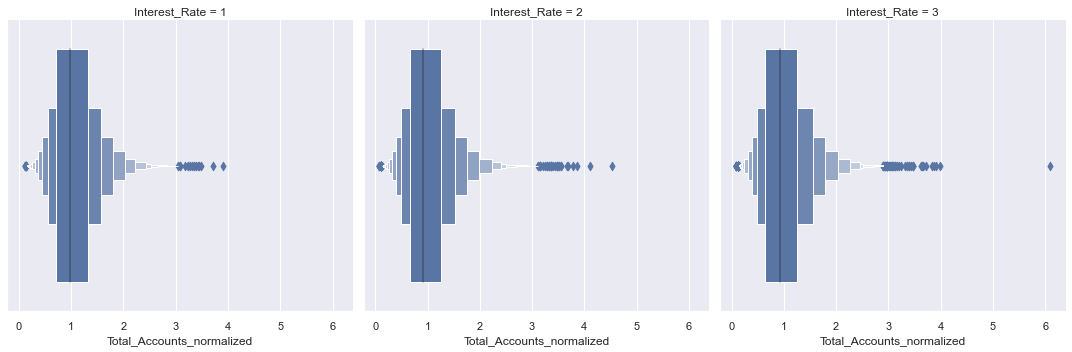

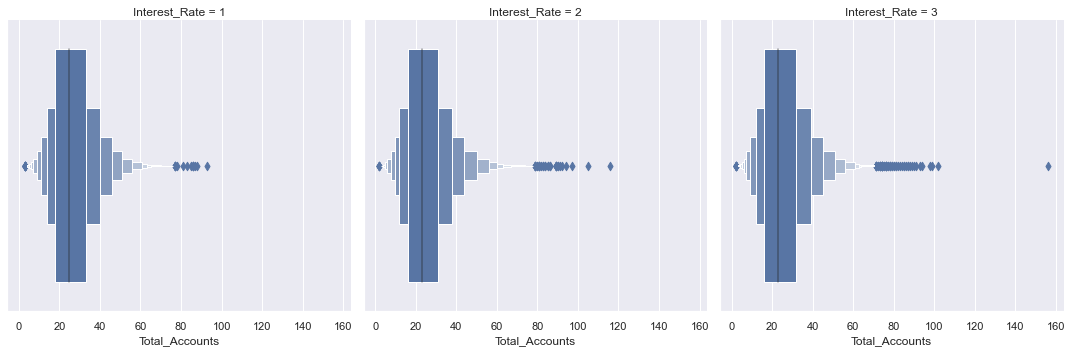





Mean_Open_To_All_Accounts_by_Purpose_Of_Loan by Interest_Rate


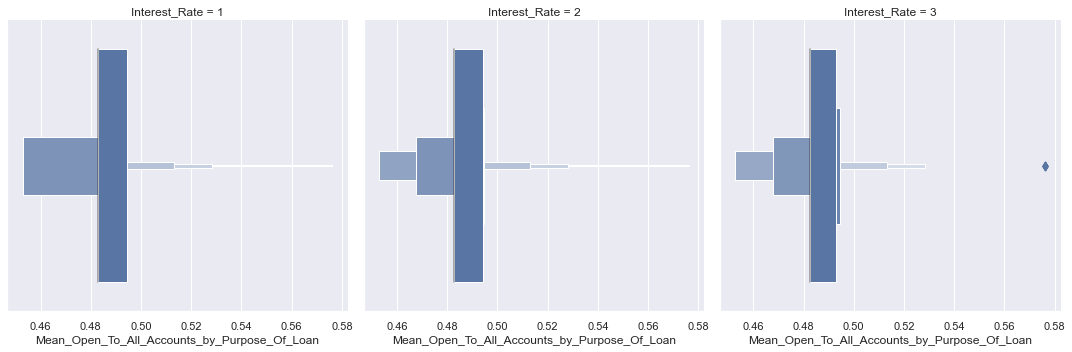



Mean_Open_To_All_Accounts_by_Purpose_Of_Loan
Purpose_Of_Loan
educational           0.576227
wedding               0.528343
moving                0.513134
credit_card           0.494575
other                 0.494206
major_purchase        0.492964
car                   0.486620
debt_consolidation    0.482749
vacation              0.482132
renewable_energy      0.478398
small_business        0.476992
house                 0.471396
medical               0.467775
home_improvement      0.452886
Name: Open_To_All_Accounts, dtype: float64


Quasi-normalized Mean_Open_To_All_Accounts_by_Purpose_Of_Loan


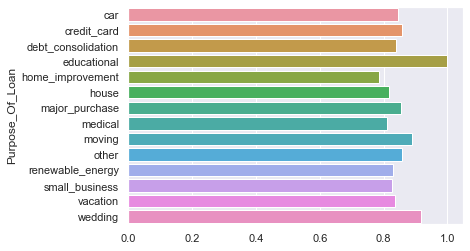



Comparison od normalized within categories and original Open_To_All_Accounts


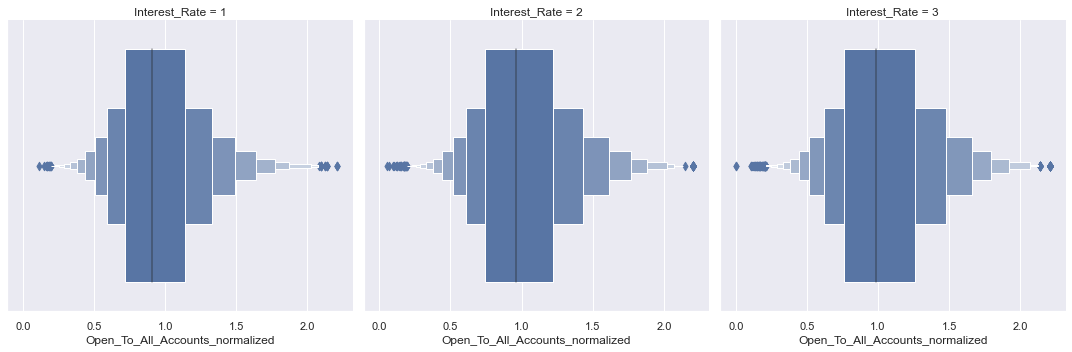

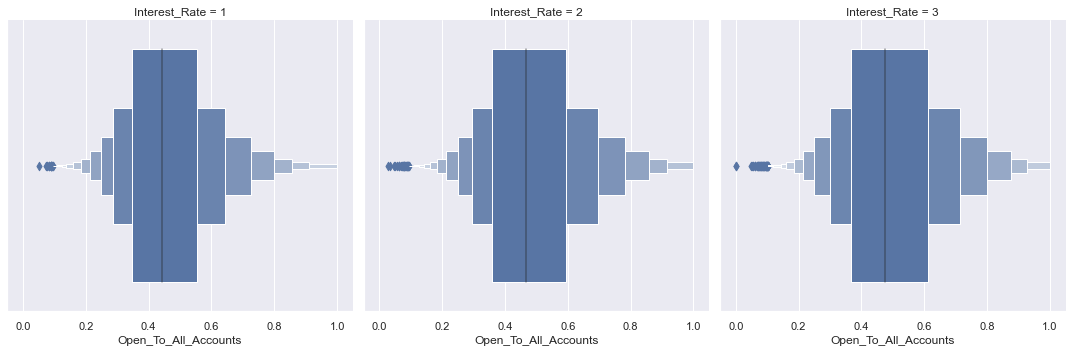





Mean_Loan_To_Income_by_Purpose_Of_Loan by Interest_Rate


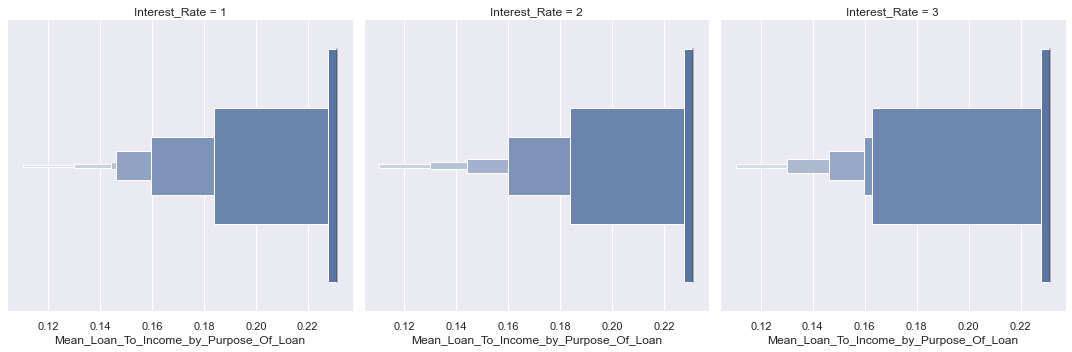



Mean_Loan_To_Income_by_Purpose_Of_Loan
Purpose_Of_Loan
debt_consolidation    0.231313
credit_card           0.227751
house                 0.215877
small_business        0.211580
home_improvement      0.183840
wedding               0.171252
educational           0.165002
major_purchase        0.162759
renewable_energy      0.162748
other                 0.159823
car                   0.146340
medical               0.144211
moving                0.129939
vacation              0.110335
Name: Loan_To_Income, dtype: float64


Quasi-normalized Mean_Loan_To_Income_by_Purpose_Of_Loan


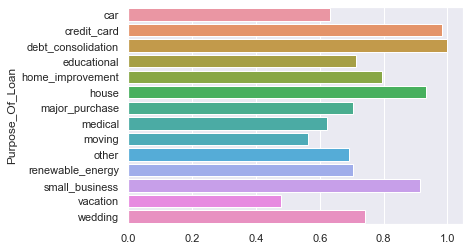



Comparison od normalized within categories and original Loan_To_Income


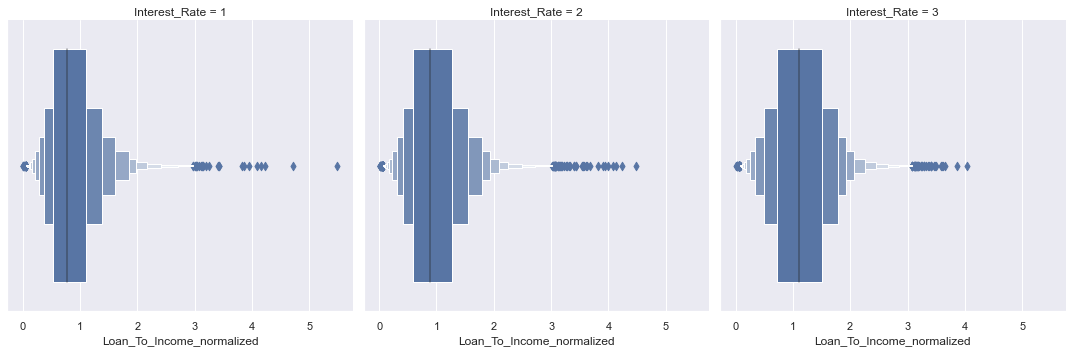

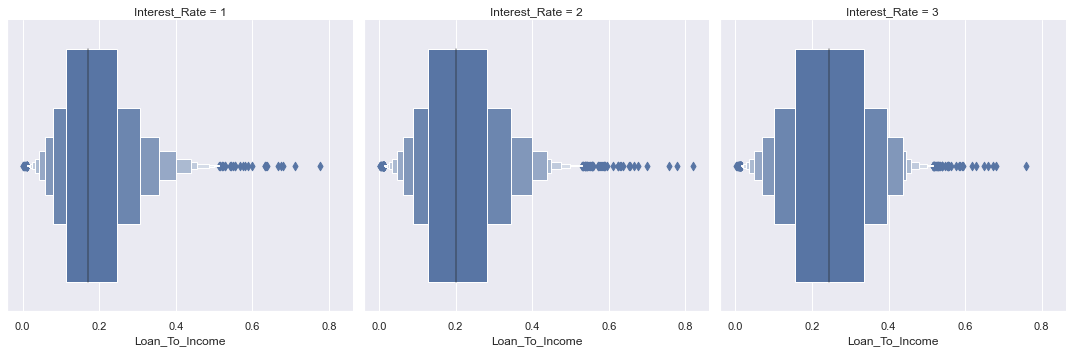





Mean_Debt_To_Loan_by_Purpose_Of_Loan by Interest_Rate


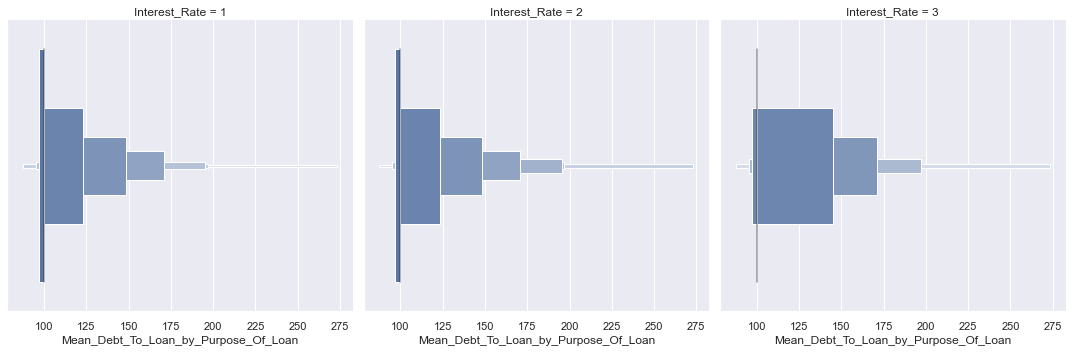



Mean_Debt_To_Loan_by_Purpose_Of_Loan
Purpose_Of_Loan
vacation              273.311463
moving                196.932593
medical               195.342459
other                 170.983891
renewable_energy      151.039629
major_purchase        148.468635
car                   144.942716
home_improvement      123.139376
wedding               121.779628
educational           120.332603
debt_consolidation     99.804031
credit_card            96.892391
small_business         95.266295
house                  87.468236
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Purpose_Of_Loan


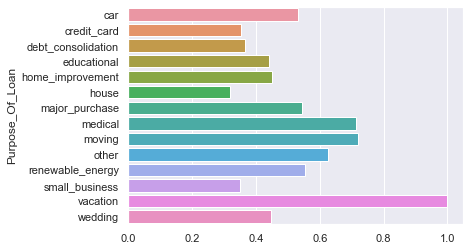



Comparison od normalized within categories and original Debt_To_Loan


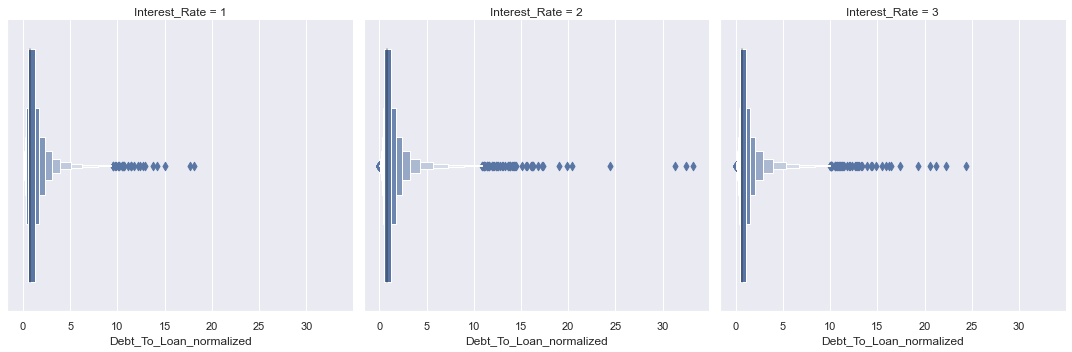

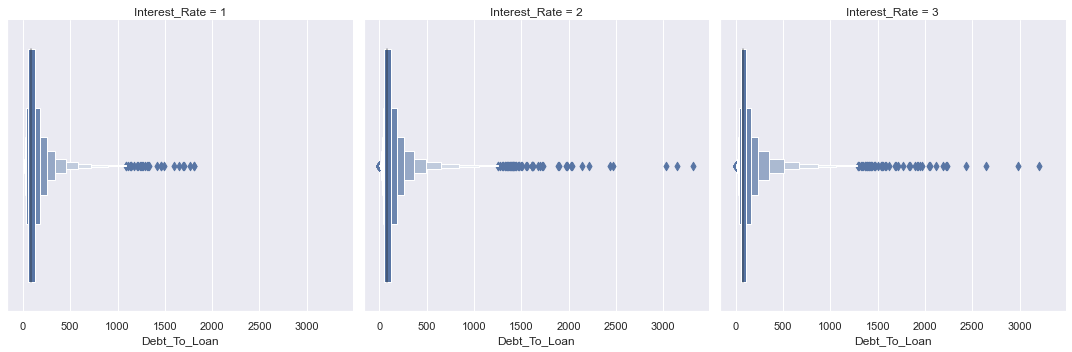





Mean_Num_Length_Employed_by_Purpose_Of_Loan by Interest_Rate


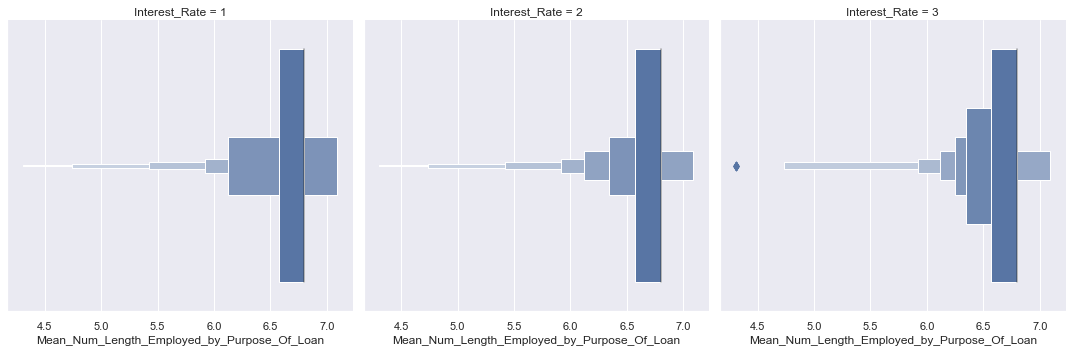



Mean_Num_Length_Employed_by_Purpose_Of_Loan
Purpose_Of_Loan
home_improvement      7.090193
debt_consolidation    6.797881
renewable_energy      6.682927
vacation              6.643967
credit_card           6.571175
medical               6.371836
other                 6.345195
small_business        6.250418
house                 6.125485
major_purchase        6.119360
car                   5.917772
wedding               5.419082
moving                4.737166
educational           4.305785
Name: Num_Length_Employed, dtype: float64


Quasi-normalized Mean_Num_Length_Employed_by_Purpose_Of_Loan


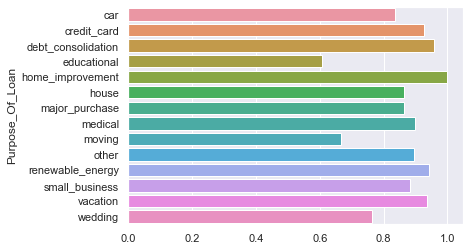



Comparison od normalized within categories and original Num_Length_Employed


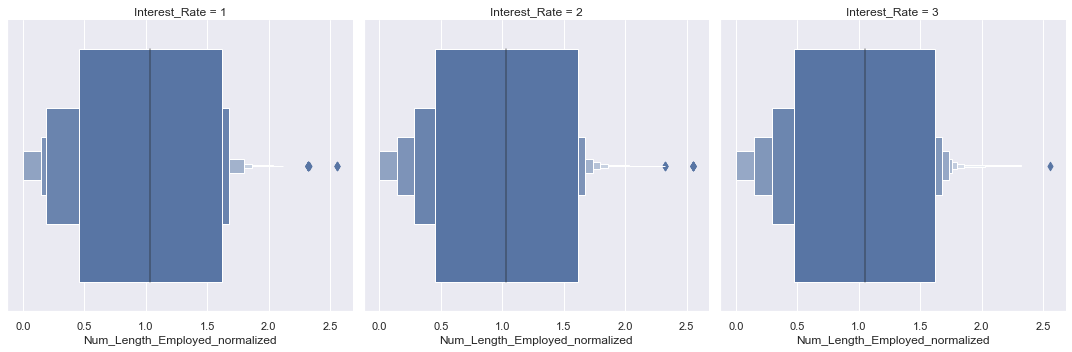

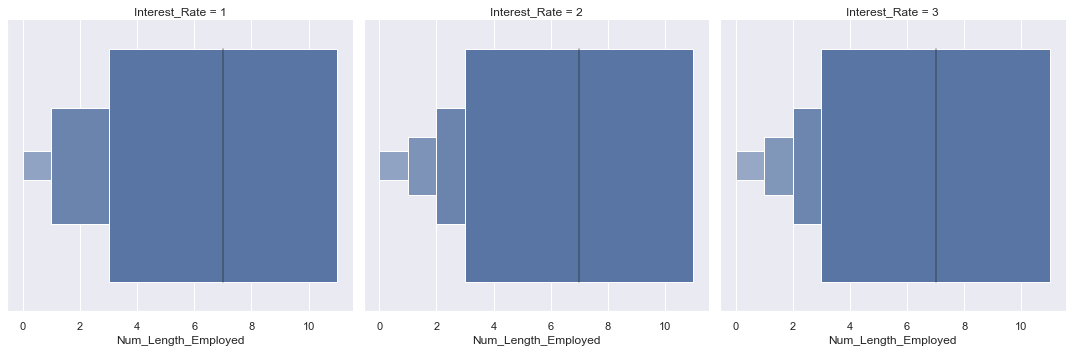

In [25]:
for cat_column_name in applicable_categorical_variables:
    for num_column_name in applicable_numeric_variables:
        aggregate_num_column_by_cat_column(df, target_column, cat_column_name, num_column_name)

In [26]:
df

,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,...,Mean_Annual_Income_by_Purpose_Of_Loan,Mean_Debt_To_Income_by_Purpose_Of_Loan,Mean_Inquiries_Last_6Mo_by_Purpose_Of_Loan,Mean_Months_Since_Deliquency_by_Purpose_Of_Loan,Mean_Number_Open_Accounts_by_Purpose_Of_Loan,Mean_Total_Accounts_by_Purpose_Of_Loan,Mean_Open_To_All_Accounts_by_Purpose_Of_Loan,Mean_Loan_To_Income_by_Purpose_Of_Loan,Mean_Debt_To_Loan_by_Purpose_Of_Loan,Mean_Num_Length_Employed_by_Purpose_Of_Loan
0,7000,< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,...,64774.423596,13.516350,0.860477,34.825293,9.402122,21.768170,0.486620,0.146340,144.942716,5.917772
1,30000,4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,...,72616.688993,17.889914,0.768942,34.215180,11.437184,25.626698,0.482749,0.231313,99.804031,6.797881
2,24725,7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,...,72616.688993,17.889914,0.768942,34.215180,11.437184,25.626698,0.482749,0.231313,99.804031,6.797881
3,16000,< 1 year,missing,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,...,72616.688993,17.889914,0.768942,34.215180,11.437184,25.626698,0.482749,0.231313,99.804031,6.797881
4,17000,8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,...,72616.688993,17.889914,0.768942,34.215180,11.437184,25.626698,0.482749,0.231313,99.804031,6.797881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,20725,10+ years,Rent,NaN,VERIFIED - income source,credit_card,13.56,0,NaN,13,...,72540.990505,17.515313,0.699106,34.606929,11.447988,25.014611,0.494575,0.227751,96.892391,6.571175
164305,6000,8 years,Own,NaN,VERIFIED - income source,small_business,9.12,0,36.0,13,...,85464.524264,13.381789,1.046405,32.867769,9.795987,22.575669,0.476992,0.211580,95.266295,6.250418
164306,20250,10+ years,Mortgage,NaN,VERIFIED - income,credit_card,18.17,1,NaN,17,...,72540.990505,17.515313,0.699106,34.606929,11.447988,25.014611,0.494575,0.227751,96.892391,6.571175
164307,10000,4 years,Rent,NaN,not verified,major_purchase,18.75,1,48.0,16,...,73293.409006,13.689965,0.879476,33.559066,9.726346,22.035517,0.492964,0.162759,148.468635,6.119360


Mean_Debt_To_Loan_by_Length_Employed by Interest_Rate


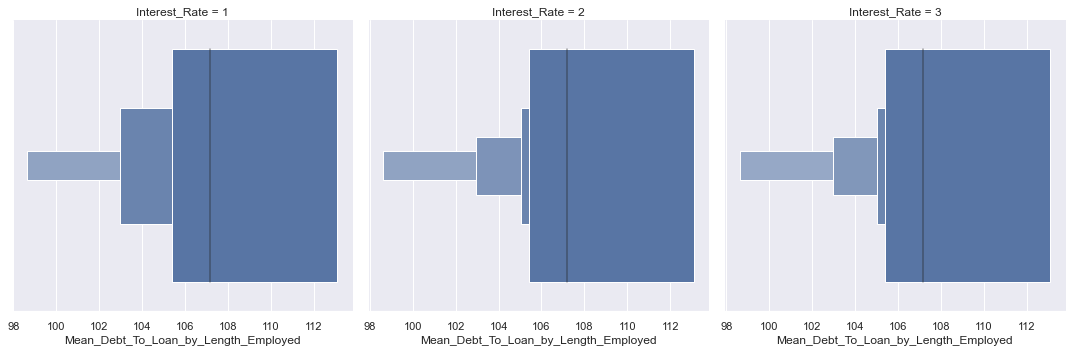



Mean_Debt_To_Loan_by_Length_Employed
Length_Employed
10+ years    113.088273
8 years      108.956134
9 years      108.129934
7 years      107.420041
5 years      107.169475
6 years      107.100269
3 years      106.035653
4 years      105.554797
2 years      105.398999
1 year       105.038189
< 1 year     102.967381
missing       98.639754
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Length_Employed


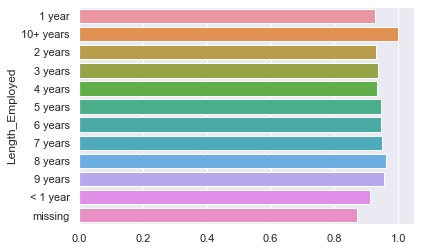



Comparison od normalized within categories and original Debt_To_Loan


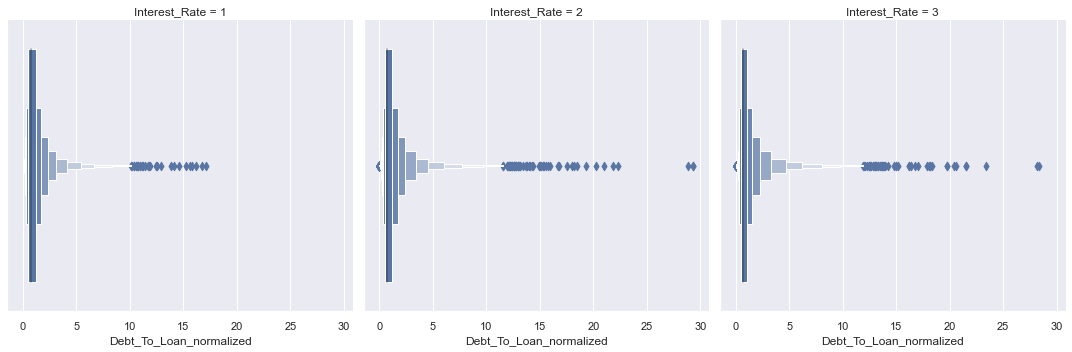

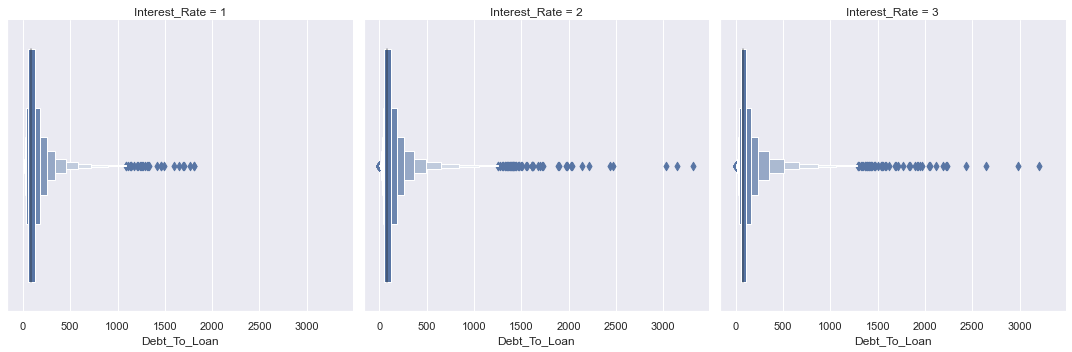





Mean_Debt_To_Loan_by_Home_Owner by Interest_Rate


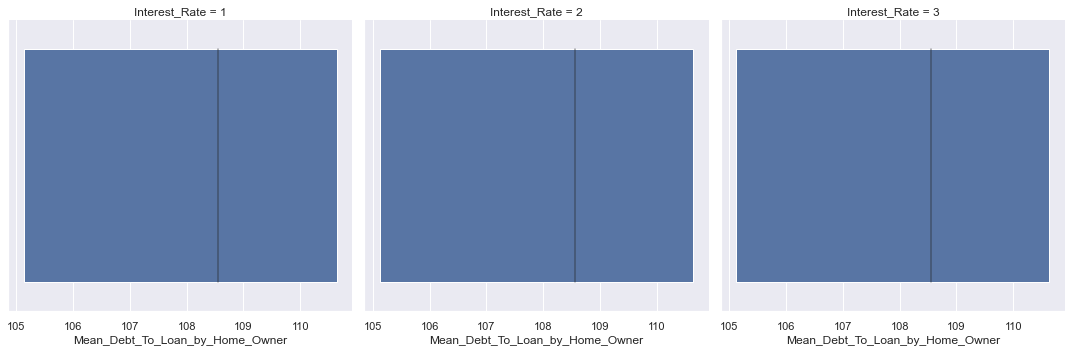



Mean_Debt_To_Loan_by_Home_Owner
Home_Owner
Mortgage    110.640947
missing     108.558917
Own         105.150502
Rent        105.127025
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Home_Owner


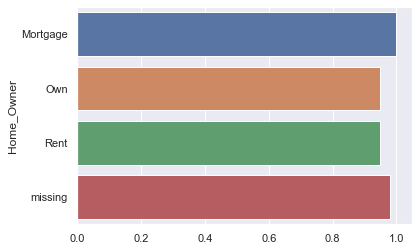



Comparison od normalized within categories and original Debt_To_Loan


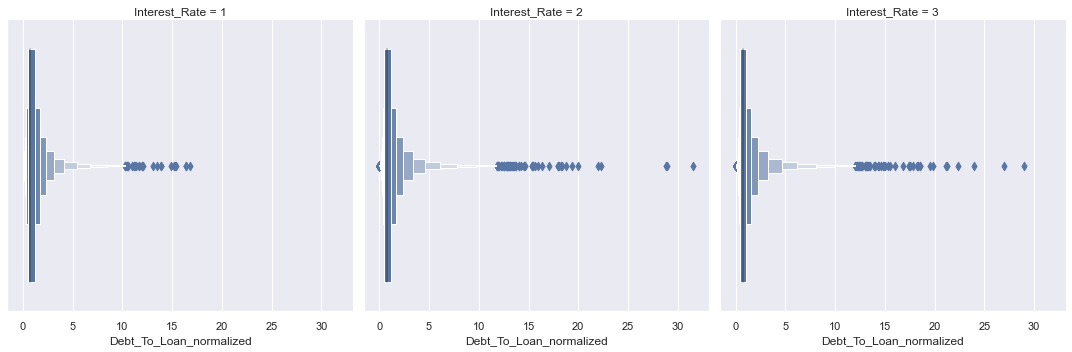

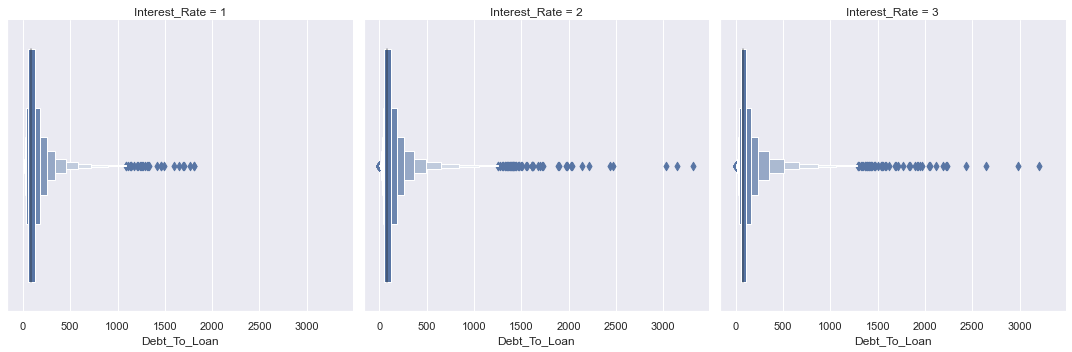





Mean_Debt_To_Loan_by_Income_Verified by Interest_Rate


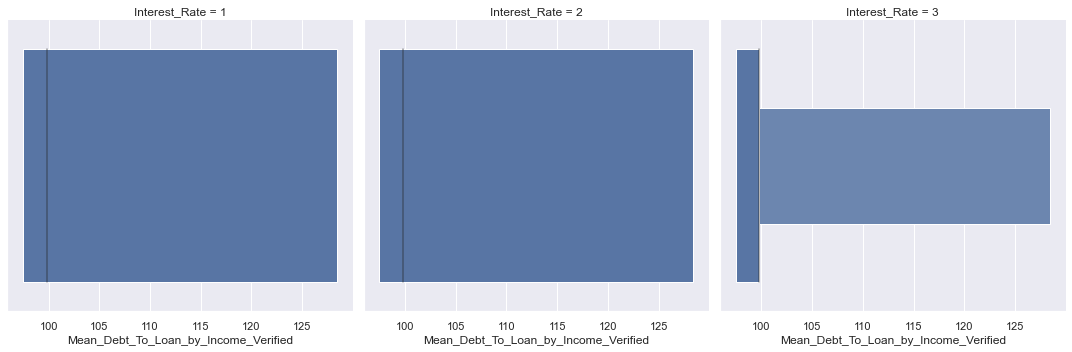



Mean_Debt_To_Loan_by_Income_Verified
Income_Verified
not verified                128.437011
VERIFIED - income source     99.810111
VERIFIED - income            97.470794
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Income_Verified


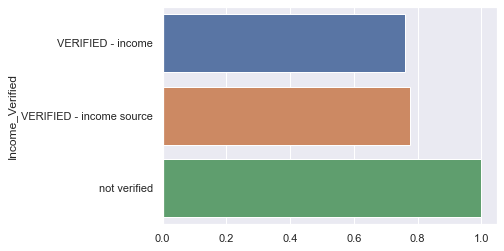



Comparison od normalized within categories and original Debt_To_Loan


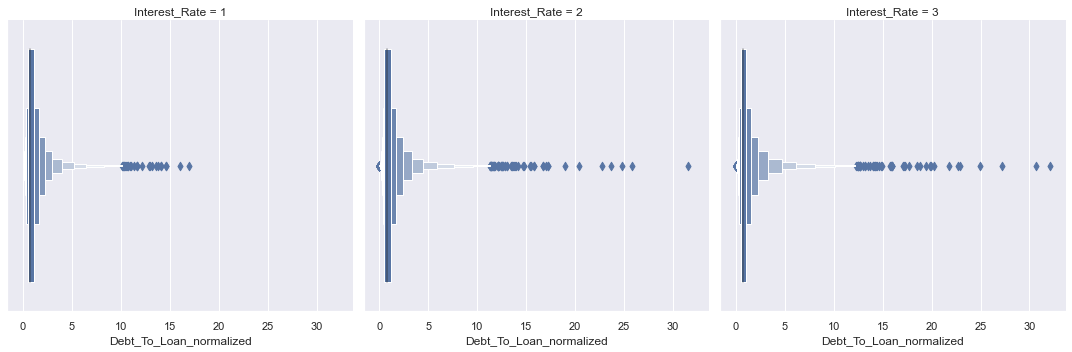

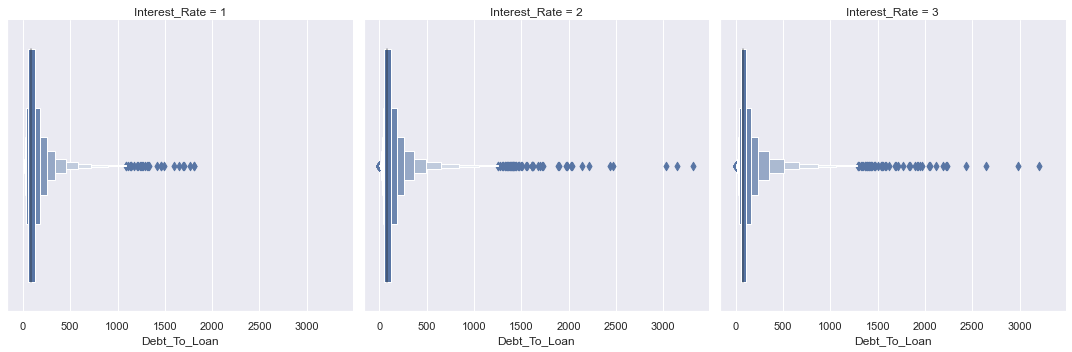





Mean_Debt_To_Loan_by_Purpose_Of_Loan by Interest_Rate


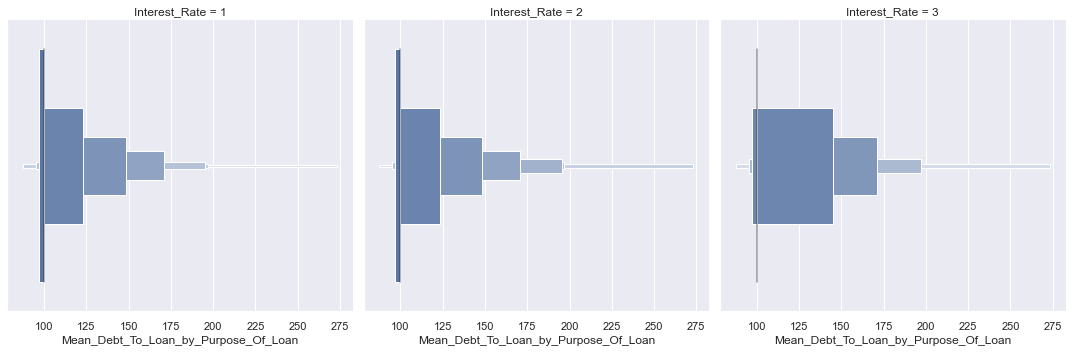



Mean_Debt_To_Loan_by_Purpose_Of_Loan
Purpose_Of_Loan
vacation              273.311463
moving                196.932593
medical               195.342459
other                 170.983891
renewable_energy      151.039629
major_purchase        148.468635
car                   144.942716
home_improvement      123.139376
wedding               121.779628
educational           120.332603
debt_consolidation     99.804031
credit_card            96.892391
small_business         95.266295
house                  87.468236
Name: Debt_To_Loan, dtype: float64


Quasi-normalized Mean_Debt_To_Loan_by_Purpose_Of_Loan


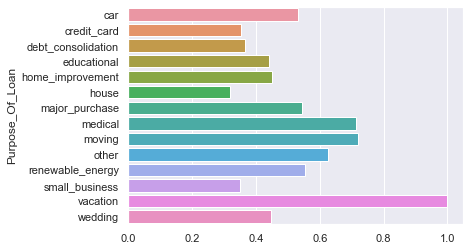



Comparison od normalized within categories and original Debt_To_Loan


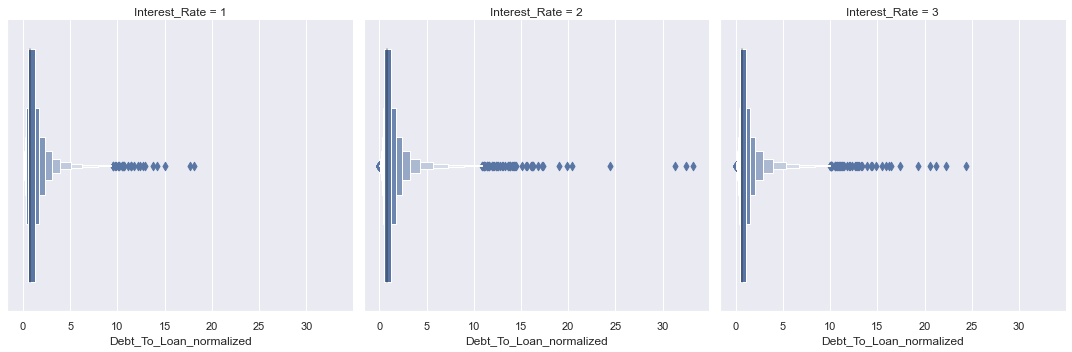

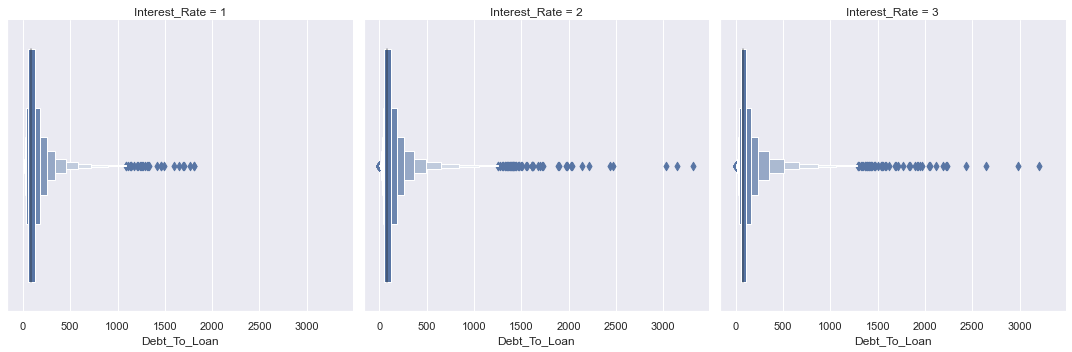

In [27]:
for cat_column_name in applicable_categorical_variables:
    num_column_name = 'Debt_To_Loan' #'Inquiries_Last_6Mo'
    aggregate_num_column_by_cat_column(df, target_column, cat_column_name, num_column_name)